In [7]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams
from matplotlib.patches import Patch
from matplotlib.colors import Normalize
import seaborn as sns
import pareto
from matplotlib.lines import Line2D
from scipy.stats import spearmanr, rankdata, gaussian_kde
import statsmodels.api as sm
import random

In [8]:
### check if in WSL (for Andrew) and if so, add font location
from platform import uname
if 'Microsoft' in uname().release:
  import matplotlib.font_manager as font_manager
  font_dirs = ['/mnt/c/Windows/Fonts/', ]
  font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
  for font_file in font_files:
    font_list = font_manager.fontManager.addfont(font_file)

## set default font type/size
rcParams['font.family'] = 'Arial'
rcParams.update({'font.size': 8})

In [9]:
### wes anderson color pallettes from r
# wes_palette('Zissou1',6,type='continuous')[1:6]
# [1] "#3B9AB2" "#6BB1C1" "#BDC367" "#E6C019" "#E49100" "#F21A00"
# wes_palette('Zissou1',4,type='continuous')[1:4]
# "#3B9AB2" "#9EBE91" "#E4B80E" "#F21A00"
# wes_palette('Cavalcanti1')[1:5]
# [1] "#D8B70A" "#02401B" "#A2A475" "#81A88D" "#972D15"
# pal_zissou6 = ["#3B9AB2", "#6BB1C1", "#BDC367", "#E6C019", "#E49100", "#F21A00"]
# wes_palette('Rushmore1',8,type='continuous')[1:8]
# [1] "#E1BD6D" "#E6BD83" "#CAB38C" "#4A8B6D" "#166058" "#2E324C" "#852A30" "#F2300F"

pal_rushmore_8 = ["#E1BD6D", "#E6BD83", "#CAB38C", "#4A8B6D", "#166058", "#2E324C", "#852A30", "#F2300F"]
pal_zissou1_5 = ["#3B9AB2", "#78B7C5", "#EBCC2A", "#E1AF00", "#F21A00"]
pal_cav1_5 = ["#D8B70A", "#02401B", "#A2A475", "#81A88D", "#972D15"]
pal_iod1_6 = ["#9986A5", "#79402E", "#CCBA72", "#0F0D0E", "#D9D0D3", "#8D8680"]
pal_cb = ['#7570b3', '#1b9e77', '#d95f02']


In [10]:
### get results
results = pd.read_csv('FKC_experiment/objs_clean.csv')#.iloc[:2000,]
### remove extra samples
results['samp_num'] = -1
results.samp_num[:-6] = pd.to_numeric(results.samp[:-6])
results = results.loc[results.samp_num < 3000]
results.reset_index(inplace=True, drop=True)

### filter out high avg prices
dataname = 'full'
# results = results.loc[results['total_partner_avg_gain'] > 0, :]
# results = results.loc[results['avg_price_gain_dolAF'] < 1000, :]
# dataname = 'filtered'
print(results.shape)


(27006, 244)


/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (183) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [11]:
districts = [d.split('_')[0] for d in results.columns if 'w5yr_gain' in d.split('_',1)]
share_keys = [d + '_share' for d in districts]
exp_gain_keys = [d + '_exp_gain' for d in districts]
w5yr_gain_keys = [d + '_w5yr_gain' for d in districts]
avg_price_keys = [d + '_avg_price' for d in districts]
objs_keys = ['total_partner_avg_gain', 'min_partner_avg_gain','total_other_avg_gain', 'min_other_avg_gain', 'total_partner_w5yr_gain','min_partner_w5yr_gain', 'ginicoef', 'avg_price_gain_dolAF']

In [44]:
# ## divide prices by 100
# results.avg_price_gain_dolAF /= 100
# results.worst_price_avg_gain /= 100

In [ ]:
# # ### get avg price paid for water for each district. cap at $2000.
# cap = 2000
# for d in districts:
#     results[d + '_avg_price'] = results['avg_price_gain_dolAF'] * results[d + '_share'] * results['total_partner_avg_gain'] / results[d + '_exp_gain'] 
#     results[d + '_avg_price'] = [cap if p < 0 or p > cap else p for p in results[d + '_avg_price']]
# results['avg_price_gain_dolAF'] = [cap if p < 0 or p > cap else p for p in results['avg_price_gain_dolAF']]

In [12]:
### fix district costs, method in clean_objs.py doesn't handle negative-CWG projects correctly
cap = 2000
### get avg price of water gains per year
FKC_cost = 500e6
FKC_fed_payment = 200e6
FKC_east_tule_payment = 125e6
FKC_participant_payment = FKC_cost - FKC_fed_payment - FKC_east_tule_payment
CFWB_cost = 100e6
interest_annual = 0.03
time_horizon = 50

principle = {'FKC': FKC_participant_payment, 'CFWB': CFWB_cost, 'FKC_CFWB': FKC_participant_payment + CFWB_cost}
payments_per_yr = 1
interest_rt = interest_annual / payments_per_yr
num_payments = time_horizon * payments_per_yr
annual_payment = {k: principle[k] / (((1 + interest_rt) ** num_payments - 1) / (interest_rt * (1 + interest_rt) ** num_payments)) for k in principle}
print(annual_payment)
results['annual_payment'] = [annual_payment[p] for p in results['project']]
results['avg_price_gain_dolAF'] = results['annual_payment'] / results['total_partner_avg_gain'] / 1000
results['avg_price_gain_dolAF'].loc[np.logical_or(results['avg_price_gain_dolAF'] < 0, results['avg_price_gain_dolAF'] > cap)] = cap
for d in districts:
    results[d + '_avg_price'] = results['annual_payment'] * results[d + '_share'] / results[d + '_exp_gain'] / 1000
    results[d + '_avg_price'].loc[np.logical_or(results[d + '_avg_price'] < 0, results[d + '_avg_price'] > cap)] = cap
results['worst_price_avg_gain'] = np.max(results.loc[:,avg_price_keys], axis=1)

{'FKC': 6801461.52729321, 'CFWB': 3886549.444167549, 'FKC_CFWB': 10688010.97146076}


/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

In [13]:
## color & marker by hydro/project
projects = ['FKC','CFWB','FKC_CFWB']
hydros = ['dry','median','wet']
categories_dict = {'project': projects, 'hydro': hydros}
cmap = cm.get_cmap('viridis')
# cdict_project = {'FKC': pal_rushmore_8[0], 'CFWB': pal_rushmore_8[3], 'FKC_CFWB': pal_rushmore_8[5]}
cdict_project = {'FKC': '0.8', 'CFWB': '0.7', 'FKC_CFWB': '0.6'}
# cdict_hydro = {'wet': pal_rushmore_8[4], 'median': pal_rushmore_8[2], 'dry': pal_rushmore_8[6]}
cdict_hydro = {'wet': pal_zissou1_5[0], 'median': pal_zissou1_5[2], 'dry': pal_zissou1_5[4]}
# cdict_hydro = {'wet': pal_cb[0], 'median': pal_cb[1], 'dry': pal_cb[2]}
cdict_categories_dict = {'project':cdict_project, 'hydro':cdict_hydro}
mdict_project = {'FKC': 's', 'FKC_CFWB':'v', 'CFWB': 'o'}
mdict_hydro = {'wet': 'v', 'median': 'o', 'dry': '*'}
ldict_project = {'FKC': 'Canal', 'FKC_CFWB':'Both', 'CFWB': 'Bank'}
ldict_hydro = {'wet': 'Wet', 'median': 'Avg', 'dry': 'Dry'}

In [14]:
results['c_project'] = [cdict_project[i] for i in results.project]
results['c_hydro'] = [cdict_hydro[i] for i in results.hydro]
results['m_project'] = [mdict_project[i] for i in results.project]
results['m_hydro'] = [mdict_hydro[i] for i in results.hydro]

## full label for each project
project_label_dict = {'FKC':'Canal expansion', 'CFWB':'New water bank', 'FKC_CFWB':'Both projects'}
results['project_label'] = [project_label_dict[p] for p in results['project']]
for k,v in list(cdict_project.items()):
    cdict_project[project_label_dict[k]] = v
hydro_label_dict = {'wet':'Wet time series', 'dry':'Dry time series', 'median':'Average time series'}
results['hydro_label'] = [hydro_label_dict[p] for p in results['hydro']]
for k,v in list(cdict_hydro.items()):
    cdict_hydro[hydro_label_dict[k]] = v

In [15]:
cols = ['total_partner_avg_gain', 'min_partner_avg_gain', 'total_partner_w5yr_gain', 'min_partner_w5yr_gain', 'total_other_avg_gain',
        'min_other_avg_gain', 'avg_price_gain_dolAF', 'ginicoef', 'num_partners']
labels = ['Total partners\navg. gain\n(tAF/yr)\n'+r'$\rightarrow$', 'Worst partner\navg. gain\n(tAF/yr)\n'+r'$\rightarrow$', 
          'Total partner\ndrought gain\n(tAF/yr)\n'+r'$\rightarrow$', 
          'Worst partner\ndrought gain\n(tAF/yr)\n'+r'$\rightarrow$', 'Total other\navg. gain\n(tAF/yr)\n'+r'$\rightarrow$',
          'Worst other\navg. gain\n(tAF/yr)\n'+r'$\rightarrow$', 'Avg. cost of\ngains\n($/AF)\n'+r'$\leftarrow$', 
          'Fairness\ncoefficient\n'+r'$\leftarrow$', 'Number of\npartners']
cdict_category = {'project': cdict_project, 'hydro': cdict_hydro, 'project_label': cdict_project, 'hydro_label': cdict_hydro,}

### ecdf (following https://cmdlinetips.com/2019/05/empirical-cumulative-distribution-function-ecdf-in-python/)
### y needs to be scaled to same scale as data for pairgrid
def ecdf(data, multiplier = 1):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    y *= multiplier
    return(x,y)

### full pairplots

In [16]:
# cols = ['total_partner_avg_gain', 'min_partner_avg_gain', 'total_partner_w5yr_gain',
#         'total_other_avg_gain', 'min_other_avg_gain', 'avg_price_gain_dolAF', 'ginicoef']
# labels = ['Total partners\navg. gain\n(kAF/yr)', 
#           'Worst partner\navg. gain\n(kAF/yr)', 
#           'Total partner\ndrought gain\n(kAF/yr)', 
#           'Total other\navg. gain\n(kAF/yr)', 'Worst other\navg. gain\n(tAF/yr)',
#           'Avg. cost of\ngains\n($/AF)', 'Fairness\ncoefficient']
# flip = [1, 1, 1, 1, 1, -1, -1]

cols = ['total_partner_avg_gain', 'total_partner_w5yr_gain', 'total_other_avg_gain',
        'avg_price_gain_dolAF', 'worst_price_avg_gain', 'ginicoef', 'num_partners']
labels = ['P-CWG\n(kAF/yr)', 
          'P-DDG\n(kAF/yr)', 
          'N-CWG\n(kAF/yr)',
          'P-Cost\n($100/AF)', 
          'WP-Cost\n($100/AF)', 
          'P-Fair',
          'P-Num']
flip = [1, 1, 1, -1, -1, -1, 1]
varticks = [[0,45,90], [-75,0,75], [-60,0,60], [5,2.5,0], [20,10,0], [1,0.5,0], [0,10,20]]
varticklabs = [['0','45','90'], ['-75','0','75'], ['-60','0','60'], ['5','2.5','0'], ['20','10','0'], ['1','0.5','0'], ['0','10','20']]
annots = [['a1)','a2)','a3)','a4)','a5)','a6)','a7)'], 
          ['b1)','b2)','b3)','b4)','b5)','b6)','b7)'], 
          ['c1)','c2)','c3)','c4)','c5)','c6)','c7)'], 
          ['d1)','d2)','d3)','d4)','d5)','d6)','d7)'], 
          ['e1)','e2)','e3)','e4)','e5)','e6)','e7)'], 
          ['f1)','f2)','f3)','f4)','f5)','f6)','f7)'], 
          ['g1)','g2)','g3)','g4)','g5)','g6)','g7)'], 
          ['h1)','h2)','h3)','h4)','h5)','h6)','h7)'],
          ['i1)','i2)','i3)','i4)','i5)','i6)','i7)']]

varnames = cols#[:3]
nvar = len(varnames)

In [ ]:
# fig,axs = plt.subplots(nvar + 2, nvar,figsize=(8,12), gridspec_kw={'hspace':0.15, 'wspace':0.15})

# for row in range(nvar + 2):
#     for col in range(nvar):
#         ax = axs[row,col]
        
#         ### top row = empirical cdf
#         if row == 0:
#             category = 'hydro'
#             var = varnames[col]
#             for zorder, cat in zip([3,2,1], ['dry','median','wet']):
#                 data = results.loc[results[category] == cat, var]
#                 multiplier = data.shape[0] / results.shape[0]
#                 x,y = ecdf(data, multiplier)
#                 color = cdict_categories_dict[category][cat]
#                 ax.plot(x,y, color=cdict_categories_dict[category][cat], alpha=1, zorder=zorder)
#                 ax.fill_between(x, y, 0, color=cdict_categories_dict[category][cat], alpha=0.5, zorder=zorder)
#                 print(cat, y.max())
#         ### top row = empirical cdf
#         elif row == nvar + 1:
#             category = 'project'
#             var = varnames[col]
#             for zorder, cat in zip([3,2,1], ['FKC','CFWB','FKC_CFWB']):
#                 data = results.loc[results[category] == cat, var]
#                 multiplier = data.shape[0] / results.shape[0]
#                 x,y = ecdf(data, multiplier)
#                 color = cdict_categories_dict[category][cat]
#                 ax.plot(x,y, color=cdict_categories_dict[category][cat], alpha=1, zorder=zorder)
#                 ax.fill_between(x, y, 0, color=cdict_categories_dict[category][cat], alpha=0.5, zorder=zorder)
#                 print(cat, y.max())
#         ### offdiag = scatter plots
#         elif (row - 1) < col:
#             y = results[varnames[row - 1]]
#             x = results[varnames[col]]
#             c = results['c_hydro']
#             ax.scatter(x, y, color=c, alpha=0.4, s=3)
#             ax.scatter(x.iloc[-3:-2], y.iloc[-3:-2], c='0.85', s=60, marker='o', edgecolors='k', alpha=0.7)
#             ax.scatter(x.iloc[-2:-1], y.iloc[-2:-1], c='0.7', s=60, marker='s', edgecolors='k', alpha=0.7)
#             ax.scatter(x.iloc[-1:], y.iloc[-1:], c='0.55', s=110, marker='*', edgecolors='k', alpha=0.7)
#         elif (row - 1) > col:
#             y = results[varnames[row - 1]]
#             x = results[varnames[col]]
#             c = results['c_project']
#             ax.scatter(x, y, color=c, alpha=0.4, s=3)
#             ax.scatter(x.iloc[-3:-2], y.iloc[-3:-2], c='0.85', s=60, marker='o', edgecolors='k', alpha=0.7)
#             ax.scatter(x.iloc[-2:-1], y.iloc[-2:-1], c='0.7', s=60, marker='s', edgecolors='k', alpha=0.7)
#             ax.scatter(x.iloc[-1:], y.iloc[-1:], c='0.55', s=110, marker='*', edgecolors='k', alpha=0.7)            
# # fix limits
# for col in range(nvar):
#     axs[0,col].set_ylim([-0.01,0.45])
#     axs[nvar+1,col].set_ylim([-0.01,0.45])
    
#     lo,hi = (results[varnames[col]].min(), results[varnames[col]].max())
#     lims = (lo - (hi - lo)*0.1, hi + (hi - lo)*0.1)
#     for row in range(nvar + 2):
#         axs[row,col].set_xlim(lims)
#         if (row > 0) and (row < nvar+1):
#             axs[col+1,row-1].set_ylim(lims)
           
#     if flip[col] < 0:
#         lims = (lo - (hi - lo)*0.1, hi + (hi - lo)*0.1)
#         lo,hi = axs[row,col].get_xlim()
#         lims = (hi, lo)
#         for row in range(nvar + 2):
#             axs[row,col].set_xlim(lims)
#             if (row > 0) and (row < nvar+1):
#                 axs[col+1,row-1].set_ylim(lims)
# ### tick labels  
# for row in range(nvar + 2):
#     for col in range(nvar):
#         ax = axs[row,col]
#         ax.set_xticks(varticks[col])
#         ax.set_xticklabels(varticklabs[col])
#         if row < nvar+1:
#             ax.set_xticklabels([])
#         else:
#             ax.set_xlabel(labels[col])
#         if (row != 0) and (row != nvar + 1):
#             ax.set_yticks(varticks[row - 1])
#             ax.set_yticklabels(varticklabs[row - 1])
#         if col > 0:
#             ax.set_yticklabels([])
#         else:
#             if row in [0, nvar + 1]:
#                 ax.set_ylabel('Cumulative\ndensity')
#             else:
#                 ax.set_ylabel(labels[row - 1])
             
# ### subplot annotations
# for row in range(nvar+2):
#     for col in range(nvar):
#         if (row-1) != col:
#             axs[row,col].annotate(annots[row][col], (0.05,0.8), xycoords='axes fraction')
        
# ## add legend
# leg_hydro = [Line2D([0],[0], color=cdict_hydro['dry'], alpha=0.8, label='Dry', marker='o', markersize=7, lw=0),
#              Line2D([0],[0], color=cdict_hydro['median'], alpha=0.8, label='Avg.', marker='o', markersize=7, lw=0),
#              Line2D([0],[0], color=cdict_hydro['wet'], alpha=0.8, label='Wet', marker='o', markersize=7, lw=0)]
# leg1 = axs[2,nvar-1].legend(handles=leg_hydro, loc='center left', bbox_to_anchor=(1,0), title='Hydrology', frameon=False)

# leg_default = [Line2D([0],[0], markerfacecolor='0.85', marker='o', markeredgecolor='k', markersize=7, alpha=0.7, lw=0, label='Dry'),
#                Line2D([0],[0], markerfacecolor='0.7', marker='s', markeredgecolor='k', markersize=7, alpha=0.7, lw=0, label='Avg.'),
#                Line2D([0],[0], markerfacecolor='0.55', marker='*', markeredgecolor='k', markersize=10, alpha=0.7, lw=0, label='Wet')]
# leg2 = axs[4,nvar-1].legend(handles=leg_default, loc='center left', bbox_to_anchor=(1,0.5), title='Default\nownership', frameon=False)

# leg_project = [Line2D([0],[0], color=cdict_project['FKC'], alpha=0.8, label='Canal', markersize=7, marker='o', lw=0),
#                Line2D([0],[0], color=cdict_project['CFWB'], alpha=0.8, label='Bank', markersize=7, marker='o', lw=0),
#                Line2D([0],[0], color=cdict_project['FKC_CFWB'], alpha=0.8, label='Both', markersize=7, marker='o', lw=0)]
# leg3 = axs[5,nvar-1].legend(handles=leg_project, loc='center left', bbox_to_anchor=(1,0), title='Project', frameon=False)

# plt.savefig('figures/' + 'pairs_' + dataname + '.png', bbox_inches='tight', dpi=500)

In [ ]:
# # flipped orientation

# fig,axs = plt.subplots(nvar + 2, nvar,figsize=(8,12), gridspec_kw={'hspace':0.1, 'wspace':0.1})

# for row in range(nvar + 2):
#     for col in range(nvar):
#         ax = axs[row,col]
        
#         ### top row = empirical cdf
#         if row == nvar+1:
#             category = 'hydro'
#             var = varnames[col]
#             for zorder, cat in zip([3,2,1], ['dry','median','wet']):
#                 data = results.loc[results[category] == cat, var]
#                 multiplier = data.shape[0] / results.shape[0]
#                 x,y = ecdf(data, multiplier)
#                 color = cdict_categories_dict[category][cat]
#                 ax.plot(x,y, color=cdict_categories_dict[category][cat], alpha=1, zorder=zorder)
#                 ax.fill_between(x, y, 0, color=cdict_categories_dict[category][cat], alpha=0.5, zorder=zorder)
#         ### top row = empirical cdf
#         elif row == 0:
#             category = 'project'
#             var = varnames[col]
#             for zorder, cat in zip([3,2,1], ['FKC','CFWB','FKC_CFWB']):
#                 data = results.loc[results[category] == cat, var]
#                 multiplier = data.shape[0] / results.shape[0]
#                 x,y = ecdf(data, multiplier)
#                 color = cdict_categories_dict[category][cat]
#                 ax.plot(x,y, color=cdict_categories_dict[category][cat], alpha=1, zorder=zorder)
#                 ax.fill_between(x, y, 0, color=cdict_categories_dict[category][cat], alpha=0.5, zorder=zorder)
#         ### offdiag = scatter plots
#         elif (row - 1) > col:
#             y = results[varnames[row - 1]]
#             x = results[varnames[col]]
#             c = results['c_hydro']
#             ax.scatter(x, y, color=c, alpha=0.4, s=3)
#             ax.scatter(x.iloc[-3:-2], y.iloc[-3:-2], c='0.85', s=110, marker='*', edgecolors='k', alpha=0.7)
#             ax.scatter(x.iloc[-2:-1], y.iloc[-2:-1], c='0.7', s=60, marker='s', edgecolors='k', alpha=0.7)
#             ax.scatter(x.iloc[-1:], y.iloc[-1:], c='0.55', s=60, marker='o', edgecolors='k', alpha=0.7)
#         elif (row - 1) < col:
#             y = results[varnames[row - 1]]
#             x = results[varnames[col]]
#             c = results['c_project']
#             ax.scatter(x, y, color=c, alpha=0.4, s=3)
#             ax.scatter(x.iloc[-3:-2], y.iloc[-3:-2], c='0.85', s=110, marker='*', edgecolors='k', alpha=0.7)
#             ax.scatter(x.iloc[-2:-1], y.iloc[-2:-1], c='0.7', s=60, marker='s', edgecolors='k', alpha=0.7)
#             ax.scatter(x.iloc[-1:], y.iloc[-1:], c='0.55', s=60, marker='o', edgecolors='k', alpha=0.7)            
# # fix limits
# for col in range(nvar):
#     axs[nvar+1,col].set_ylim([-0.01,0.45])
#     axs[0,col].set_ylim([-0.01,0.45])
    
#     lo,hi = (results[varnames[col]].min(), results[varnames[col]].max())
#     lims = (lo - (hi - lo)*0.1, hi + (hi - lo)*0.1)
#     for row in range(nvar + 2):
#         axs[row,col].set_xlim(lims)
#         if (row > 0) and (row < nvar+1):
#             axs[col+1,row-1].set_ylim(lims)
           
#     if flip[col] < 0:
#         lims = (lo - (hi - lo)*0.1, hi + (hi - lo)*0.1)
#         lo,hi = axs[row,col].get_xlim()
#         lims = (hi, lo)
#         for row in range(nvar + 2):
#             axs[row,col].set_xlim(lims)
#             if (row > 0) and (row < nvar+1):
#                 axs[col+1,row-1].set_ylim(lims)
# ### tick labels  
# for row in range(nvar + 2):
#     for col in range(nvar):
#         ax = axs[row,col]
#         ax.set_xticks(varticks[col])
# #         xlabs = ax.set_xticklabels(ax.get_xticks())
# #         for i, label in enumerate(xlabs):
# #             label.set_y(label.get_position()[1] - (col % 2) * 0.125)
#         if row < nvar+1:
#             ax.set_xticklabels([])
#         else:
#             ax.set_xlabel(labels[col])
#         if (row != 0) and (row != nvar + 1):
#             ax.set_yticks(varticks[row - 1])
#         if col > 0:
#             ax.set_yticklabels([])
#         else:
#             if row in [0, nvar + 1]:
#                 ax.set_ylabel('Cumulative\ndensity')
#             else:
#                 ax.set_ylabel(labels[row - 1])
             
# ### subplot annotations
# for row in range(nvar+2):
#     for col in range(nvar):
#         if (row-1) != col:
#             axs[row,col].annotate(annots[row][col], (0.05,0.8), xycoords='axes fraction')
        
# ## add legend
# leg_hydro = [Line2D([0],[0], color=cdict_hydro['dry'], alpha=0.8, label='Dry', marker='o', markersize=7, lw=0),
#              Line2D([0],[0], color=cdict_hydro['median'], alpha=0.8, label='Avg.', marker='o', markersize=7, lw=0),
#              Line2D([0],[0], color=cdict_hydro['wet'], alpha=0.8, label='Wet', marker='o', markersize=7, lw=0)]
# leg1 = axs[5,nvar-1].legend(handles=leg_hydro, loc='center left', bbox_to_anchor=(1,0), title='Hydrology', frameon=False)

# leg_default = [Line2D([0],[0], markerfacecolor='0.85', marker='*', markeredgecolor='k', markersize=10, alpha=0.7, lw=0, label='Dry'),
#                Line2D([0],[0], markerfacecolor='0.7', marker='s', markeredgecolor='k', markersize=7, alpha=0.7, lw=0, label='Avg.'),
#                Line2D([0],[0], markerfacecolor='0.55', marker='o', markeredgecolor='k', markersize=7, alpha=0.7, lw=0, label='Wet')]
# leg2 = axs[4,nvar-1].legend(handles=leg_default, loc='center left', bbox_to_anchor=(1,0.5), title='Default\nownership', frameon=False)

# leg_project = [Line2D([0],[0], color=cdict_project['FKC'], alpha=0.8, label='Canal', markersize=7, marker='o', lw=0),
#                Line2D([0],[0], color=cdict_project['CFWB'], alpha=0.8, label='Bank', markersize=7, marker='o', lw=0),
#                Line2D([0],[0], color=cdict_project['FKC_CFWB'], alpha=0.8, label='Both', markersize=7, marker='o', lw=0)]
# leg3 = axs[2,nvar-1].legend(handles=leg_project, loc='center left', bbox_to_anchor=(1,0), title='Project', frameon=False)

# plt.savefig('figures/' + 'pairs_' + dataname + '_flipped.png', bbox_inches='tight', dpi=500)

### reduced pairs

In [17]:
# print(results.columns[:20])
varnames = ['total_partner_avg_gain', 'total_partner_w5yr_gain', 'total_other_avg_gain',
        'avg_price_gain_dolAF', 'worst_price_avg_gain', 'ginicoef', 'num_partners','initial_recharge', 'tot_storage',
       'recovery']

In [248]:
### WP_cost vs P_CWG
figname = 'wpcost_pcwg'
ylabel = 'Captured water gains for partnership (AF/yr)'
row = 0
col = 4
# xlim = [0,20]
# ylim = [100,0]
maximizing = True
data_scaler = 1
inset_lims_1 = [0.05,0.07, 0.25, 0.45]
leg_proj_anchor = (0.6,0.356)
leg_hydro_anchor = (1.6,0.63)

y = results[varnames[row]]
# y_base = y.iloc[-2]
y_base = 37.6 #40

In [251]:
### WP_cost vs P_DDG
figname = 'wpcost_pddg'
ylabel = 'Drought delivery gains for partnership (AF/yr)'
row = 1
col = 4
# xlim = [-1,21]
# ylim = [100,-100]
maximizing = True
data_scaler = 1
inset_lims_1 = [0.05,0.07, 0.25, 0.45]
leg_proj_anchor = (0.6,0.356)
leg_hydro_anchor = (1.6,0.63)

y = results[varnames[row]]
# y_base = y.iloc[-2]
y_base = 6.9 #10

In [253]:
### WP_cost vs NP_CWG
figname = 'wpcost_npcwg'
ylabel = 'Captured water gains for non-partners (AF/yr)'
row = 2
col = 4
# xlim = [-1,21]
# ylim = [100,-100]
maximizing = True
data_scaler = 1
inset_lims_1 = [0.05,0.07, 0.25, 0.45]
leg_proj_anchor = (0.6,0.356)
leg_hydro_anchor = (1.6,0.63)

y = results[varnames[row]]
y_base = -2.0 #0

In [12]:
### WP_cost vs P_cost
figname = 'wpcost_pcost'
ylabel = 'Cost of gains for partnership ($100/AF)'
row = 3
col = 4
# xlim = [0,20]
# ylim = [0,20]
maximizing = False
data_scaler = 0.01
inset_lims_1 = [0.06,0.43, 0.25, 0.54]
leg_proj_anchor = (0.62,0.837)
leg_hydro_anchor = (1.65,0.75)

y = results[varnames[row]] * data_scaler
y_base = 5

In [255]:
### WP_cost vs P_num
figname = 'wpcost_pnum'
ylabel = 'Number of partners'
row = 6
col = 4
# xlim = [0,20]
# ylim = [0,20]
maximizing = True
data_scaler = 1
inset_lims_1 = [0.05,0.07, 0.25, 0.45]
leg_proj_anchor = (0.6,0.356)
leg_hydro_anchor = (1.6,0.63)

y = results[varnames[row]]
y_base = 0

In [111]:
### WP_cost vs initrecharge
figname = 'wpcost_initrecharge'
ylabel = 'Bank: initial recharge'
row = 7
col = 4
# xlim = [0,20]
# ylim = [0,20]
maximizing = True
data_scaler = 1
inset_lims_1 = [0.74,0.51, 0.2, 0.4]
leg_proj_anchor = (0.77,0.19)
leg_hydro_anchor = (0.85,-0.8)

y = results[varnames[row]]
y_base = 0

In [ ]:
### WP_cost vs totstorage
figname = 'wpcost_totstorage'
ylabel = 'Bank: total storage'
row = 8
col = 4
# xlim = [0,20]
# ylim = [0,20]
maximizing = True
data_scaler = 1
inset_lims_1 = [0.74,0.51, 0.2, 0.4]
leg_proj_anchor = (0.77,0.19)
leg_hydro_anchor = (0.85,-0.8)

y = results[varnames[row]]
y_base = 0

In [ ]:
### WP_cost vs recovery
figname = 'wpcost_recovery'
ylabel = 'Bank: recovery'
row = 9
col = 4
# xlim = [0,20]
# ylim = [0,20]
maximizing = True
data_scaler = 1
inset_lims_1 = [0.74,0.51, 0.2, 0.4]
leg_proj_anchor = (0.77,0.19)
leg_hydro_anchor = (0.85,-0.8)

y = results[varnames[row]]
y_base = 0

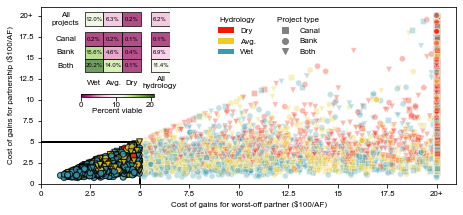

In [13]:
import matplotlib.path as mpath
import matplotlib.patches as mpatches

### now plot
fig,ax = plt.subplots(1,1,figsize=(7.45,3.25))

x = results[varnames[col]] * 0.01
c = results['c_hydro']
m = results['m_project']

x_base = 5

if maximizing:
    satisfice = np.logical_and(x <= x_base, y >= y_base)
else:
    satisfice = np.logical_and(x <= x_base, y <= y_base)
    
## trick for separate markers from https://stackoverflow.com/questions/52303660/iterating-markers-in-plots/52303895#52303895
def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

mscatter(x.loc[np.logical_not(satisfice)], y.loc[np.logical_not(satisfice)], ax=ax, c=c.loc[np.logical_not(satisfice)], 
         m=m.loc[np.logical_not(satisfice)], alpha=0.3, edgecolor='w', zorder=2)
mscatter(x.loc[satisfice], y.loc[satisfice], ax=ax, c=c.loc[satisfice], m=m.loc[satisfice], alpha=0.8, edgecolor='k', zorder=2)

ylim = ax.get_ylim()
xlim = ax.get_xlim()


# ax.set_xlim([xlim[0], xlim[1] + (xlim[1] - xlim[0]) * 0.1])
ax.set_xlim([0,21])
ax.set_xticks(np.arange(0,21,2.5))
ax.set_xticklabels(['0','2.5','5','7.5','10','12.5','15','17.5','20+'])
if figname == 'wpcost_pcost':
    ax.set_ylim([0,21])
    ax.set_yticks(np.arange(0,21,2.5))
    ax.set_yticklabels(['0','2.5','5','7.5','10','12.5','15','17.5','20+'])
elif figname == 'wpcost_pcwg':
    ax.set_ylim(ylim)
elif figname in ['wpcost_pddg']:
    ax.set_ylim([-300,175])
elif figname in ['wpcost_npcwg']:
    ax.set_ylim([-300,175])
elif figname == 'wpcost_pnum':
    ax.set_ylim([-30,22])
else:
    ax.set_ylim(ylim)    

    
if maximizing:
    ax.plot([x_base, x_base], [y_base, ax.get_ylim()[1]],lw=2,c='k', zorder=1)
else:
    ax.plot([x_base, x_base], [ax.get_ylim()[0], y_base],lw=2,c='k',zorder=1)
ax.plot([ax.get_xlim()[0], x_base], [y_base, y_base],lw=2, c='k', zorder=1) 
ax.set_xlabel('Cost of gains for worst-off partner ($100/AF)')
ax.set_ylabel(ylabel)



### inset with satisficing color table
axins1 = ax.inset_axes(inset_lims_1)
axins1.patch.set_alpha(0)

def get_satisfice_perc(is_subset):
        if maximizing:
            satisfice = np.logical_and(x.loc[is_subset] <= x_base, y.loc[is_subset] >= y_base)
        else:
            satisfice = np.logical_and(x.loc[is_subset] <= x_base, y.loc[is_subset] <= y_base)
        return satisfice.mean()*100
    
percs = []
colors = []
pos = []
for pi,p in enumerate([projects[i] for i in [2,1,0]]):
    for hi,h in enumerate([hydros[i] for i in [2,1,0]]):
        percs.append(get_satisfice_perc(np.logical_and(results['hydro'] == h, results['project'] == p)))
    percs.append(get_satisfice_perc(results['project'] == p))
for hi,h in enumerate([hydros[i] for i in [2,1,0]]):
    percs.append(get_satisfice_perc(results['hydro'] == h))
percs.append(get_satisfice_perc(np.logical_or(results['project'] == p, results['project'] != p)))

### now plot patches with percentages
offset = 0.5
cmap_satisfice = cm.get_cmap('PiYG')
rownames = ['Both', 'Bank', 'Canal','All\nprojects']
colnames = ['Wet', 'Avg.', 'Dry', 'All\nhydrology']

def get_color_satisfice(cmap, sat_perc, max_sat, min_sat):
    sat_norm = (sat_perc - min_sat) / (max_sat - min_sat)
    return cmap(sat_norm)

for r in range(4):
    if r == 3:
        row_offset = offset
    else:
        row_offset = 0
    for c in range(4):
        if c == 3:
            col_offset = offset
        else:
            col_offset = 0
        xy = np.zeros((5,2))
        xy[0,] = (row_offset + r, col_offset + c)
        xy[1,] = (row_offset + r, col_offset + c+1)
        xy[2,] = (row_offset + r+1, col_offset + c+1)
        xy[3,] = (row_offset + r+1, col_offset + c)
        xy[4,] = (row_offset + r, col_offset + c)

        path = mpath.Path(xy)
        color = get_color_satisfice(cmap_satisfice, percs[r + c*4], 21, 0)
        patch = mpatches.PathPatch(path, facecolor=color, edgecolor='k', alpha=0.7)
        axins1.add_patch(patch)
        axins1.annotate(str(round(percs[r + c*4],1)) + '%', (xy[:-1,0].mean(), xy[:-1,1].mean()), va='center', ha='center', fontsize=6)
        
        if r == 0:
            axins1.annotate(colnames[c], (c+0.5 + col_offset, -0.8), va='center', ha='center', ma='center', zorder=2)
    
    axins1.annotate(rownames[r], (-1, r+0.5 + row_offset), va='center', ha='center', ma='center', zorder=2)


axins1.set_xlim([-1., 4.5])
axins1.set_ylim([-2.7, 4.5])

cb = plt.colorbar(mappable = cm.ScalarMappable(cmap = cmap_satisfice, norm = Normalize(vmin=0, vmax=21)), 
                     ax=axins1, shrink=0.7, orientation='horizontal')
cb.ax.tick_params(pad=1)
cb.set_label('Percent viable', labelpad=0)


axins1.set_xticks([])
axins1.set_yticks([])
for spine in ['top','right','left','bottom']:
    axins1.spines[spine].set_visible(False)

leg_hydro = [Patch(facecolor=cdict_hydro['dry'], label='Dry'),
             Patch(facecolor=cdict_hydro['median'], label='Avg.'),
             Patch(facecolor=cdict_hydro['wet'], label='Wet')]
leg1 = axins1.legend(handles=leg_hydro, loc='center', bbox_to_anchor=leg_hydro_anchor, title='Hydrology', frameon=False)
leg1.get_title().set_ma('center')

leg_proj = [Line2D([0],[0], color='0.5', lw=0, marker=mdict_project['FKC'], label='Canal'),
            Line2D([0],[0], color='0.5', lw=0, marker=mdict_project['CFWB'], label='Bank'),
            Line2D([0],[0], color='0.5', lw=0, marker=mdict_project['FKC_CFWB'], label='Both'),]
leg1 = ax.legend(handles=leg_proj, loc='center', bbox_to_anchor=leg_proj_anchor, title='Project type', frameon=False)
leg1.get_title().set_ma('center')

plt.savefig('figures/' + 'satisfice_' + figname + '.png', bbox_inches='tight', dpi=300)

In [267]:
np.mean(np.logical_and(x > x_base, y <= y_base))

0.5312523143005258

In [154]:
# ### now plot
# fig,ax = plt.subplots(1,1,figsize=(7.45,3.25))

# x = results[varnames[col]] * 0.01
# c = results['c_hydro']
# m = results['m_project']

# x_base = 5

# if maximizing:
#     satisfice = np.logical_and(x <= x_base, y >= y_base)
# else:
#     satisfice = np.logical_and(x <= x_base, y <= y_base)
    
# ## trick for separate markers from https://stackoverflow.com/questions/52303660/iterating-markers-in-plots/52303895#52303895
# def mscatter(x,y,ax=None, m=None, **kw):
#     import matplotlib.markers as mmarkers
#     if not ax: ax=plt.gca()
#     sc = ax.scatter(x,y,**kw)
#     if (m is not None) and (len(m)==len(x)):
#         paths = []
#         for marker in m:
#             if isinstance(marker, mmarkers.MarkerStyle):
#                 marker_obj = marker
#             else:
#                 marker_obj = mmarkers.MarkerStyle(marker)
#             path = marker_obj.get_path().transformed(
#                         marker_obj.get_transform())
#             paths.append(path)
#         sc.set_paths(paths)
#     return sc

# mscatter(x.loc[np.logical_not(satisfice)], y.loc[np.logical_not(satisfice)], ax=ax, c=c.loc[np.logical_not(satisfice)], 
#          m=m.loc[np.logical_not(satisfice)], alpha=0.3, edgecolor='w', zorder=2)
# mscatter(x.loc[satisfice], y.loc[satisfice], ax=ax, c=c.loc[satisfice], m=m.loc[satisfice], alpha=0.8, edgecolor='k', zorder=2)

# ylim = ax.get_ylim()
# xlim = ax.get_xlim()



# # ax.set_xlim([xlim[0], xlim[1] + (xlim[1] - xlim[0]) * 0.1])
# ax.set_xlim([0,21])
# ax.set_xticks(np.arange(0,21,2.5))
# ax.set_xticklabels(['0','2.5','5','7.5','10','12.5','15','17.5','20+'])
# if figname == 'wpcost_pcost':
#     ax.set_ylim([0,21])
#     ax.set_yticks(np.arange(0,21,2.5))
#     ax.set_yticklabels(['0','2.5','5','7.5','10','12.5','15','17.5','20+'])
# elif figname == 'wpcost_pcwg':
#     ax.set_ylim(ylim)
# elif figname in ['wpcost_pddg']:
#     ax.set_ylim([-300,175])
# elif figname in ['wpcost_npcwg']:
#     ax.set_ylim([-300,175])
# elif figname == 'wpcost_pnum':
#     ax.set_ylim([-30,22])
# else:
#     ax.set_ylim(ylim)    

    
# if maximizing:
#     ax.plot([x_base, x_base], [y_base, ax.get_ylim()[1]],lw=2,c='k', zorder=1)
# else:
#     ax.plot([x_base, x_base], [ax.get_ylim()[0], y_base],lw=2,c='k',zorder=1)
# ax.plot([ax.get_xlim()[0], x_base], [y_base, y_base],lw=2, c='k', zorder=1) 
# ax.set_xlabel('Cost of gains for worst-off partner ($100/AF)')
# ax.set_ylabel(ylabel)



# ### inset with satisficing fraction bar chart
# axins1 = ax.inset_axes(inset_lims_1)
# axins1.patch.set_alpha(0)
# percs = []
# colors = []
# pos = []
# for hi,h in enumerate(hydros):
#     for pi,p in enumerate(projects):
#         is_hydroproj = np.logical_and(results['hydro'] == h, results['project'] == p)
#         if maximizing:
#             satisfice = np.logical_and(x.loc[is_hydroproj] <= x_base, y.loc[is_hydroproj] >= y_base)
#         else:
#             satisfice = np.logical_and(x.loc[is_hydroproj] <= x_base, y.loc[is_hydroproj] <= y_base)
#         percs.append(satisfice.mean()*100)
#         colors.append(cdict_hydro[h])
#         pos.append(10 - pi*4 - hi)
# count = 0
# for hi,h in enumerate(hydros):
#     for pi,p in enumerate(projects):
#         axins1.annotate(f'{round(percs[count],1)}%', xy=(percs[count] + max(percs)/40, pos[count]+0.5), color=colors[count], 
#                         va='center', ha='left', weight='bold')
#         count += 1
# axins1.barh(width=percs, y=pos, color=colors, align='edge', height=1)    
# # axins1.set_xlim([0,0.22])
# axins1.set_xlabel('Percent viable')
# axins1.set_yticks([9.5, 5.5, 1.5])
# axins1.set_yticklabels(['Canal','Bank','Both'], rotation=90, ha='center', va='center')
# axins1.tick_params(axis='y', pad=10)
# for spine in ['top','right']:
#     axins1.spines[spine].set_visible(False)

# leg_hydro = [Patch(facecolor=cdict_hydro['dry'], label='Dry'),
#              Patch(facecolor=cdict_hydro['median'], label='Avg.'),
#              Patch(facecolor=cdict_hydro['wet'], label='Wet')]
# leg1 = axins1.legend(handles=leg_hydro, loc='center', bbox_to_anchor=leg_hydro_anchor, title='Hydrology', frameon=False)
# leg1.get_title().set_ma('center')

# leg_proj = [Line2D([0],[0], color='0.5', lw=0, marker=mdict_project['FKC'], label='Canal'),
#             Line2D([0],[0], color='0.5', lw=0, marker=mdict_project['CFWB'], label='Bank'),
#             Line2D([0],[0], color='0.5', lw=0, marker=mdict_project['FKC_CFWB'], label='Both'),]
# leg1 = ax.legend(handles=leg_proj, loc='center', bbox_to_anchor=leg_proj_anchor, title='Project type', frameon=False)
# leg1.get_title().set_ma('center')

# plt.savefig('figures/' + 'satisfice_' + figname + '.png', bbox_inches='tight', dpi=300)

In [95]:
projects

['FKC', 'CFWB', 'FKC_CFWB']

In [ ]:
# ### draw pi chart with patch
# import matplotlib.path as mpath
# import matplotlib.patches as mpatches

# def make_wedge(theta0, theta1, rad):
#     xy = np.zeros([100,2])
#     t = np.arange(np.pi * theta0 / 180, np.pi * theta1 / 180+0.001, 0.001)
#     xy = np.zeros([len(t) + 2, 2])
#     xy[1:(len(t)+1), 0] = rad * np.cos(t)
#     xy[1:(len(t)+1), 1] = rad * np.sin(t)
#     return xy

In [ ]:
# ### now plot
# fig,ax = plt.subplots(1,1,figsize=(10,6), gridspec_kw={'hspace':0.1, 'wspace':0.1})

# x = results[varnames[col]]
# c = results['c_hydro']
# m = results['m_project']

# x_base = 5

# if maximizing:
#     satisfice = np.logical_and(x <= x_base, y >= y_base)
# else:
#     satisfice = np.logical_and(x <= x_base, y <= y_base)
    
# ## trick for separate markers from https://stackoverflow.com/questions/52303660/iterating-markers-in-plots/52303895#52303895
# def mscatter(x,y,ax=None, m=None, **kw):
#     import matplotlib.markers as mmarkers
#     if not ax: ax=plt.gca()
#     sc = ax.scatter(x,y,**kw)
#     if (m is not None) and (len(m)==len(x)):
#         paths = []
#         for marker in m:
#             if isinstance(marker, mmarkers.MarkerStyle):
#                 marker_obj = marker
#             else:
#                 marker_obj = mmarkers.MarkerStyle(marker)
#             path = marker_obj.get_path().transformed(
#                         marker_obj.get_transform())
#             paths.append(path)
#         sc.set_paths(paths)
#     return sc

# mscatter(x.loc[np.logical_not(satisfice)], y.loc[np.logical_not(satisfice)], ax=ax, c=c.loc[np.logical_not(satisfice)], 
#          m=m.loc[np.logical_not(satisfice)], alpha=0.3, edgecolor='w')
# mscatter(x.loc[satisfice], y.loc[satisfice], ax=ax, c=c.loc[satisfice], m=m.loc[satisfice], alpha=0.8, edgecolor='k')

# ylim = ax.get_ylim()
# xlim = ax.get_xlim()

# if maximizing:
#     ax.plot([x_base, x_base], [y_base, ylim[1]],lw=2,c='k')
# else:
#     ax.plot([x_base, x_base], [ylim[0], y_base],lw=2,c='k')
    
# ax.plot([xlim[0], x_base], [y_base, y_base],lw=2, c='k')

# # ax.set_xlim([xlim[0], xlim[1] + (xlim[1] - xlim[0]) * 0.1])
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# ax.set_xlabel('WP-Cost ($100/AF)')
# ax.set_ylabel(ylabel)



# ### pi chart with box as sub-slices
# axins1 = ax.inset_axes(inset_lims_1)
# axins1.set_aspect('equal', adjustable='box')
# axins1.patch.set_alpha(0)

# ### hydro fractions first
# hydro_frac = [(results['hydro'].loc[satisfice] == 'dry').sum() / results['hydro'].shape[0], 
#              (results['hydro'].loc[satisfice] == 'median').sum() / results['hydro'].shape[0], 
#              (results['hydro'].loc[satisfice] == 'wet').sum() / results['hydro'].shape[0], 
#              (results['hydro'].loc[np.logical_not(satisfice)] == 'dry').sum() / results['hydro'].shape[0], 
#              (results['hydro'].loc[np.logical_not(satisfice)] == 'median').sum() / results['hydro'].shape[0],
#              (results['hydro'].loc[np.logical_not(satisfice)] == 'wet').sum() / results['hydro'].shape[0]]
# hydro_deg = (-sum(hydro_frac[:3])/2 + np.cumsum(hydro_frac)) * 360 
# for i in range(6):
#     h = hydros[i % 3]
#     c = cdict_hydro[h]
#     if i<3:
#         radius = 2
#         edgecolor = 'k'
#         z = 2
#     else:
#         radius = 1
#         edgecolor = c
#         z = 1
#     if i == 0:
#         xy = make_wedge(hydro_deg[-1] - 360, hydro_deg[i], radius)
#     else: 
#         xy = make_wedge(hydro_deg[i-1], hydro_deg[i], radius)
#     path = mpath.Path(xy)
#     patch = mpatches.PathPatch(path, facecolor=c, edgecolor=edgecolor, zorder=z)
#     axins1.add_patch(patch)
    
# ### now project fractions
# proj_frac = [(results['project'].loc[satisfice] == 'FKC_CFWB').sum() / results['project'].shape[0], 
#              (results['project'].loc[satisfice] == 'CFWB').sum() / results['project'].shape[0], 
#              (results['project'].loc[satisfice] == 'FKC').sum() / results['project'].shape[0],
#              (results['project'].loc[np.logical_not(satisfice)] == 'FKC_CFWB').sum() / results['project'].shape[0], 
#              (results['project'].loc[np.logical_not(satisfice)] == 'CFWB').sum() / results['project'].shape[0], 
#              (results['project'].loc[np.logical_not(satisfice)] == 'FKC').sum() / results['project'].shape[0]]
# proj_deg = (-sum(proj_frac[:3])/2 + np.cumsum(proj_frac)) * 360 + 180

# for i in range(6):
#     p = ['FKC_CFWB','CFWB','FKC'][i % 3]
#     c = cdict_project[p]
#     if i<3:
#         radius = 2
#         edgecolor = 'k'
#         z = 2
#     else:
#         radius = 1
#         edgecolor = c
#         z = 1
#     if i == 0:
#         xy = make_wedge(proj_deg[-1] - 360, proj_deg[i], radius)
#     else: 
#         xy = make_wedge(proj_deg[i-1], proj_deg[i], radius)
#     xy[:,0] += 4.3
#     path = mpath.Path(xy)
#     patch = mpatches.PathPatch(path, facecolor=c, edgecolor=edgecolor, zorder=z)
#     axins1.add_patch(patch)
    
# ### touchup & annotations
# axins1.annotate('Dry', xy=[0.2,0.6], ha='center', va='center')
# axins1.annotate('Avg', xy=[-0.5,0], ha='center', va='center')
# axins1.annotate('Wet', xy=[0.2,-0.6], ha='center', va='center')
# axins1.annotate('Canal', xy=[4.1,0.7], ha='center', va='center')
# axins1.annotate('Bank', xy=[4.85,0.15], ha='center', va='center')
# axins1.annotate('Both', xy=[4.1,-0.4], ha='center', va='center')
# axins1.scatter([4.1], [0.4], marker=mdict_project['FKC'], zorder=4, color='k')
# axins1.scatter([4.85], [-0.15], marker=mdict_project['CFWB'], zorder=4, color='k')
# axins1.scatter([4.1], [-0.7], marker=mdict_project['FKC_CFWB'], zorder=4, color='k')

# axins1.annotate(f'Satisficing\n{round(sum(proj_frac[:3]*100), 2)}%', xy=[2.15,1.1], ha='center', va='center')
# axins1.arrow(arrow_coords[0][0], arrow_coords[0][1], arrow_coords[0][2], arrow_coords[0][3], zorder=5,head_width=0.1,color='k')
# axins1.arrow(arrow_coords[1][0], arrow_coords[1][1], arrow_coords[1][2], arrow_coords[1][3], zorder=5,head_width=0.1,color='k')
# axins1.annotate(f'Not\nsatisficing\n{round(sum(proj_frac[3:]*100), 2)}%', xy=[2.15,-1.1], ha='center', va='center')
# axins1.arrow(arrow_coords[2][0], arrow_coords[2][1], arrow_coords[2][2], arrow_coords[2][3], zorder=5,head_width=0.1,color='k')
# axins1.arrow(arrow_coords[3][0], arrow_coords[3][1], arrow_coords[3][2], arrow_coords[3][3], zorder=5,head_width=0.1,color='k')

# axins1.set_xlim([-1.3,5.6])
# axins1.set_ylim([-1.3,1.1])
# axins1.set_xticks([])
# axins1.set_yticks([])
# for spine in ['top','bottom','left','right']:
#     axins1.spines[spine].set_visible(False)

# plt.savefig('figures/' + 'satisfice_' + figname + '.png', bbox_inches='tight', dpi=300)

### distribution of objectives for partnership

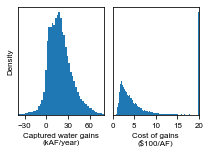

In [10]:
### plot overall partnership distributions
# print(results.columns[:20])
varnames = ['total_partner_avg_gain', 'total_partner_w5yr_gain', 'total_other_avg_gain',
        'avg_price_gain_dolAF', 'worst_price_avg_gain', 'ginicoef', 'num_partners','initial_recharge', 'tot_storage',
       'recovery']

fig,axs = plt.subplots(1,2,figsize=(3.25,2), gridspec_kw={'hspace':0.1, 'wspace':0.1}) 
ax = axs[0]
_ = ax.hist(results[varnames[0]], bins=100)
ax.set_xlim([-40,80])
ax.set_xticks([-30,0,30, 60])
ax.set_xlabel('Captured water gains\n(kAF/year)')
ax.set_ylabel('Density')
_ = ax.set_yticks([])

ax = axs[1]
_ = ax.hist(results[varnames[3]] / 100, bins=100)
ax.set_xlim([0,20])
ax.set_xticks([0,5,10,15,20])
ax.yaxis.set_ticks_position('right')
ax.set_xlabel('Cost of gains\n($100/AF)')
_ = ax.set_yticks([])

figname = 'partnership_hists'
plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

### parallel coord plot with solns meeting all criteria

In [18]:
### which set beats default on all four measures, plus WP_cost <= $500?
# satisfice = np.logical_and(np.logical_and(np.logical_and(np.logical_and(results['worst_price_avg_gain'] <= 5,
#                                                                          results['total_partner_avg_gain'] >= results['total_partner_avg_gain'].iloc[-2]),
#                                                           results['total_partner_w5yr_gain'] >= results['total_partner_w5yr_gain'].iloc[-2]),
#                                            results['total_other_avg_gain'] >= results['total_other_avg_gain'].iloc[-2]),
#                             results['avg_price_gain_dolAF'] <= results['avg_price_gain_dolAF'].iloc[-2])

### what if we relax avg price constraint, since not really "real" in default
# satisfice = np.logical_and(np.logical_and(np.logical_and(results['worst_price_avg_gain'] <= 5,
#                                                           results['total_partner_avg_gain'] >= results['total_partner_avg_gain'].iloc[-2]),
#                                            results['total_partner_w5yr_gain'] >= results['total_partner_w5yr_gain'].iloc[-2]),
#                             results['total_other_avg_gain'] >= results['total_other_avg_gain'].iloc[-2])

### what about more arbitrary but reasonable constraints?
satisfice = np.logical_and(np.logical_and(np.logical_and(np.logical_and(np.logical_and(results['num_partners'] >=0,
                                                                                        results['worst_price_avg_gain']/100 <= 5),
                                                                         results['total_partner_avg_gain'] >= 37.6), #40),
                                                          results['total_partner_w5yr_gain'] >= 6.9), #10),
                                           results['total_other_avg_gain'] >= -2.0), #0),
                            results['avg_price_gain_dolAF']/100 <= 5)

# ### what about more arbitrary but reasonable constraints, and also include default case
# satisfice = np.logical_or(np.logical_and(np.logical_and(np.logical_and(np.logical_and(results['worst_price_avg_gain'] <= 5,
#                                                                                      results['total_partner_avg_gain'] >= 30),
#                                                                       results['total_partner_w5yr_gain'] >= 15),
#                                                        results['total_other_avg_gain'] >= 0),
#                                         results['avg_price_gain_dolAF'] <= 2.5),
#                           np.logical_and(results['samp'] == 'friantHistorical',
#                                          results['hydro'] == 'median'))

cols = ['num_partners', 'total_partner_avg_gain', 'total_partner_w5yr_gain', 'total_other_avg_gain', 'avg_price_gain_dolAF', 'worst_price_avg_gain', 'project', 'hydro']
ressat = results.loc[satisfice, cols]
print(ressat.sort_values('total_partner_w5yr_gain').iloc[-20:,])

(98, 8)
       num_partners  total_partner_avg_gain  total_partner_w5yr_gain  \
26539             5               51.561736                19.927577   
11411             6               47.391414                20.784875   
18187             4               44.628383                21.018439   
16550             6               41.825054                21.498319   
7307             12               38.096905                21.589491   
8071              3               59.418360                22.625533   
12256             8               47.004238                22.956183   
15928             7               49.390377                23.389252   
14893             7               45.010003                23.396876   
15406             6               46.646409                25.214406   
13525             5               51.048057                25.351435   
18494             5               68.437428                25.366531   
26684             9               50.171878             

In [19]:
tops = ressat.iloc[:, :-2].min(axis=0)
bottoms = ressat.iloc[:, :-2].max(axis=0)
switch = bottoms[-2:].copy()
bottoms[-2:] = tops[-2:]
tops[-2:] = switch
ressat.iloc[:, :4] = (ressat.iloc[:, :4].max(axis=0) - ressat.iloc[:, :4]) / (ressat.iloc[:, :4].max(axis=0) - ressat.iloc[:, :4].min(axis=0))
ressat.iloc[:, 4:6] = (ressat.iloc[:, 4:6] - ressat.iloc[:, 4:6].min(axis=0)) / (ressat.iloc[:, 4:6].max(axis=0) - ressat.iloc[:, 4:6].min(axis=0))

In [21]:
print(ressat.shape)
print(sum(ressat['hydro'] == 'median'))
print(sum(ressat['hydro'] == 'wet'))

(98, 8)
40
58


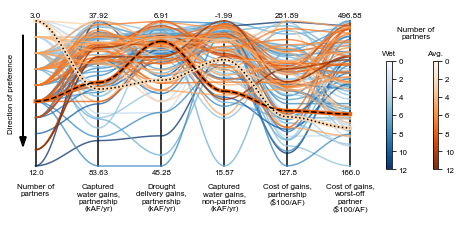

In [137]:
### parallel coord plot
fig,ax = plt.subplots(1,1,figsize=(8.9,4), gridspec_kw={'hspace':0.1, 'wspace':0.1})

### pick particular soln to highlight
idxs = [14983,8071]#[13525,5560] #14983 #8071

colnorm = 0
lsdict_hydro = {'wet': '-', 'median': '--', 'dry': ':'}
cmdict_hydro = {'wet': 'Blues_r', 'median': 'Oranges_r', 'dry': 'Purples_r'}
zdict_hydro = {'wet': 2, 'median': 3}
### plot all satisficing solns
for i in range(ressat.shape[0]):
    if ressat.index[i] != idx:
        for j in range(len(cols) - 3):
#             numnorm = (ressat.iloc[i,colnorm] - ressat.iloc[:,colnorm].min()) / \
#                         (ressat.iloc[:,colnorm].max() - ressat.iloc[:,colnorm].min()) * 0.58 
            numnorm = ressat.iloc[i,colnorm]  / ressat.iloc[:,colnorm].max() *0.75
            c = cm.get_cmap(cmdict_hydro[ressat.iloc[i,:]['hydro']])(numnorm)
            ### add sin shape to help distinguish lines
            y1 = ressat.iloc[i, j]
            y2 = ressat.iloc[i, j+1]
            t = np.arange(-np.pi/2, np.pi/2+0.001, 0.01)
            y = y1 + (np.sin(t) + 1) / 2 * (y2 - y1)
            x = j + t / np.pi + 1/2
            ax.plot(x, y, c=c, alpha=0.75, zorder=zdict_hydro[ressat.iloc[i,:]['hydro']], lw=1.5)

### highlight chosen solns
lss = ['--',':']
for i, idx in enumerate(idxs):
#     numnorm = (ressat.iloc[:,colnorm].loc[idx] - ressat.iloc[:,colnorm].min()) / \
#                     (ressat.iloc[:,colnorm].max() - ressat.iloc[:,colnorm].min()) * 0.58
    numnorm = ressat.iloc[:,colnorm].loc[idx] / ressat.iloc[:,colnorm].max() *0.8
    c = cm.get_cmap(cmdict_hydro[ressat.loc[idx,'hydro']])(numnorm)

    for j in range(len(cols) - 3): 
        ### add sin shape to help distinguish lines
        y1 = ressat.iloc[:, j].loc[idx]
        y2 = ressat.iloc[:, j+1].loc[idx]
        t = np.arange(-np.pi/2, np.pi/2+0.001, 0.01)
        y = y1 + (np.sin(t) + 1) / 2 * (y2 - y1)
        x = j + t / np.pi + 1/2
        ax.plot(x, y, c=c, alpha=1, zorder=4, lw=4)
        ax.plot(x, y, c='k', alpha=1, zorder=5, lw=1.5, ls=lss[i])
    

### add top/bottom ranges
for j in range(len(cols)-2):
    ax.annotate(str(round(tops[j],2)), [j, 1.02], ha='center', va='bottom', zorder=5)
    ax.annotate(str(round(bottoms[j],2)), [j, -0.02], ha='center', va='top', zorder=5)    
    ax.plot([j,j], [0,1], c='k', zorder=1)
ax.set_xticks([])
ax.set_yticks([])
for spine in ['top','bottom','left','right']:
    ax.spines[spine].set_visible(False)
ax.arrow(-0.2,0.9,0,-0.7, head_width=0.1, head_length=0.065, color='k', lw=1.5)
ax.annotate('Direction of preference', xy=(-0.4,0.5), ha='center', va='center', rotation=90)

ax.set_xlim(-0.4, 5.5)
ax.set_ylim(-0.4,1.1)
labels = ['Number of\npartners','Captured\nwater gains,\npartnership\n(kAF/yr)','Drought\ndelivery gains,\npartnership\n(kAF/yr)','Captured\nwater gains,\nnon-partners\n(kAF/yr)','Cost of gains,\npartnership\n($100/AF)','Cost of gains,\nworst-off\npartner\n($100/AF)']
for i,l in enumerate(labels):
    ax.annotate(l, xy=(i,-0.12), ha='center', va='top')

## legend
cb2 = fig.colorbar(cm.ScalarMappable(cmap=cm.get_cmap('Oranges_r'), 
                   norm=Normalize(vmin=0, vmax=bottoms[colnorm])), ax=ax, fraction=0.15, shrink=0.5, pad=-0.04, alpha=0.7)
cb2.ax.set_title('Avg.', fontsize=8)
cb2.set_ticks(np.arange(0,13,2))
cb2.set_ticklabels(np.arange(12,-1,-2))

cb1 = fig.colorbar(cm.ScalarMappable(cmap=cm.get_cmap('Blues_r'), 
                    norm=Normalize(vmin=0, vmax=bottoms[colnorm])), ax=ax, fraction=0.15, shrink=0.5, pad=0.01, alpha=0.7)
cb1.ax.set_title('Wet', fontsize=8)
cb1.set_ticks(np.arange(0,13,2))
cb1.set_ticklabels(np.arange(12,-1,-2))
ax.annotate('Number of\npartners', [5.75,0.88], ma='center', annotation_clip=False)

figname = 'parallel_' + str(idxs)
plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [ ]:
# results.loc[14983, share_keys]
results.loc[8071].iloc[:20]
# results.iloc[-2,-80:-60]

### plot objectives for each district

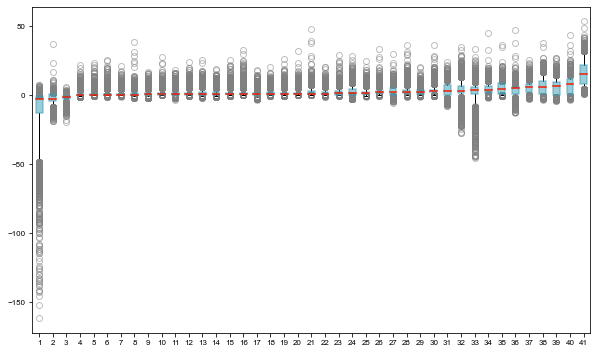

In [11]:
### CWG each district in scenarios for which they are participants
districts_samp = districts.copy()
for d in districts:
    try:
        if results[d + '_share'].sum() == 0.0:
            districts_samp.remove(d)
    except:
        districts_samp.remove(d)

fig,ax = plt.subplots(1,1,figsize=(10,6), gridspec_kw={'hspace':0.1, 'wspace':0.1}) 
cwgs = []
for j,d in enumerate(districts_samp):
    cwgs.append(results.loc[results[d+'_share'] > 0, d+'_exp_gain'])
    
medians = [np.median(a) for a in cwgs]
sort = np.argsort(medians)
districts_samp = [districts_samp[s] for s in sort]
cwgs = [cwgs[s] for s in sort]
# nresort = sum([m == 20.0 for m in medians])
# q25s = [np.quantile(a, 0.25) for a in prices[-nresort:]]
# sort = np.argsort(q25s)
# districts_samp[-nresort:] = [districts_samp[-5:][s] for s in sort]
# prices[-5:] = [prices[-nresort:][s] for s in sort]

bplot = ax.boxplot(cwgs, whis=[5,95], flierprops={'markeredgecolor':'0.5', 'alpha':0.5}, boxprops={'color':cdict_hydro['wet'], 'lw':1.5},
                   medianprops={'color':cdict_hydro['dry'], 'lw':1.5}, patch_artist=True)
for patch in bplot['boxes']:
    patch.set_facecolor(cdict_hydro['wet'])
    patch.set_alpha(0.5)

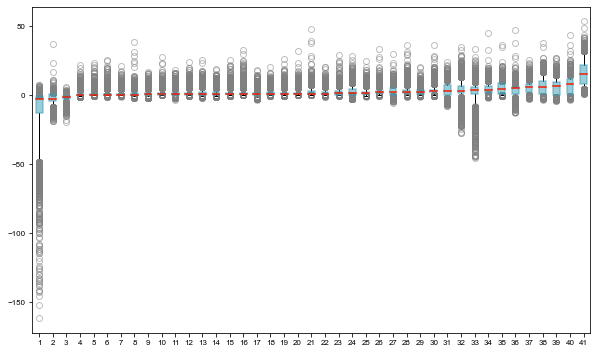

In [12]:
### DDG each district in scenarios for which they are participants
districts_samp = districts.copy()
for d in districts:
    try:
        if results[d + '_share'].sum() == 0.0:
            districts_samp.remove(d)
    except:
        districts_samp.remove(d)

fig,ax = plt.subplots(1,1,figsize=(10,6), gridspec_kw={'hspace':0.1, 'wspace':0.1}) 
ddgs = []
for j,d in enumerate(districts_samp):
    ddgs.append(results.loc[results[d+'_share'] > 0, d+'_exp_gain'])
    
medians = [np.median(a) for a in ddgs]
sort = np.argsort(medians)
districts_samp = [districts_samp[s] for s in sort]
ddgs = [ddgs[s] for s in sort]
# nresort = sum([m == 20.0 for m in medians])
# q25s = [np.quantile(a, 0.25) for a in prices[-nresort:]]
# sort = np.argsort(q25s)
# districts_samp[-nresort:] = [districts_samp[-5:][s] for s in sort]
# prices[-5:] = [prices[-nresort:][s] for s in sort]

bplot = ax.boxplot(ddgs, whis=[5,95], flierprops={'markeredgecolor':'0.5', 'alpha':0.5}, boxprops={'color':cdict_hydro['wet'], 'lw':1.5},
                   medianprops={'color':cdict_hydro['dry'], 'lw':1.5}, patch_artist=True)
for patch in bplot['boxes']:
    patch.set_facecolor(cdict_hydro['wet'])
    patch.set_alpha(0.5)

In [13]:
breaks = [0, 13, 27, 41]
# example_districts = ['ARV','PRT','LHL']

[0.47318646367106326, 1.3989791892995647, 1.6566993532618959, 1.6832314833299693, 1.6998350990858495, 1.937493205401133, 1.9928633798695372, 2.093741544652542, 2.215266469068454, 2.503288896812422, 2.5719624625631803, 2.7660827696824937, 2.8512857662127566, 3.54131739585512, 3.6435279430680616, 3.7870383336891535, 4.010323072220873, 4.056561928982161, 4.482775329947183, 4.511450531714907, 4.606862309424237, 5.1967129898048405, 5.623924992933453, 5.901895228007167, 6.330969838816452, 6.837088672096115, 7.104497219822296, 8.169697217323801, 8.35567325358039, 8.494434126883291, 9.606417447935748, 10.779925520435961, 11.014770218368128, 12.902463836046, 16.34025936133883, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0]
['PIX', 'LWT', 'ARV', 'KWD', 'OKW', 'ID4', 'COB', 'DLE', 'NKN', 'RRB', 'TUL', 'SSJ', 'WRM', 'COF', 'SFW', 'KND', 'TBA', 'KRT', 'PRT', 'OTL', 'OFK', 'SOC', 'LDS', 'OXV', 'LND', 'SMI', 'SAU', 'EXE', 'DLR', 'TPD', 'HML', 'SOB', 'BDM', 'CCA', 'LHL', 'CWO', 'TJC', 'KCWA', 'BVA', 'BLR', 'FRS'

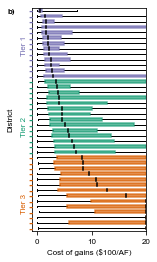

In [14]:
### price paid by each district in scenarios for which they are participants
# subresults = results.loc[np.logical_and(results['hydro'] == 'median', results['project'] == 'FKC'),:]


districts_samp = districts.copy()
for d in districts:
    try:
        if results[d + '_share'].sum() == 0.0:
            districts_samp.remove(d)
    except:
        districts_samp.remove(d)

fig,ax = plt.subplots(1,1,figsize=(2.05,4.1), gridspec_kw={'hspace':0.1, 'wspace':0.1}) 
prices = []
for j,d in enumerate(districts_samp):
    prices.append(results.loc[results[d+'_share'] > 0, d+'_avg_price'] / 100)
    
medians = [np.median(a) for a in prices]
sort = np.argsort(medians)
districts_samp = [districts_samp[s] for s in sort]
prices = [prices[s] for s in sort]
# nresort = sum([m == 20.0 for m in medians])
# q25s = [np.quantile(a, 0.25) for a in prices[-nresort:]]
# sort = np.argsort(q25s)
# districts_samp[-nresort:] = [districts_samp[-nresort:][s] for s in sort]
# prices[-nresort:] = [prices[-nresort:][s] for s in sort]
# q25s = [np.quantile(a, 0.25) for a in prices]
# nresort = sum([q == 20.0 for q in q25s])
# q05s = [np.quantile(a, 0.05) for a in prices[-nresort:]]
# sort = np.argsort(q05s)
# districts_samp[-nresort:] = [districts_samp[-nresort:][s] for s in sort]
# prices[-nresort:] = [prices[-nresort:][s] for s in sort]
print([np.median(a) for a in prices])
print(districts_samp)

for i in range(3):
    c = pal_cb[i]

    idxs = list(range(breaks[i], breaks[i+1]))
    bplot = ax.boxplot([prices[idx] for idx in idxs], vert=False, 
                       positions=range(len(prices) - breaks[i], len(prices) - breaks[i+1], -1),
                       whis=[0,100], flierprops={'markeredgecolor':c, 'alpha':0., 'zorder':1}, 
                       boxprops={'color':c, 'lw':1.5, 'zorder':2},
                       medianprops={'color':'k', 'lw':1.5, 'zorder':3}, patch_artist=True)

    for patch in bplot['boxes']:
        patch.set_facecolor(c)
        patch.set_alpha(0.7)

    for idx in idxs:
        ax.annotate('-', xy=(-1.7, len(prices) - idx - 0.7), ma='center', xycoords='data', 
                    color=c, size=12, weight='bold', annotation_clip=False)
            
ax.set_xlabel('Cost of gains ($100/AF)')
ax.set_xlim([-1, 20])
ax.set_yticks([])
ax.set_ylabel('District', labelpad=18)
ax.annotate('Tier 1', xy=(-2.9, 33), rotation=90, ma='center', xycoords='data', color=pal_cb[0], annotation_clip=False)
ax.annotate('Tier 2', xy=(-2.9, 18), rotation=90, ma='center', xycoords='data', color=pal_cb[1], annotation_clip=False)
ax.annotate('Tier 3', xy=(-2.9, 4), rotation=90, ma='center', xycoords='data', color=pal_cb[2], annotation_clip=False)
ax.annotate('b)', xy=(-5.5,40.5), ma='center', xycoords='data', weight='bold', annotation_clip=False)

figname = 'boxplot_combined'
# plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

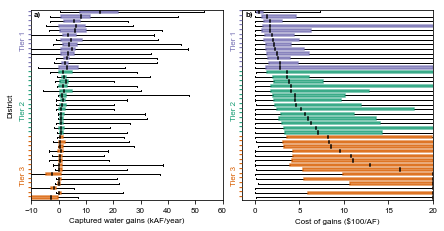

In [15]:
### gains for each district in scenarios for which they are participants

districts_samp = districts.copy()
for d in districts:
    try:
        if results[d + '_share'].sum() == 0.0:
            districts_samp.remove(d)
    except:
        districts_samp.remove(d)


### get gains & prices, sort based on prices
prices = []
for j,d in enumerate(districts_samp):
    prices.append(results.loc[results[d+'_share'] > 0, d+'_avg_price'] / 100)
    
medians = [np.median(a) for a in prices]
sort = np.argsort(medians)
districts_samp = [districts_samp[s] for s in sort]
prices = [prices[s] for s in sort]
# nresort = sum([m == 20.0 for m in medians])
# q25s = [np.quantile(a, 0.25) for a in prices[-nresort:]]
# sort = np.argsort(q25s)
# districts_samp[-nresort:] = [districts_samp[-nresort:][s] for s in sort]
# prices[-nresort:] = [prices[-nresort:][s] for s in sort]
# q25s = [np.quantile(a, 0.25) for a in prices]
# nresort = sum([q == 20.0 for q in q25s])
# q05s = [np.quantile(a, 0.05) for a in prices[-nresort:]]
# sort = np.argsort(q05s)
# districts_samp[-nresort:] = [districts_samp[-nresort:][s] for s in sort]
# prices[-nresort:] = [prices[-nresort:][s] for s in sort]
# print([np.median(a) for a in prices])
# print(districts_samp)

prices = []
gains = []
for j,d in enumerate(districts_samp):
    prices.append(results.loc[results[d+'_share'] > 0, d+'_avg_price'] / 100)
    gains.append(results.loc[results[d+'_share'] > 0, d+'_exp_gain'])

### plot gains
fig,axs = plt.subplots(1,2,figsize=(7.2,3.5), gridspec_kw={'hspace':0.1, 'wspace':0.1}) 
ax = axs[0]

for i in range(3):
    c = pal_cb[i]

    idxs = list(range(breaks[i], breaks[i+1]))
    bplot = ax.boxplot([gains[idx] for idx in idxs], vert=False, 
                       positions=range(len(gains) - breaks[i], len(gains) - breaks[i+1], -1),
                       whis=[0,100], flierprops={'markeredgecolor':c, 'alpha':0., 'zorder':1}, 
                       boxprops={'color':c, 'lw':1.5, 'zorder':2},
                       medianprops={'color':'k', 'lw':1.5, 'zorder':3}, patch_artist=True)

    for patch in bplot['boxes']:
        patch.set_facecolor(c)
        patch.set_alpha(0.7)

    for idx in idxs:
        ax.annotate('-', xy=(-11.3, len(gains) - idx - 0.4), ma='center', xycoords='data', 
                    color=c, size=10, weight='bold', annotation_clip=False)
            
# ax.axvline(0, c='0.5', zorder=1, lw=ax.spines['top'].get_linewidth())#, ls='--', dashes=(6,6))

# ax.set_xlim([-90,40])
ax.set_xlim([-10,60])
# ax.set_xscale('log')

ax.set_xlabel('Captured water gains (kAF/year)')
ax.set_yticks([])
ax.set_ylabel('District', labelpad=18)
ax.annotate('Tier 1', xy=(-14, 33), rotation=90, ma='center', xycoords='data', color=pal_cb[0], annotation_clip=False)
ax.annotate('Tier 2', xy=(-14, 18), rotation=90, ma='center', xycoords='data', color=pal_cb[1], annotation_clip=False)
ax.annotate('Tier 3', xy=(-14, 4), rotation=90, ma='center', xycoords='data', color=pal_cb[2], annotation_clip=False)
ax.annotate('a)', xy=(-9,40.2), ma='center', xycoords='data', weight='bold', annotation_clip=False)





### plot prices
ax = axs[1]

for i in range(3):
    c = pal_cb[i]

    idxs = list(range(breaks[i], breaks[i+1]))
    bplot = ax.boxplot([prices[idx] for idx in idxs], vert=False, 
                       positions=range(len(prices) - breaks[i], len(prices) - breaks[i+1], -1),
                       whis=[0,100], flierprops={'markeredgecolor':c, 'alpha':0., 'zorder':1}, 
                       boxprops={'color':c, 'lw':1.5, 'zorder':2},
                       medianprops={'color':'k', 'lw':1.5, 'zorder':3}, patch_artist=True)

    for patch in bplot['boxes']:
        patch.set_facecolor(c)
        patch.set_alpha(0.7)

    for idx in idxs:
        ax.annotate('-', xy=(-1.9, len(prices) - idx - 0.3), ma='center', xycoords='data', 
                    color=c, size=10, weight='bold', annotation_clip=False)
            
# ax.axvline(20, c='0.5', zorder=1, lw=ax.spines['top'].get_linewidth())#, ls='--', dashes=(6,6))
ax.set_xlim([-1.5,20])

ax.set_xlabel('Cost of gains ($100/AF)')
ax.set_yticks([])
# ax.set_ylabel('District', labelpad=18)
ax.annotate('Tier 1', xy=(-2.7, 33), rotation=90, ma='center', xycoords='data', color=pal_cb[0], annotation_clip=False)
ax.annotate('Tier 2', xy=(-2.7, 18), rotation=90, ma='center', xycoords='data', color=pal_cb[1], annotation_clip=False)
ax.annotate('Tier 3', xy=(-2.7, 4), rotation=90, ma='center', xycoords='data', color=pal_cb[2], annotation_clip=False)
ax.annotate('b)', xy=(-1.1,40.2), ma='center', xycoords='data', weight='bold', annotation_clip=False)

figname = 'boxplot_combined'
# plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

a) -137.94437372605614 96.23615261308196 17.221861238408636 0.08761016070502851
b) 0.7351572710384592 20.0 4.131578389569171 0.13867288750648005
overall cwg
min:  -137.94437372605614 5:  -4.091605191323389 25:  7.360305491213492 50:  17.221861238408636 75:  28.206331728208923 95:  50.08534845982292 max:  96.23615261308196
overall price
min:  0.7351572710384592 5:  1.610417667794591 25:  2.5310399961110295 50:  4.131578389569171 75:  8.08301369412156 95:  20.0 max:  20.0
['PIX', 'LWT', 'ARV', 'KWD', 'OKW', 'ID4', 'COB', 'DLE', 'NKN', 'RRB', 'TUL', 'SSJ', 'WRM']
['COF', 'SFW', 'KND', 'TBA', 'KRT', 'PRT', 'OTL', 'OFK', 'SOC', 'LDS', 'OXV', 'LND', 'SMI', 'SAU']
['EXE', 'DLR', 'TPD', 'HML', 'SOB', 'BDM', 'CCA', 'LHL', 'TJC', 'BLR', 'CWO', 'KCWA', 'BVA', 'FRS']


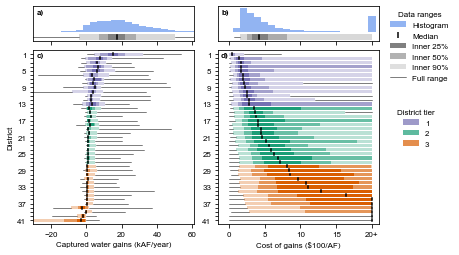

In [17]:
### gains & prices for each district in scenarios for which they are participants
fig,axs = plt.subplots(2,2,figsize=(6.2, 4), sharex='col', sharey='row', gridspec_kw={'hspace':0.08, 'wspace':0.15, 'height_ratios':[1,5]}) 


barht = 0.2

### first do hist of distribution of outcomes for whole partnership - cwg
ax = axs[0,0]
dat = results['total_partner_avg_gain']
# kde_y, kde_x = np.histogram(dat, bins=50)
# kde_x = (kde_x[:-1] + kde_x[1:]) / 2
# kde_y = kde_y / kde_y[kde_x < 20].max()
# ax.plot(kde_x, kde_y, color='0.5')

binsize = 4.0001
binmin = -20
binmax = 60
bins = np.arange(binmin-binsize/2, binmax+2.5*binsize+0.001, binsize)

hist_y, hist_x = np.histogram(dat, bins=bins)
kde_x = [hist_x[0]]
kde_y = [hist_y[0]]
for i in range(len(hist_y)-1):
    kde_x.append(hist_x[i+1])
    kde_y.append(hist_y[i])
    kde_x.append(hist_x[i+1])
    kde_y.append(hist_y[i+1])
ax.fill_between(kde_x, kde_y, color='cornflowerblue', edgecolor='none', alpha=0.7)
print('a)', dat.min(), dat.max(), dat.median(), (dat < 0).mean())
        
        
### now hist of distribution of outcomes for whole partnership - cost
ax = axs[0,1]
dat = results['avg_price_gain_dolAF'] / 100

binsize = 1.0001
binmin = 0
binmax = 20
bins = np.arange(binmin-binsize/2, binmax+2.5*binsize+0.001, binsize)

hist_y, hist_x = np.histogram(dat, bins=bins)
kde_x = [hist_x[0]]
kde_y = [hist_y[0]]
for i in range(len(hist_y)-1):
    kde_x.append(hist_x[i+1])
    kde_y.append(hist_y[i])
    kde_x.append(hist_x[i+1])
    kde_y.append(hist_y[i+1])

ax.fill_between(kde_x, kde_y, color='cornflowerblue', edgecolor='none', alpha=0.7)
barht = barht * (ax.get_ylim()[1] - ax.get_ylim()[0])
print('b)', dat.min(), dat.max(), dat.median(), (dat >19.99999).mean())


### now plot boxplots for cwg & cost
ax = axs[0,0]
dat = results['total_partner_avg_gain']

ax.barh(y = [-barht*1.4], width = [np.quantile(dat, 0.625) - np.quantile(dat, 0.375)],
            left = [np.quantile(dat, 0.375)],
            height = barht, align = 'edge', color='0.5', alpha=1, zorder=2)
ax.barh(y = [-barht*1.4], width = [np.quantile(dat, 0.75) - np.quantile(dat, 0.25)],
            left = [np.quantile(dat, 0.25)],
            height = barht, align = 'edge', color='0.5', alpha=0.5, zorder=2)
ax.barh(y = [-barht*1.4], width = [np.quantile(dat, 0.95) - np.quantile(dat, 0.05)],
            left = [np.quantile(dat, 0.05)],
            height = barht, align = 'edge', color='0.5', alpha=0.3, zorder=2)
ax.plot([np.median(dat)]*2, [-barht*0.4-barht*0.9,-barht*0.4-barht*0.1], color='k', lw=1.5, zorder=3)
ax.plot([np.quantile(dat, 0.0), np.quantile(dat, 0.05)], [-barht*0.4-barht/2]*2, color='k', lw=0.5, zorder=1)
ax.plot([np.quantile(dat, 0.95), np.quantile(dat, 1)], [-barht*0.4-barht/2]*2, color='k', lw=0.5, zorder=1)
ax.annotate('a)', xy=(-28,ax.get_ylim()[1]*0.7), ma='center', xycoords='data', weight='bold', annotation_clip=False)
ax.set_yticks([])
print('overall cwg')
print('min: ', np.quantile(dat, 0.0), '5: ', np.quantile(dat, 0.05),'25: ', np.quantile(dat, 0.25), '50: ', np.quantile(dat, 0.5),
     '75: ', np.quantile(dat, 0.75), '95: ', np.quantile(dat, 0.95), 'max: ', np.quantile(dat, 1))

ax = axs[0,1]
dat = results['avg_price_gain_dolAF'] / 100
ax.barh(y = [-barht*1.4], width = [np.quantile(dat, 0.625) - np.quantile(dat, 0.375)],
            left = [np.quantile(dat, 0.375)],
            height = barht, align = 'edge', color='0.5', alpha=1, zorder=2)
ax.barh(y = [-barht*1.4], width = [np.quantile(dat, 0.75) - np.quantile(dat, 0.25)],
            left = [np.quantile(dat, 0.25)],
            height = barht, align = 'edge', color='0.5', alpha=0.5, zorder=2)
ax.barh(y = [-barht*1.4], width = [np.quantile(dat, 0.95) - np.quantile(dat, 0.05)],
            left = [np.quantile(dat, 0.05)],
            height = barht, align = 'edge', color='0.5', alpha=0.3, zorder=2)
ax.plot([np.median(dat)]*2, [-barht*0.4-barht*0.9,-barht*0.4-barht*0.1], color='k', lw=1.5, zorder=3)
ax.plot([np.quantile(dat, 0.0), np.quantile(dat, 0.05)], [-barht*0.4-barht/2]*2, color='k', lw=0.5, zorder=1)
ax.plot([np.quantile(dat, 0.95), np.quantile(dat, 1)], [-barht*0.4-barht/2]*2, color='k', lw=0.5, zorder=1)
ax.annotate('b)', xy=(-1.1,ax.get_ylim()[1]*0.7), ma='center', xycoords='data', weight='bold', annotation_clip=False)
print('overall price')
print('min: ', np.quantile(dat, 0.0), '5: ', np.quantile(dat, 0.05),'25: ', np.quantile(dat, 0.25), '50: ', np.quantile(dat, 0.5),
     '75: ', np.quantile(dat, 0.75), '95: ', np.quantile(dat, 0.95), 'max: ', np.quantile(dat, 1))

### get gains & prices individual districts, sort based on prices

districts_samp = districts.copy()
for d in districts:
    try:
        if results[d + '_share'].sum() == 0.0:
            districts_samp.remove(d)
    except:
        districts_samp.remove(d)


prices = []
for j,d in enumerate(districts_samp):
    prices.append(results.loc[results[d+'_share'] > 0, d+'_avg_price'] / 100)
    
medians = [np.median(a) for a in prices]
sort = np.argsort(medians)
districts_samp = [districts_samp[s] for s in sort]
prices = [prices[s] for s in sort]

nresort = sum([m == 20.0 for m in medians])
q25s = [np.quantile(a, 0.25) for a in prices[-nresort:]]
sort = np.argsort(q25s)
districts_samp[-nresort:] = [districts_samp[-nresort:][s] for s in sort]
prices[-nresort:] = [prices[-nresort:][s] for s in sort]
q25s = [np.quantile(a, 0.25) for a in prices]
nresort = sum([q == 20.0 for q in q25s])
q05s = [np.quantile(a, 0.05) for a in prices[-nresort:]]
sort = np.argsort(q05s)
districts_samp[-nresort:] = [districts_samp[-nresort:][s] for s in sort]
# prices[-nresort:] = [prices[-nresort:][s] for s in sort]

prices = []
gains = []
for j,d in enumerate(districts_samp):
    prices.append(results.loc[results[d+'_share'] > 0, d+'_avg_price'] / 100)
    gains.append(results.loc[results[d+'_share'] > 0, d+'_exp_gain'])




    
### plot gains individual districts
ax = axs[1,0]

for i in range(3):
    c = pal_cb[i]
    idxs = list(range(breaks[i], breaks[i+1]))
    ax.barh(y = range(len(gains) - breaks[i], len(gains) - breaks[i+1], -1), 
            width = [np.quantile(gains[idx], 0.625) - np.quantile(gains[idx], 0.375) for idx in idxs],
            left = [np.quantile(gains[idx], 0.375) for idx in idxs],
            height = 0.75, align = 'edge', color=c, alpha=1, zorder=2)
    ax.barh(y = np.arange(len(gains) - breaks[i] , len(gains) - breaks[i+1], -1), 
            width = [np.quantile(gains[idx], 0.75) - np.quantile(gains[idx], 0.25) for idx in idxs],
            left = [np.quantile(gains[idx], 0.25) for idx in idxs],
            height = 0.75, align = 'edge', color=c, alpha=0.5, zorder=2)
    ax.barh(y = np.arange(len(gains) - breaks[i], len(gains) - breaks[i+1], -1), 
            width = [np.quantile(gains[idx], 0.95) - np.quantile(gains[idx], 0.05) for idx in idxs],
            left = [np.quantile(gains[idx], 0.05) for idx in idxs],
            height = 0.75, align = 'edge', color=c, alpha=0.3, zorder=2)
    print(districts_samp[breaks[i]: breaks[i+1]])
    
for idx, d in enumerate(districts_samp):
    ax.plot([np.median(gains[idx])]*2, [len(gains) - idx + 0.15, len(gains) - idx + 0.6], color='k', lw=1.5, zorder=3)
    ax.plot([np.quantile(gains[idx], 0.0), np.quantile(gains[idx], 0.05)], [len(gains) - idx + 0.375]*2, color='k', lw=0.5, zorder=1)
    ax.plot([np.quantile(gains[idx], 0.95), np.quantile(gains[idx], 1)], [len(gains) - idx + 0.375]*2, color='k', lw=0.5, zorder=1)
        
     
ax.set_xlim(-30,61)
ax.set_ylim(0.5, 42.5)

ax.set_xlabel('Captured water gains (kAF/year)')
ax.set_ylabel('District')
ax.annotate('c)', xy=(-28,40.6), ma='center', xycoords='data', weight='bold', annotation_clip=False)

ax.set_yticks(np.arange(1.375, 42, 1))
ax.set_ylabel('District')
ax.set_yticklabels([str(41 - i) if i%4 == 0 else '' for i in range(0,41)])

# ### plot prices
ax = axs[1,1]

for i in range(3):
    c = pal_cb[i]
    idxs = list(range(breaks[i], breaks[i+1]))
    ax.barh(y = range(len(prices) - breaks[i], len(prices) - breaks[i+1], -1), 
            width = [np.quantile(prices[idx], 0.625) - np.quantile(prices[idx], 0.375) for idx in idxs],
            left = [np.quantile(prices[idx], 0.375) for idx in idxs],
            height = 0.75, align = 'edge', color=c, alpha=1, zorder=2)
    ax.barh(y = np.arange(len(prices) - breaks[i] , len(prices) - breaks[i+1], -1), 
            width = [np.quantile(prices[idx], 0.75) - np.quantile(prices[idx], 0.25) for idx in idxs],
            left = [np.quantile(prices[idx], 0.25) for idx in idxs],
            height = 0.75, align = 'edge', color=c, alpha=0.5, zorder=2)
    ax.barh(y = np.arange(len(prices) - breaks[i], len(prices) - breaks[i+1], -1), 
            width = [np.quantile(prices[idx], 0.95) - np.quantile(prices[idx], 0.05) for idx in idxs],
            left = [np.quantile(prices[idx], 0.05) for idx in idxs],
            height = 0.75, align = 'edge', color=c, alpha=0.3, zorder=2)

for idx, d in enumerate(districts_samp):
    ax.plot([np.median(prices[idx])]*2, [len(prices) - idx + 0.15, len(prices) - idx + 0.6], color='k', lw=1.5, zorder=3)
    ax.plot([np.quantile(prices[idx], 0.0), np.quantile(prices[idx], 0.05)], [len(prices) - idx + 0.375]*2, color='k', lw=0.5, zorder=1)
    ax.plot([np.quantile(prices[idx], 0.95), np.quantile(prices[idx], 1)], [len(prices) - idx + 0.375]*2, color='k', lw=0.5, zorder=1)
    

ax.set_xlim(-1.5,21)
ax.set_xticks([0,5,10,15,20])
ax.set_xticklabels(['0','5','10','15','20+'])
ax.set_ylim(0.5, 42.5)

ax.set_xlabel('Cost of gains ($100/AF)')
ax.annotate('d)', xy=(-1.1,40.6), ma='center', xycoords='data', weight='bold', annotation_clip=False)

ax.set_yticks(np.arange(1.375, 42, 1))
ax.set_yticklabels([str(41 - i) if i%4 == 0 else '' for i in range(0,41)])
ax.yaxis.set_tick_params(labelleft=True)            
### add legends
leg_tier = [Patch(facecolor=pal_cb[0], label='1', alpha=0.7),
             Patch(facecolor=pal_cb[1], label='2', alpha=0.7),
             Patch(facecolor=pal_cb[2], label='3', alpha=0.7)]
leg1 = axs[1,0].legend(handles=leg_tier, loc='center', bbox_to_anchor=(2.38,0.55), title='District tier', frameon=False)#, ncol=3)
leg1.get_title().set_ma('center')

leg_range = [Patch(facecolor='cornflowerblue', label='Histogram', alpha=0.7),
             Line2D([0],[0], color='k', marker = '|', label='Median', ls = 'none', markeredgewidth=1.5),
             Patch(facecolor='0.5', label='Inner 25%', alpha=1),
             Patch(facecolor='0.5', label='Inner 50%', alpha=0.6),
             Patch(facecolor='0.5', label='Inner 90%', alpha=0.25),
             Line2D([0],[0], color='k', label='Full range', lw=0.5)]
leg1 = axs[1,1].legend(handles=leg_range, loc='center', bbox_to_anchor=(1.25,1.02), title='Data ranges', frameon=False)#, ncol=3)
leg1.get_title().set_ma('center')

figname = 'boxplot_combined'
plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

FKC wet
min:  1.3579441655467914 5:  1.6769645677293499 25:  2.3010860359744605 50:  3.2349904685463384 75:  5.151424000189897 95:  15.398343126505589 max:  20.0
FKC median
min:  1.2730518313614971 5:  1.6598594843876975 25:  2.092722876854337 50:  2.673879914736745 75:  4.309499692617589 95:  13.994686902836094 max:  20.0
FKC dry
min:  2.115140392235735 5:  2.70644297437921 25:  3.5869936041835437 50:  4.62912141721454 75:  6.748604263241793 95:  20.0 max:  20.0
CFWB wet
min:  0.7351572710384592 5:  1.0720635497783892 25:  1.6780087918505242 50:  2.894097551111074 75:  10.223174816600805 95:  20.0 max:  20.0
CFWB median
min:  0.9591939350846733 5:  1.5983797317187338 25:  2.5630037034846436 50:  5.083497606422952 75:  20.0 95:  20.0 max:  20.0
CFWB dry
min:  0.9592764345116072 5:  2.938888370821748 25:  5.482256152776732 50:  11.032660313558818 75:  20.0 95:  20.0 max:  20.0
FKC_CFWB wet
min:  1.1106024795517309 5:  1.5140112050229484 25:  2.073120030109234 50:  2.9450189311341415 75:

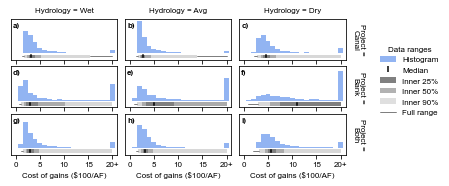

In [140]:
### prices for each district in scenarios for which they are participants - 3x3, split by hydro & project
fig,axs = plt.subplots(3,3,figsize=(6., 2.5), sharex=True, sharey=True, gridspec_kw={'hspace':0.15, 'wspace':0.07}) 

barht = 0.1

### plot 3x3 grid
labels = [['a)','b)','c)'], ['d)','e)','f)'], ['g)','h)','i)']]
binsize = 1.0001
bins = np.arange(-binsize/2, 20+2.5*binsize+0.001, binsize)
for row, p in enumerate(projects):
    for col, h in enumerate(['wet','median','dry']):
        ax = axs[row,col]
    
        ### subset data
        prices = []
        for j,d in enumerate(districts_samp):
            prices.append(results.loc[np.logical_and(np.logical_and(results['project'] == p, results['hydro'] == h), results[d+'_share'] > 0), d+'_avg_price'] / 100)
    
        ### first do distribution of outcomes for whole partnership - cost
        dat = results.loc[np.logical_and(results['project'] == p, results['hydro'] == h), 'avg_price_gain_dolAF'] / 100
        hist_y, hist_x = np.histogram(dat, bins=bins)
        kde_x = [hist_x[0]]
        kde_y = [hist_y[0]]
        for i in range(len(hist_y)-1):
            kde_x.append(hist_x[i+1])
            kde_y.append(hist_y[i])
            kde_x.append(hist_x[i+1])
            kde_y.append(hist_y[i+1])
        ax.fill_between(kde_x, kde_y, color='cornflowerblue', edgecolor='none', alpha=0.7)


barht = barht * (ax.get_ylim()[1] - ax.get_ylim()[0])
for row, p in enumerate(projects):
    for col, h in enumerate(['wet','median','dry']):
        ax = axs[row,col]
        
        ### subset data
        prices = []
        for j,d in enumerate(districts_samp):
            prices.append(results.loc[np.logical_and(np.logical_and(results['project'] == p, results['hydro'] == h), results[d+'_share'] > 0), d+'_avg_price'] / 100)
    
        ### first do distribution of outcomes for whole partnership - cost
        dat = results.loc[np.logical_and(results['project'] == p, results['hydro'] == h), 'avg_price_gain_dolAF'] / 100
        
        ax.barh(y = [-barht*1.4], width = [np.quantile(dat, 0.625) - np.quantile(dat, 0.375)],
                    left = [np.quantile(dat, 0.375)],
                    height = barht, align = 'edge', color='0.5', alpha=1, zorder=2)
        ax.barh(y = [-barht*1.4], width = [np.quantile(dat, 0.75) - np.quantile(dat, 0.25)],
                    left = [np.quantile(dat, 0.25)],
                    height = barht, align = 'edge', color='0.5', alpha=0.5, zorder=2)
        ax.barh(y = [-barht*1.4], width = [np.quantile(dat, 0.95) - np.quantile(dat, 0.05)],
                    left = [np.quantile(dat, 0.05)],
                    height = barht, align = 'edge', color='0.5', alpha=0.3, zorder=2)
        ax.plot([np.median(dat)]*2, [-barht*0.4-barht*0.8,-barht*0.4-barht*0.2], color='k', lw=1.5, zorder=3)
        ax.plot([np.min(dat), np.quantile(dat, 0.05)], [-barht*0.4-barht/2]*2, color='k', lw=0.5, zorder=1)
        ax.plot([np.quantile(dat, 0.95), np.max(dat)], [-barht*0.4-barht/2]*2, color='k', lw=0.5, zorder=1)
#         ax.set_yticks([])
#         ax.set_ylim([-barht*1.2, kde_y[kde_x < 20].max()*1.1])

        print(p,h)
        print('min: ', np.quantile(dat, 0.0), '5: ', np.quantile(dat, 0.05),'25: ', np.quantile(dat, 0.25), '50: ', np.quantile(dat, 0.5),
             '75: ', np.quantile(dat, 0.75), '95: ', np.quantile(dat, 0.95), 'max: ', np.quantile(dat, 1))
        
        
        ax.set_xlim(-1,21)
        if row == 0:
            ax.set_xlabel(f'Hydrology = {ldict_hydro[h]}', labelpad=7)
            ax.xaxis.set_label_position('top') 
        if col==2:
            ax.set_ylabel(f'Project =\n{ldict_project[p]}', rotation=270, labelpad=20)
            ax.yaxis.set_label_position('right')             
        ax.set_xticks(range(0,23,5))
        if row == 2:
            ax.set_xticks([0,5,10,15,20])
            ax.set_xticklabels(['0','5','10','15','20+'])
            ax.set_xlabel('Cost of gains ($100/AF)')
        else:
            ax.set_xticklabels([])
#         if col == 0:
#             ax.set_ylabel('Count')
#         else:
#             ax.set_yticklabels([])
        ax.set_yticks([])
        ax.annotate(labels[row][col], xy=(-0.5,ax.get_ylim()[1]*0.75), ma='center', xycoords='data', weight='bold', annotation_clip=False)

# ### add legends
leg_range = [Patch(facecolor='cornflowerblue', label='Histogram', alpha=0.7),
             Line2D([0],[0], color='k', marker = '|', label='Median', ls = 'none', markeredgewidth=1.5),
             Patch(facecolor='0.5', label='Inner 25%', alpha=1),
             Patch(facecolor='0.5', label='Inner 50%', alpha=0.6),
             Patch(facecolor='0.5', label='Inner 90%', alpha=0.25),
             Line2D([0],[0], color='k', label='Full range', lw=0.5)]
leg1 = axs[0,2].legend(handles=leg_range, loc='center', bbox_to_anchor=(1.6,-0.5), title='Data ranges', frameon=False)#, ncol=3)
leg1.get_title().set_ma('center')

figname = 'boxplot_kde_3x3'
plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

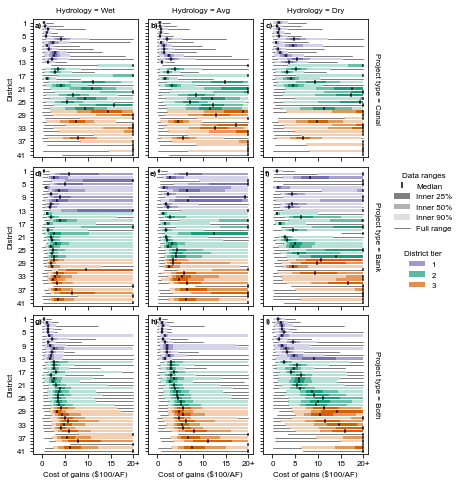

In [18]:
### prices for each district in scenarios for which they are participants - 3x3, split by hydro & project
fig,axs = plt.subplots(3,3,figsize=(6., 8), sharex=True, gridspec_kw={'hspace':0.07, 'wspace':0.1}) 

districts_samp = districts.copy()
for d in districts:
    try:
        if results[d + '_share'].sum() == 0.0:
            districts_samp.remove(d)
    except:
        districts_samp.remove(d)


### sort based on prices
prices = []
for j,d in enumerate(districts_samp):
    prices.append(results.loc[results[d+'_share'] > 0, d+'_avg_price'] / 100)
    
medians = [np.median(a) for a in prices]
sort = np.argsort(medians)
districts_samp = [districts_samp[s] for s in sort]


### plot 3x3 grid
labels = [['a)','b)','c)'], ['d)','e)','f)'], ['g)','h)','i)']]
for row, p in enumerate(projects):
    for col, h in enumerate(['wet','median','dry']):
        ax = axs[row,col]
    
        ### subset data
        prices = []
        for j,d in enumerate(districts_samp):
            prices.append(results.loc[np.logical_and(np.logical_and(results['project'] == p, results['hydro'] == h), results[d+'_share'] > 0), d+'_avg_price'] / 100)
    
        ### plot prices
        for i in range(3):
            c = pal_cb[i]
            idxs = list(range(breaks[i], breaks[i+1]))
            ax.barh(y = range(len(prices) - breaks[i], len(prices) - breaks[i+1], -1), 
                    width = [np.quantile(prices[idx], 0.625) - np.quantile(prices[idx], 0.375) for idx in idxs],
                    left = [np.quantile(prices[idx], 0.375) for idx in idxs],
                    height = 0.75, align = 'edge', color=c, alpha=1, zorder=2)
            ax.barh(y = np.arange(len(prices) - breaks[i] , len(prices) - breaks[i+1], -1), 
                    width = [np.quantile(prices[idx], 0.75) - np.quantile(prices[idx], 0.25) for idx in idxs],
                    left = [np.quantile(prices[idx], 0.25) for idx in idxs],
                    height = 0.75, align = 'edge', color=c, alpha=0.5, zorder=2)
            ax.barh(y = np.arange(len(prices) - breaks[i], len(prices) - breaks[i+1], -1), 
                    width = [np.quantile(prices[idx], 0.95) - np.quantile(prices[idx], 0.05) for idx in idxs],
                    left = [np.quantile(prices[idx], 0.05) for idx in idxs],
                    height = 0.75, align = 'edge', color=c, alpha=0.3, zorder=2)

        for idx, d in enumerate(districts_samp):
            ax.plot([np.median(prices[idx])]*2, [len(prices) - idx + 0.15, len(prices) - idx + 0.6], color='k', lw=1.5, zorder=3)
            ax.plot([np.quantile(prices[idx], 0.0), np.quantile(prices[idx], 0.05)], [len(prices) - idx + 0.375]*2, color='k', lw=0.5, zorder=1)
            ax.plot([np.quantile(prices[idx], 0.95), np.quantile(prices[idx], 1)], [len(prices) - idx + 0.375]*2, color='k', lw=0.5, zorder=1)

        ax.set_xlim(-2,21)
        ax.set_ylim(0.5, 42.5)

        if row == 0:
            ax.set_xlabel(f'Hydrology = {ldict_hydro[h]}', labelpad=7)
            ax.xaxis.set_label_position('top') 
        if col==2:
            ax.set_ylabel(f'Project type = {ldict_project[p]}', rotation=270, labelpad=12)
            ax.yaxis.set_label_position('right')             
        ax.set_xticks(range(0,23,5))
        if row == 2:
            ax.set_xticks([0,5,10,15,20])
            ax.set_xticklabels(['0','5','10','15','20+'])
            ax.set_xlabel('Cost of gains ($100/AF)')
        else:
            ax.set_xticklabels([])
        ax.set_yticks(np.arange(1.375, 42, 1))
        if col == 0:
            ax.set_ylabel('District')
            ax.set_yticklabels([str(41 - i) if i%4 == 0 else '' for i in range(0,41)])
        else:
            ax.set_yticklabels([])
        ax.annotate(labels[row][col], xy=(-1.6,40.), ma='center', xycoords='data', weight='bold', annotation_clip=False)

# ### add legends
leg_tier = [Patch(facecolor=pal_cb[0], label='1', alpha=0.7),
             Patch(facecolor=pal_cb[1], label='2', alpha=0.7),
             Patch(facecolor=pal_cb[2], label='3', alpha=0.7)]
leg1 = axs[2,2].legend(handles=leg_tier, loc='center', bbox_to_anchor=(1.52,1.33), title='District tier', frameon=False)#, ncol=3)
leg1.get_title().set_ma('center')

leg_range = [Line2D([0],[0], color='k', marker = '|', label='Median', ls = 'none', markeredgewidth=1.5),
             Patch(facecolor='0.5', label='Inner 25%', alpha=1),
             Patch(facecolor='0.5', label='Inner 50%', alpha=0.6),
             Patch(facecolor='0.5', label='Inner 90%', alpha=0.25),
             Line2D([0],[0], color='k', label='Full range', lw=0.5)]
leg1 = axs[0,2].legend(handles=leg_range, loc='center', bbox_to_anchor=(1.53,-0.32), title='Data ranges', frameon=False)#, ncol=3)
leg1.get_title().set_ma('center')

figname = 'boxplot_3x3'
plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [16]:
### save district order & colors for map
colors = []
for i in range(3):
    j = breaks[i]
    while j < breaks[i+1]:
        colors.append(pal_cb[i])
        j += 1
df = pd.DataFrame({'district': districts_samp, 'district_label': districts_samp, 'color': colors})
df.to_csv('figures/results_boxplot_combined.csv', index=False)

In [ ]:
### price paid by each district in scenarios for which they are participants. split by hydro, FKC_CFWB only
cav1_order = [1,2,0]
fig,axs = plt.subplots(1,3,figsize=(16,5), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey=True) 
for col,h in enumerate(hydros):
    ax = axs[col]
    subresults = results.loc[np.logical_and(results['hydro'] == h, results['project'] == 'FKC_CFWB'),:]
    prices = []
    for j,d in enumerate(districts_samp):
        prices.append(subresults.loc[subresults[d+'_share'] > 0, d+'_avg_price'] / 100)

    for i in range(3):
#         c = pal_cav1_5[cav1_order[i]]
#         c = pal_zissou1_5[i*2]
        c = pal_cb[i]

        idxs = list(range(breaks[i], breaks[i+1]))
        bplot = ax.boxplot([prices[idx] for idx in idxs], positions=idxs,
                           whis=[5,95], flierprops={'markeredgecolor':c, 'alpha':0.3, 'zorder':1}, 
                           boxprops={'color':c, 'lw':1.5, 'zorder':2},
                           medianprops={'color':'k', 'lw':1.5, 'zorder':3}, patch_artist=True)

        for patch in bplot['boxes']:
            patch.set_facecolor(c)
            patch.set_alpha(0.5)

        idx = [j for j in range(len(districts_samp)) if districts_samp[j] == example_districts[i]][0] - breaks[i]
        bplot['boxes'][idx].set_alpha(1)

    ax.set_xlabel('District')
    ax.set_xticklabels([])
    if col==0:
        ax.set_ylabel('Cost ($100/AF)')

In [ ]:
### price paid by each district in scenarios for which they are participants
subresults = results.loc[np.logical_and(results['hydro'] == 'median', results['project'] == 'FKC'),:]


districts_samp = districts.copy()
for d in districts:
    try:
        if subresults[d + '_share'].sum() == 0.0:
            districts_samp.remove(d)
    except:
        districts_samp.remove(d)

fig,ax = plt.subplots(1,1,figsize=(10,6), gridspec_kw={'hspace':0.1, 'wspace':0.1}) 
prices = []
for j,d in enumerate(districts_samp):
    prices.append(subresults.loc[subresults[d+'_share'] > 0, d+'_avg_price'] / 100)
    
medians = [np.median(a) for a in prices]
sort = np.argsort(medians)
districts_samp = [districts_samp[s] for s in sort]
prices = [prices[s] for s in sort]
nresort = sum([m == 20.0 for m in medians])
q25s = [np.quantile(a, 0.25) for a in prices[-nresort:]]
sort = np.argsort(q25s)
districts_samp[-nresort:] = [districts_samp[-nresort:][s] for s in sort]
prices[-nresort:] = [prices[-nresort:][s] for s in sort]
q25s = [np.quantile(a, 0.25) for a in prices]
nresort = sum([q == 20.0 for q in q25s])
q05s = [np.quantile(a, 0.05) for a in prices[-nresort:]]
sort = np.argsort(q05s)
districts_samp[-nresort:] = [districts_samp[-nresort:][s] for s in sort]
prices[-nresort:] = [prices[-nresort:][s] for s in sort]
print([np.median(a) for a in prices])
print(districts_samp)

bplot = ax.boxplot(prices, whis=[5,95], flierprops={'markeredgecolor':'0.5', 'alpha':0.5}, boxprops={'color':cdict_hydro['wet'], 'lw':1.5},
                   medianprops={'color':cdict_hydro['dry'], 'lw':1.5}, patch_artist=True)
for patch in bplot['boxes']:
    patch.set_facecolor(cdict_hydro['wet'])
    patch.set_alpha(0.5)

In [ ]:
### water gain by each district in scenarios for which they are participants
subresults = results.loc[np.logical_and(results['hydro'] == 'median', results['project'] == 'FKC'),:]


districts_samp = districts.copy()
for d in districts:
    try:
        if subresults[d + '_share'].sum() == 0.0:
            districts_samp.remove(d)
    except:
        districts_samp.remove(d)

fig,ax = plt.subplots(1,1,figsize=(10,6), gridspec_kw={'hspace':0.1, 'wspace':0.1}) 
gains = []
for j,d in enumerate(districts_samp):
    gains.append(-subresults.loc[subresults[d+'_share'] > 0, d+'_exp_gain'])
    
medians = [np.median(a) for a in gains]
sort = np.argsort(medians)
districts_samp = [districts_samp[s] for s in sort]
gains = [-gains[s] for s in sort]
# nresort = sum([m == 20.0 for m in medians])
# q25s = [np.quantile(a, 0.25) for a in gains[-nresort:]]
# sort = np.argsort(q25s)
# districts_samp[-nresort:] = [districts_samp[-nresort:][s] for s in sort]
# gains[-nresort:] = [gains[-nresort:][s] for s in sort]
# q25s = [np.quantile(a, 0.25) for a in gains]
# nresort = sum([q == 20.0 for q in q25s])
# q05s = [np.quantile(a, 0.05) for a in gains[-nresort:]]
# sort = np.argsort(q05s)
# districts_samp[-nresort:] = [districts_samp[-nresort:][s] for s in sort]
# gains[-nresort:] = [gains[-nresort:][s] for s in sort]
# print([np.median(a) for a in gains])
print(districts_samp)

bplot = ax.boxplot(gains, whis=[5,95], flierprops={'markeredgecolor':'0.5', 'alpha':0.5}, boxprops={'color':cdict_hydro['wet'], 'lw':1.5},
                   medianprops={'color':cdict_hydro['dry'], 'lw':1.5}, patch_artist=True)
for patch in bplot['boxes']:
    patch.set_facecolor(cdict_hydro['wet'])
    patch.set_alpha(0.5)

ax.axhline(0, color='k', ls='--')

In [ ]:
### price paid by each district in scenarios for which they are participants. smaller subset, split by hydro
fig,axs = plt.subplots(3,3,figsize=(14,14), gridspec_kw={'hspace':0.1, 'wspace':0.1}) 
for row,h in enumerate(hydros):
    for col,p in enumerate(projects):
        subresults = results.loc[np.logical_and(results['hydro'] == h, results['project'] == p),:]
        prices = []
        for j,d in enumerate(districts_samp):
            prices.append(subresults.loc[subresults[d+'_share'] > 0, d+'_avg_price'] / 100)

        bplot = axs[row,col].boxplot(prices, whis=[5,95], flierprops={'markeredgecolor':'0.5', 'alpha':0.5, 'marker':mdict_project[p]}, 
                                     boxprops={'color':cdict_hydro[h], 'lw':1.5, 'alpha':0.5},
                                     medianprops={'color':cdict_hydro[h], 'lw':1.5}, patch_artist=True)
        for patch in bplot['boxes']:
            patch.set_facecolor(cdict_hydro[h])
            patch.set_alpha(0.5)
            
            
        axs[row,col].set_xticks([])
        axs[row,col].set_yticks([])

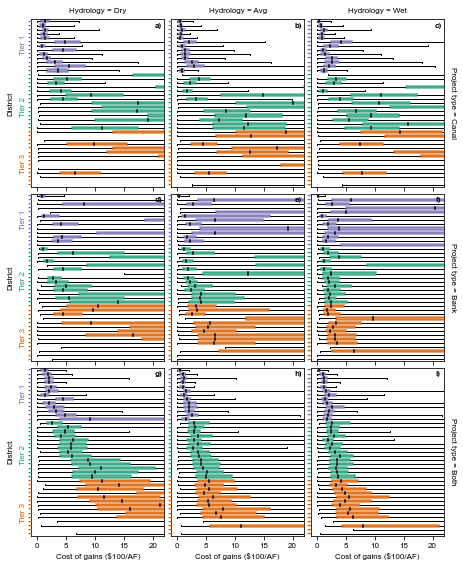

In [110]:
### price paid by each district in scenarios for which they are participants. 3x3, project x hydro
cav1_order = [1,2,0]
iod1_order = [3,2,1]
labels = [['a)','b)','c)'], ['d)','e)','f)'], ['g)','h)','i)']]
fig,axs = plt.subplots(3,3,figsize=(7.4,9.5), gridspec_kw={'hspace':0.04, 'wspace':0.05}, sharex=True, sharey=True) 
for col,h in enumerate(hydros):
    for row,p in enumerate(projects):
        ax = axs[row,col]
        ax.set_xlim([-1,22])
        subresults = results.loc[np.logical_and(results['hydro'] == h, results['project'] == p),:]
        prices = []
        for j,d in enumerate(districts_samp):
            prices.append(subresults.loc[subresults[d+'_share'] > 0, d+'_avg_price'] / 100)

        for i in range(3):
            c = pal_cb[i]
            idxs = list(range(breaks[i], breaks[i+1]))
            bplot = ax.boxplot([prices[idx] for idx in idxs], vert=False, 
                               positions=range(len(prices) - breaks[i], len(prices) - breaks[i+1], -1),
                               whis=[0,100], flierprops={'markeredgecolor':c, 'alpha':0.}, 
                               boxprops={'color':c, 'lw':1.5},
                               medianprops={'color':'k', 'lw':1.5}, patch_artist=True)
        
            for patch in bplot['boxes']:
                patch.set_facecolor(c)
                patch.set_alpha(0.7)
            
            for idx in idxs:
                ax.annotate('-', xy=(-1.7, len(prices) - idx - 0.7), ma='center', xycoords='data', 
                            color=c, size=12, weight='bold', annotation_clip=False)
            
        if row==2:
            ax.set_xlabel('Cost of gains ($100/AF)')
        ax.set_yticks([])
        if col==0:
            ax.set_ylabel('District', labelpad=18)
            ax.annotate('Tier 1', xy=(-2.9, 33), rotation=90, ma='center', xycoords='data', color=pal_cb[0], annotation_clip=False)
            ax.annotate('Tier 2', xy=(-2.9, 18), rotation=90, ma='center', xycoords='data', color=pal_cb[1], annotation_clip=False)
            ax.annotate('Tier 3', xy=(-2.9, 4), rotation=90, ma='center', xycoords='data', color=pal_cb[2], annotation_clip=False)

        ax.annotate(labels[row][col], xy=(21,40), ha='center', va='center', weight='bold')
        
        if row==0:
            ax.set_xlabel(f'Hydrology = {ldict_hydro[h]}', labelpad=7)
            ax.xaxis.set_label_position('top') 
        if col==2:
            ax.set_ylabel(f'Project type = {ldict_project[p]}', rotation=270, labelpad=12)
            ax.yaxis.set_label_position('right') 
            
        
figname = 'boxplot_3x3'
# plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [ ]:
### price paid by each district in scenarios for which they are participants.  split by project, median hydro only
cav1_order = [1,2,0]
fig,axs = plt.subplots(1,3,figsize=(16,5), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey=True) 
for col,p in enumerate(projects):
    ax = axs[col]
    subresults = results.loc[np.logical_and(results['hydro'] == 'median', results['project'] == p),:]
    prices = []
    for j,d in enumerate(districts_samp):
        prices.append(subresults.loc[subresults[d+'_share'] > 0, d+'_avg_price'] / 100)

    for i in range(3):
#         c = pal_cav1_5[cav1_order[i]]
#         c = pal_zissou1_5[i*2]
        c = pal_cb[i]
        idxs = list(range(breaks[i], breaks[i+1]))
        bplot = ax.boxplot([prices[idx] for idx in idxs], positions=idxs,
                           whis=[5,95], flierprops={'markeredgecolor':c, 'alpha':0.3, 'zorder':1}, 
                           boxprops={'color':c, 'lw':1.5, 'zorder':2},
                           medianprops={'color':'k', 'lw':1.5, 'zorder':3}, patch_artist=True)

        for patch in bplot['boxes']:
            patch.set_facecolor(c)
            patch.set_alpha(0.5)

        idx = [j for j in range(len(districts_samp)) if districts_samp[j] == example_districts[i]][0] - breaks[i]
        bplot['boxes'][idx].set_alpha(1)

    ax.set_xlabel('District')
    ax.set_xticklabels([])
    if col==0:
        ax.set_ylabel('Cost ($100/AF)')

In [ ]:
### price paid by each district in scenarios for which they are participants. split by hydro, FKC_CFWB only
cav1_order = [1,2,0]
fig,axs = plt.subplots(1,3,figsize=(16,5), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey=True) 
for col,h in enumerate(hydros):
    ax = axs[col]
    subresults = results.loc[np.logical_and(results['hydro'] == h, results['project'] == 'FKC_CFWB'),:]
    prices = []
    for j,d in enumerate(districts_samp):
        prices.append(subresults.loc[subresults[d+'_share'] > 0, d+'_avg_price'] / 100)

    for i in range(3):
#         c = pal_cav1_5[cav1_order[i]]
#         c = pal_zissou1_5[i*2]
        c = pal_cb[i]

        idxs = list(range(breaks[i], breaks[i+1]))
        bplot = ax.boxplot([prices[idx] for idx in idxs], positions=idxs,
                           whis=[5,95], flierprops={'markeredgecolor':c, 'alpha':0.3, 'zorder':1}, 
                           boxprops={'color':c, 'lw':1.5, 'zorder':2},
                           medianprops={'color':'k', 'lw':1.5, 'zorder':3}, patch_artist=True)

        for patch in bplot['boxes']:
            patch.set_facecolor(c)
            patch.set_alpha(0.5)

        idx = [j for j in range(len(districts_samp)) if districts_samp[j] == example_districts[i]][0] - breaks[i]
        bplot['boxes'][idx].set_alpha(1)

    ax.set_xlabel('District')
    ax.set_xticklabels([])
    if col==0:
        ax.set_ylabel('Cost ($100/AF)')

In [ ]:
### CWG for each district in scenarios for which they are participants. smaller subset, split by hydro
cav1_order = [1,2,0]
fig,axs = plt.subplots(1,3,figsize=(16,5), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey=True) 
for col,p in enumerate(projects):
    ax = axs[col]
    subresults = results.loc[np.logical_and(results['hydro'] == 'median', results['project'] == p),:]
    gains = []
    for j,d in enumerate(districts_samp):
        gains.append(subresults.loc[subresults[d+'_share'] > 0, d+'_exp_gain'])

    for i in range(3):
        c = pal_cav1_5[cav1_order[i]]
        idxs = list(range(breaks[i], breaks[i+1]))
        bplot = ax.boxplot([gains[idx] for idx in idxs], positions=idxs,
                           whis=[5,95], flierprops={'markeredgecolor':c, 'alpha':0.5, 'zorder':1}, 
                           boxprops={'color':c, 'lw':1.5, 'zorder':2},
                           medianprops={'color':'k', 'lw':1.5, 'zorder':3}, patch_artist=True)

        for patch in bplot['boxes']:
            patch.set_facecolor(c)
            patch.set_alpha(0.5)

        idx = [j for j in range(len(districts_samp)) if districts_samp[j] == example_districts[i]][0] - breaks[i]
        bplot['boxes'][idx].set_alpha(0.8)

    ax.axhline(0, color='0.5', ls='--', alpha=0.5)
    ax.set_xlabel('District')
    ax.set_xticklabels([])
    if col==0:
        ax.set_ylabel('Captured water\ngain (kAF/yr)')

In [ ]:
### pairwise correlations
nd = len(districts_samp)
corrs = np.ones([nd, nd])
for i, di in enumerate(districts_samp):
    for j, dj in enumerate(districts_samp):
        pair = np.logical_and(results[di+'_share'] > 0, results[dj+'_share'] > 0)
        pi = results.loc[pair, di+'_avg_price'] / 100
        pj = results.loc[pair, dj+'_avg_price'] / 100
        pi += np.random.normal(0, 0.0001, len(pi))
        pj += np.random.normal(0, 0.0001, len(pj))
        corrs[i,j] = spearmanr(pi, pj)[0]
        
sns.heatmap(corrs, cmap='coolwarm_r', vmin=-1, vmax=1)

In [ ]:
### pairwise correlations, split by hydro/proj
fig,axs = plt.subplots(3,3,figsize=(14,14), gridspec_kw={'hspace':0.1, 'wspace':0.1}) 

nd = len(districts_samp)
for row,h in enumerate(hydros):
    for col,p in enumerate(projects):
        ax = axs[row,col]
        subresults = results.loc[np.logical_and(results['hydro'] == h, results['project'] == p),:]
        corrs = np.zeros([nd, nd])
        for i, di in enumerate(districts_samp):
            for j, dj in enumerate(districts_samp):
                pair = np.logical_and(subresults[di+'_share'] > 0, subresults[dj+'_share'] > 0)
                if len(pair) > 3:
                    pi = subresults.loc[pair, di+'_avg_price'] / 100
                    pj = subresults.loc[pair, dj+'_avg_price'] / 100
                    pi += np.random.normal(0, 0.0001, len(pi))
                    pj += np.random.normal(0, 0.0001, len(pj))
                    corrs[i,j] = spearmanr(pi, pj)[0]
                else:
                    corrs[i,j] = 2
        sns.heatmap(corrs, ax=ax, cmap='coolwarm_r', vmin=-1, vmax=1)
        ax.set_xticks([])
        ax.set_yticks([])

In [ ]:
### pairwise price correlations, split by proj, median hydro
fig,axs = plt.subplots(1,3,figsize=(16,5), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharex=True, sharey=True) 
cbar_ax = fig.add_axes([.91, .3, .03, .4])

nd = len(districts_samp)
# for row,h in enumerate(hydros):
for col,p in enumerate(projects):
    ax = axs[col]
    subresults = results.loc[np.logical_and(results['project'] == p, results['hydro'] == 'median'),:]
    corrs = np.zeros([nd, nd])
    for i, di in enumerate(districts_samp):
        for j, dj in enumerate(districts_samp):
            pair = np.logical_and(subresults[di+'_share'] > 0, subresults[dj+'_share'] > 0)
            if len(pair) > 3:
                pi = subresults.loc[pair, di+'_avg_price'] / 100
                pj = subresults.loc[pair, dj+'_avg_price'] / 100
                pi += np.random.normal(0, 0.0001, len(pi))
                pj += np.random.normal(0, 0.0001, len(pj))
                corrs[i,j] = spearmanr(pi, pj)[0]
            else:
                corrs[i,j] = 2
    sns.heatmap(corrs, ax=ax, cmap='coolwarm_r', vmin=-1, vmax=1, cbar=(col==0), cbar_ax=None if col else cbar_ax)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('District')
    if col==0:
        ax.set_ylabel('District')

fig.tight_layout(rect=[0, 0, .9, 1])

In [ ]:
### pairwise CWG correlations, split by proj, median hydro
fig,axs = plt.subplots(1,3,figsize=(16,5), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharex=True, sharey=True) 
cbar_ax = fig.add_axes([.91, .3, .03, .4])

nd = len(districts_samp)
# for row,h in enumerate(hydros):
for col,p in enumerate(projects):
    ax = axs[col]
    subresults = results.loc[np.logical_and(results['project'] == p, results['hydro'] == 'median'),:]
    corrs = np.zeros([nd, nd])
    for i, di in enumerate(districts_samp):
        for j, dj in enumerate(districts_samp):
            pair = np.logical_and(subresults[di+'_share'] > 0, subresults[dj+'_share'] > 0)
            if len(pair) > 3:
                gi = subresults.loc[pair, di+'_exp_gain'] 
                gj = subresults.loc[pair, dj+'_exp_gain'] 
                corrs[i,j] = spearmanr(gi, gj)[0]
            else:
                corrs[i,j] = 2
    sns.heatmap(corrs, ax=ax, cmap='coolwarm_r', vmin=-1, vmax=1, cbar=(col==0), cbar_ax=None if col else cbar_ax)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('District')
    if col==0:
        ax.set_ylabel('District')

fig.tight_layout(rect=[0, 0, .9, 1])

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(14,8), gridspec_kw={'hspace':0.1, 'wspace':0.1}) 
print(districts_samp)
di='CWO'
dj='CWO'
pair = np.logical_and(subresults[di+'_share'] > 0, subresults[dj+'_share'] > 0)
pi = subresults.loc[pair, di+'_avg_price'] / 100
pj = subresults.loc[pair, dj+'_avg_price'] / 100
pi += np.random.normal(0, 0.0001, len(pi))
pj += np.random.normal(0, 0.0001, len(pj))
axs[0].scatter(pi,pj, alpha=0.3)
print(np.corrcoef(pi,pj)[1,0])

axs[1].scatter(rankdata(pi), rankdata(pj), alpha=0.3)
print(spearmanr(pi,pj)[0])

# plt.xlim([0,3])
# plt.ylim([0,3])

In [ ]:
### number of matches for each pair, split by hydro/proj
fig,axs = plt.subplots(3,3,figsize=(14,14), gridspec_kw={'hspace':0.1, 'wspace':0.1}) 

nd = len(districts_samp)
for row,h in enumerate(hydros):
    for col,p in enumerate(projects):
        ax = axs[row,col]
        subresults = results.loc[np.logical_and(results['hydro'] == h, results['project'] == p),:]
        print(subresults.shape)
        numpairs = np.zeros([nd, nd])
        for i, di in enumerate(districts_samp):
            for j, dj in enumerate(districts_samp):
                pair = np.logical_and(subresults[di+'_share'] > 0, subresults[dj+'_share'] > 0)
                numpairs[i,j] = subresults.loc[pair].shape[0]
                
        sns.heatmap(numpairs, ax=ax, cmap='coolwarm_r', vmin=0, vmax=600)
        ax.set_xticks([])
        ax.set_yticks([])

### do certain districts benefit from larger partnerships and/or shares?

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(14,8), gridspec_kw={'hspace':0.1, 'wspace':0.1}) 

for di in ['PIX','SSJ','DLR','FRS']:

    boo = subresults[di+'_share'] > 0
    pi = subresults.loc[boo, di+'_avg_price'] / 100
    si = subresults.loc[boo, di+'_share'] 
    ni = subresults.loc[boo, 'num_partners'] 

    pi += np.random.normal(0, 0.0001, len(pi))
    # axs[0].scatter(ni,pi, alpha=0.3)
    # print(np.corrcoef(ni,pi)[1,0])

    axs[0].scatter(si,pi, alpha=0.3)
    print(np.corrcoef(si,pi)[1,0])

    # axs[0].scatter(rankdata(ni),rankdata(pi), alpha=0.3)
    # print(spearmanr(ni,pi)[0])

    axs[1].scatter(rankdata(si),rankdata(pi), alpha=0.3)
    print(spearmanr(si,pi)[0])

In [ ]:
### get slope vs correlation for prices for each district
fig,axs = plt.subplots(3,3,figsize=(14,14), gridspec_kw={'hspace':0.1, 'wspace':0.1}, sharey=True, sharex=True) 

nd = len(districts_samp)
for row,h in enumerate(hydros):
    for col,p in enumerate(projects):
        ax = axs[row,col]
        subresults = results.loc[np.logical_and(results['hydro'] == h, results['project'] == p),:]
        corrs = []
        slopes = []
        medprice = []
        for i, di in enumerate(districts_samp):
            boo = subresults[di+'_share'] > 0
            pi = subresults.loc[boo, di+'_avg_price'] / 100
            si = subresults.loc[boo, di+'_share'] 
            pi += np.random.normal(0, 0.0001, len(pi))
            corrs.append(np.corrcoef(pi,si)[0,1])
            lm = sm.OLS(pi, sm.add_constant(si)).fit()
            slopes.append(lm.params[1])
            medprice.append(np.median(pi))
            if di in ['PIX','SFW','LHL']:
                ax.scatter(slopes[-1:],corrs[-1:],marker='*',c='k', zorder=2)
                
        ax.scatter(slopes,corrs, c=medprice, cmap='coolwarm', vmin=0, vmax=20, zorder=1)
        ax.set_xticks([])
        ax.set_yticks([])

In [ ]:
### get slope vs correlation for CWG for each district
fig,axs = plt.subplots(3,3,figsize=(14,14), gridspec_kw={'hspace':0.1, 'wspace':0.1}, sharey=True, sharex=True) 

nd = len(districts_samp)
for row,h in enumerate(hydros):
    for col,p in enumerate(projects):
        ax = axs[row,col]
        subresults = results.loc[np.logical_and(results['hydro'] == h, results['project'] == p),:]
        corrs = []
        slopes = []
        medprice = []
        for i, di in enumerate(districts_samp):
            boo = subresults[di+'_share'] > 0
            pi = subresults.loc[boo, di+'_exp_gain']
            si = subresults.loc[boo, di+'_share'] 
#             pi += np.random.normal(0, 0.0001, len(pi))
            corrs.append(np.corrcoef(pi,si)[0,1])
            lm = sm.OLS(pi, sm.add_constant(si)).fit()
            slopes.append(lm.params[1])
            medprice.append(np.median(pi))
            if di in ['PIX','SFW','LHL']:
                ax.scatter(slopes[-1:],corrs[-1:],marker='*',c='k', zorder=2)
                
        ax.scatter(slopes,corrs, c=medprice, cmap='coolwarm_r', zorder=1)
        ax.set_xticks([])
        ax.set_yticks([])

In [ ]:
### look at returns (price) to scale for each district
fig,axs = plt.subplots(3,3,figsize=(14,14), gridspec_kw={'hspace':0.05, 'wspace':0.05}) 

nd = len(districts_samp)
for row,h in enumerate(hydros):
    for col,p in enumerate(projects):
        ax = axs[row,col]
        subresults = results.loc[np.logical_and(results['hydro'] == h, results['project'] == p),:]

        for i, di in enumerate(example_districts): 
            c = pal_cav1_5[cav1_order[i]]
            boo = subresults[di+'_share'] > 0
            pi = subresults.loc[boo, di+'_avg_price'] / 100
            si = subresults.loc[boo, di+'_share'] 
            ax.scatter(si, pi, alpha=0.5, color=c)
    
        ax.set_xticks([])
        ax.set_yticks([])

In [ ]:
### look at returns (price) to scale for each district
fig,axs = plt.subplots(3,3,figsize=(14,14), gridspec_kw={'hspace':0.05, 'wspace':0.05}) 

nd = len(districts_samp)
for row,h in enumerate(hydros):
    for col,p in enumerate(projects):
        ax = axs[row,col]
        subresults = results.loc[np.logical_and(results['hydro'] == h, results['project'] == p),:]

        for i, di in enumerate(example_districts): 
            c = pal_cav1_5[cav1_order[i]]
            boo = subresults[di+'_share'] > 0
            pi = subresults.loc[boo, di+'_avg_price'] / 100
            si = subresults.loc[boo, di+'_share'] 
            ax.scatter(si, pi, alpha=0.5, color=c)
    
        ax.set_xticks([])
        ax.set_yticks([])

In [ ]:
### look at returns (CWG) to scale for each district
fig,axs = plt.subplots(3,3,figsize=(14,14), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey=True) 

nd = len(districts_samp)
for row,h in enumerate(hydros):
    for col,p in enumerate(projects):
        ax = axs[row,col]
        subresults = results.loc[np.logical_and(results['hydro'] == h, results['project'] == p),:]
#         corrs = []
#         slopes = []
#         medprice = []
        for i, di in enumerate(example_districts): 
            c = pal_cav1_5[cav1_order[i]]
            boo = subresults[di+'_share'] > 0
            gi = subresults.loc[boo, di+'_exp_gain'] / 100
            si = subresults.loc[boo, di+'_share'] 
            ax.scatter(si, gi, alpha=0.5, color=c)
        ax.set_xticks([])
        ax.set_yticks([])

In [ ]:
### look at returns (price) to scale for each district
fig,axs = plt.subplots(1,3,figsize=(16,5), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey=True) 

nd = len(districts_samp)
for col,p in enumerate(projects):
    ax = axs[col]
    subresults = results.loc[np.logical_and(results['hydro'] == 'median', results['project'] == p),:]

    for i, di in enumerate(example_districts): 
        c = pal_cav1_5[cav1_order[i]]
        boo = subresults[di+'_share'] > 0
        pi = subresults.loc[boo, di+'_avg_price'] / 100
        si = subresults.loc[boo, di+'_share'] 
        ax.scatter(si, pi, alpha=0.5, color=c)

    ax.set_xlabel('Ownership\nshare')
    if col==0:
        ax.set_ylabel('Cost ($100/AF)')

In [ ]:
### look at returns (CWG) to scale for each district
fig,axs = plt.subplots(1,3,figsize=(16,5), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey=True) 

nd = len(districts_samp)
for col,p in enumerate(projects):
    ax = axs[col]
    subresults = results.loc[np.logical_and(results['hydro'] == 'median', results['project'] == p),:]
    for i, di in enumerate(example_districts): 
        c = pal_cav1_5[cav1_order[i]]
        boo = subresults[di+'_share'] > 0
        gi = subresults.loc[boo, di+'_exp_gain'] / 100
        si = subresults.loc[boo, di+'_share'] 
        ax.scatter(si, gi, alpha=0.5, color=c)

    ax.set_xlabel('Ownership\nshare')
    if col==0:
        ax.set_ylabel('Captured water\ngain (AF/yr)')
#     else:
#         ax.set_yticklabels([])

In [ ]:
### look at returns to scale for each district, split by project type, across all hydros
fig,axs = plt.subplots(2,3,figsize=(16,10), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey='row', sharex=True) 

nd = len(districts_samp)
labels = [['a)','b)','c)'], ['d)','e)','f)']]

### first do CWG
for col,p in enumerate(projects):
    ax = axs[0,col]
#     subresults = results.loc[np.logical_and(results['hydro'] == 'median', results['project'] == p),:]
    subresults = results.loc[results['project'] == p,:]

    for i, di in enumerate(example_districts): 
#         c = pal_cav1_5[cav1_order[i]]
#         c = pal_zissou1_5[i*2]
        c = pal_cb[i]

        boo = subresults[di+'_share'] > 0
        gi = (subresults.loc[boo, di+'_exp_gain']).values
        si = (subresults.loc[boo, di+'_share'] ).values
        
#         ## rolling window
#         sort = np.argsort(si)
#         si = [si[s] for s in sort]
#         gi = [gi[s] for s in sort]
#         df = pd.DataFrame({'si':si, 'gi':gi})
#         si_smooth = df.si.rolling(500).median()
#         gi_median = df.gi.rolling(500).median()
#         gi_p05 = df.gi.rolling(500).quantile(0.25)
#         gi_p95 = df.gi.rolling(500).quantile(0.75)
        
#         ax.plot(si_smooth, gi_median, color=c, lw=2, zorder=6-i)
#         ax.fill_between(si_smooth, gi_p05, gi_p95, color=c, alpha=0.2, zorder=3-i)
#         ax.plot(si_smooth, gi_p05, color=c, alpha=0.6, zorder=3-i, ls='--')
#         ax.plot(si_smooth, gi_p95, color=c, alpha=0.6, zorder=3-i, ls='--')   

        ### moving window of s
        window = 0.02
        si_smooth = np.arange(0,0.3001,0.01)
        gi_median = np.zeros(len(si_smooth))
        gi_p25 = np.zeros(len(si_smooth))
        gi_p75 = np.zeros(len(si_smooth))
        for ii in range(len(si_smooth)):
            gi_median[ii] = np.quantile(gi[np.abs(si - si_smooth[ii]) < window], 0.5)
            gi_p25[ii] = np.quantile(gi[np.abs(si - si_smooth[ii]) < window], 0.25)
            gi_p75[ii] = np.quantile(gi[np.abs(si - si_smooth[ii]) < window], 0.75)
        
        ax.plot(si_smooth, gi_median, color=c, lw=2, zorder=6-i)
        ax.fill_between(si_smooth, gi_p25, gi_p75, color=c, alpha=0.4, zorder=3-i)
        ax.plot(si_smooth, gi_p25, color=c, zorder=3-i, ls='--')
        ax.plot(si_smooth, gi_p75, color=c, zorder=3-i, ls='--')  
        
        ax.annotate(labels[0][col], xy=[0.03,12.2], ha='center', va='center', weight='bold', zorder=7)

    if col==0:
        ax.set_ylabel('Captured water\ngain (kAF/yr)')
        ax.set_title('Canal')
    elif col==1:
        ax.set_title('Bank')
    else:
        ax.set_title('Both')
        
### now do prices
for col,p in enumerate(projects):
    ax = axs[1,col]
    subresults = results.loc[results['project'] == p,:]
#     subresults = results.loc[np.logical_and(results['hydro'] == 'median', results['project'] == p),:]
    for i, di in enumerate(example_districts): 
#         c = pal_cav1_5[cav1_order[i]]
#         c = pal_zissou1_5[i*2]
        c = pal_cb[i]
    
        boo = subresults[di+'_share'] > 0
        pi = (subresults.loc[boo, di+'_avg_price'] / 100).values
        si = (subresults.loc[boo, di+'_share'] ).values
        
#         ## rolling window
#         sort = np.argsort(si)
#         si = [si[s] for s in sort]
#         pi = [pi[s] for s in sort]
#         df = pd.DataFrame({'si':si, 'pi':pi})
#         si_smooth = df.si.rolling(500).median()
#         pi_median = df.pi.rolling(500).median()
#         pi_p05 = df.pi.rolling(500).quantile(0.25)
#         pi_p95 = df.pi.rolling(500).quantile(0.75)
        
#         ax.plot(si_smooth, pi_median, color=c, lw=2, zorder=6-i)
#         ax.fill_between(si_smooth, pi_p05, pi_p95, color=c, alpha=0.4, zorder=3-i)
#         ax.plot(si_smooth, pi_p05, color=c, zorder=6-i, ls='--')
#         ax.plot(si_smooth, pi_p95, color=c, zorder=6-i, ls='--')

        ### moving window of s
        window = 0.02
        si_smooth = np.arange(0,0.3001,0.01)
        pi_median = np.zeros(len(si_smooth))
        pi_p25 = np.zeros(len(si_smooth))
        pi_p75 = np.zeros(len(si_smooth))
        for ii in range(len(si_smooth)):
            pi_median[ii] = np.quantile(pi[np.abs(si - si_smooth[ii]) < window], 0.5)
            pi_p25[ii] = np.quantile(pi[np.abs(si - si_smooth[ii]) < window], 0.25)
            pi_p75[ii] = np.quantile(pi[np.abs(si - si_smooth[ii]) < window], 0.75)
        
        ax.plot(si_smooth, pi_median, color=c, lw=2, zorder=6-i)
        ax.fill_between(si_smooth, pi_p25, pi_p75, color=c, alpha=0.4, zorder=3-i)
        ax.plot(si_smooth, pi_p25, color=c, zorder=6-i, ls='--')
        ax.plot(si_smooth, pi_p75, color=c, zorder=6-i, ls='--')
        
        ax.annotate(labels[1][col], xy=[0.03,19.8], ha='center', va='center', weight='bold', zorder=7)
        
    ax.set_xlabel('Ownership\nshare')
    if col==0:
        ax.set_ylabel('Cost ($100/AF)')


figname = 'share_cost_project_xhydro'
plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [ ]:
### look at returns to scale for each district, split by hydro, FKC_CFWB only
fig,axs = plt.subplots(2,3,figsize=(16,10), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey='row', sharex=True) 

nd = len(districts_samp)
labels = [['a)','b)','c)'], ['d)','e)','f)']]

### first do CWG
for col,h in enumerate(hydros):
    ax = axs[0,col]
    subresults = results.loc[np.logical_and(results['hydro'] == h, results['project'] == 'FKC_CFWB'),:]
#     subresults = results.loc[results['hydro'] == h,:]

    for i, di in enumerate(example_districts): 
#         c = pal_cav1_5[cav1_order[i]]
#         c = pal_zissou1_5[i*2]
        c = pal_cb[i]

        boo = subresults[di+'_share'] > 0
        gi = (subresults.loc[boo, di+'_exp_gain']).values
        si = (subresults.loc[boo, di+'_share'] ).values
        
#         ## rolling window
#         sort = np.argsort(si)
#         si = [si[s] for s in sort]
#         gi = [gi[s] for s in sort]
#         df = pd.DataFrame({'si':si, 'gi':gi})
#         si_smooth = df.si.rolling(150).median()
#         gi_median = df.gi.rolling(150).median()
#         gi_p05 = df.gi.rolling(150).quantile(0.25)
#         gi_p95 = df.gi.rolling(150).quantile(0.75)
        
#         ax.plot(si_smooth, gi_median, color=c, lw=2, zorder=6-i)
#         ax.fill_between(si_smooth, gi_p05, gi_p95, color=c, alpha=0.4, zorder=3-i)
#         ax.plot(si_smooth, gi_p05, color=c, zorder=3-i, ls='--')
#         ax.plot(si_smooth, gi_p95, color=c, zorder=3-i, ls='--')    

        ### moving window of s
        window = 0.02
        si_smooth = np.arange(0,0.3001,0.01)
        gi_median = np.zeros(len(si_smooth))
        gi_p25 = np.zeros(len(si_smooth))
        gi_p75 = np.zeros(len(si_smooth))
        for ii in range(len(si_smooth)):
            gi_median[ii] = np.quantile(gi[np.abs(si - si_smooth[ii]) < window], 0.5)
            gi_p25[ii] = np.quantile(gi[np.abs(si - si_smooth[ii]) < window], 0.25)
            gi_p75[ii] = np.quantile(gi[np.abs(si - si_smooth[ii]) < window], 0.75)
        
        ax.plot(si_smooth, gi_median, color=c, lw=2, zorder=6-i)
        ax.fill_between(si_smooth, gi_p25, gi_p75, color=c, alpha=0.4, zorder=3-i)
        ax.plot(si_smooth, gi_p25, color=c, zorder=3-i, ls='--')
        ax.plot(si_smooth, gi_p75, color=c, zorder=3-i, ls='--')    
        
        ax.annotate(labels[0][col], xy=[0.03,14], ha='center', va='center', weight='bold', zorder=7)
        
    if col==0:
        ax.set_ylabel('Captured water\ngain (kAF/yr)')
        ax.set_title('Dry')
    elif col==1:
        ax.set_title('Average')
    else:
        ax.set_title('Wet')
        
### now do prices
for col,h in enumerate(hydros):
    ax = axs[1,col]
    subresults = results.loc[np.logical_and(results['hydro'] == h, results['project'] == 'FKC_CFWB'),:]
#     subresults = results.loc[results['hydro'] == h,:]

    for i, di in enumerate(example_districts): 
#         c = pal_cav1_5[cav1_order[i]]
#         c = pal_zissou1_5[i*2]
        c = pal_cb[i]

        boo = subresults[di+'_share'] > 0
        pi = (subresults.loc[boo, di+'_avg_price'] / 100).values
        si = (subresults.loc[boo, di+'_share'] ).values
        
#         ## rolling window
#         sort = np.argsort(si)
#         si = [si[s] for s in sort]
#         pi = [pi[s] for s in sort]
#         df = pd.DataFrame({'si':si, 'pi':pi})
#         si_smooth = df.si.rolling(150).median()
#         pi_median = df.pi.rolling(150).median()
#         pi_p05 = df.pi.rolling(150).quantile(0.25)
#         pi_p95 = df.pi.rolling(150).quantile(0.75)
        
#         ax.plot(si_smooth, pi_median, color=c, lw=2, zorder=6-i)
#         ax.fill_between(si_smooth, pi_p05, pi_p95, color=c, alpha=0.4, zorder=3-i)
#         ax.plot(si_smooth, pi_p05, color=c, zorder=6-i, ls='--')
#         ax.plot(si_smooth, pi_p95, color=c, zorder=6-i, ls='--')

        ### moving window of s
        window = 0.02
        si_smooth = np.arange(0,0.3001,0.01)
        pi_median = np.zeros(len(si_smooth))
        pi_p25 = np.zeros(len(si_smooth))
        pi_p75 = np.zeros(len(si_smooth))
        for ii in range(len(si_smooth)):
            pi_median[ii] = np.quantile(pi[np.abs(si - si_smooth[ii]) < window], 0.5)
            pi_p25[ii] = np.quantile(pi[np.abs(si - si_smooth[ii]) < window], 0.25)
            pi_p75[ii] = np.quantile(pi[np.abs(si - si_smooth[ii]) < window], 0.75)
        
        ax.plot(si_smooth, pi_median, color=c, lw=2, zorder=6-i)
        ax.fill_between(si_smooth, pi_p25, pi_p75, color=c, alpha=0.4, zorder=3-i)
        ax.plot(si_smooth, pi_p25, color=c, zorder=6-i, ls='--')
        ax.plot(si_smooth, pi_p75, color=c, zorder=6-i, ls='--')
        
        ax.annotate(labels[1][col], xy=[0.03,19.8], ha='center', va='center', weight='bold', zorder=7)

    ax.set_xlabel('Ownership\nshare')
    if col==0:
        ax.set_ylabel('Cost ($100/AF)')

figname = 'share_cost_hydro_projBoth'
plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [ ]:
### look at returns to scale for each district, satisficing only. split by hydro, marker by project. 
### filter by WP-cost < 500
fig,axs = plt.subplots(2,3,figsize=(12,8), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey='row', sharex=True) 

nd = len(districts_samp)
labels = [['a)','b)','c)'], ['d)','e)','f)']]

### first do CWG
for col,h in enumerate(hydros):
    ax = axs[0,col]
    subresults = results.loc[np.logical_and(results['hydro'] == h, results['worst_price_avg_gain'] < 5),:]
    print(subresults.shape)

    for i, di in enumerate(example_districts): 
        c = pal_cb[i]

        for p in projects:
            boo = np.logical_and(subresults[di+'_share'] > 0, subresults['project'] == p)
            gi = (subresults.loc[boo, di+'_exp_gain']).values
            si = (subresults.loc[boo, di+'_share'] ).values
            mi = mdict_project[p]
            for sii, gii in zip(si, gi):
                ax.scatter(sii, gii, alpha=0.6, color=c, marker=mi, zorder=random.choice([1,2,3]))    
    
    ax.annotate(labels[0][col], xy=(-0.01,20), weight='bold')
    
    if col==0:
        ax.set_ylabel('Captured water\ngain (kAF/yr)')
        ax.set_title('Dry')
    elif col==1:
        ax.set_title('Average')
    else:
        ax.set_title('Wet')
        
### now do prices
for col,h in enumerate(hydros):
    ax = axs[1,col]
    subresults = results.loc[np.logical_and(results['hydro'] == h, results['worst_price_avg_gain'] < 5),:]

    for i, di in enumerate(example_districts): 
        c = pal_cb[i]

        for p in projects:
            boo = np.logical_and(subresults[di+'_share'] > 0, subresults['project'] == p)
            pi = (subresults.loc[boo, di+'_avg_price'] / 100).values
            si = (subresults.loc[boo, di+'_share'] ).values
            mi = mdict_project[p]
            for sii, pii in zip(si, pi):
                ax.scatter(sii, pii, alpha=0.6, color=c, marker=mi, zorder=random.choice([1,2,3]))

    ax.annotate(labels[1][col], xy=(-0.01,4.8), weight='bold')
                
    ax.set_xlabel('Ownership\nshare')
    if col==0:
        ax.set_ylabel('Cost ($100/AF)')
        
leg_tier = [Patch(facecolor=pal_cb[0], label='1', alpha=0.8),
             Patch(facecolor=pal_cb[1], label='2', alpha=0.8),
             Patch(facecolor=pal_cb[2], label='3', alpha=0.8)]
leg1 = axs[0,2].legend(handles=leg_tier, loc='center', bbox_to_anchor=(1.2,0.3), title='District\ntier', frameon=False)
leg1.get_title().set_ma('center')

leg_proj = [Line2D([0],[0], color='0.5', lw=0, marker=mdict_project['FKC'], label='Canal'),
            Line2D([0],[0], color='0.5', lw=0, marker=mdict_project['CFWB'], label='Bank'),
            Line2D([0],[0], color='0.5', lw=0, marker=mdict_project['FKC_CFWB'], label='Both'),]
leg1 = axs[1,2].legend(handles=leg_proj, loc='center', bbox_to_anchor=(1.2,0.7), title='Project\ntype', frameon=False)
leg1.get_title().set_ma('center')
    
axs[0,0].set_xlim([-0.02,0.42])
axs[0,0].set_ylim([-1,22])
# axs[1,0].set_ylim([0,5.2])


figname = 'share_cost_scatter'
plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [ ]:
### look at returns to scale for each district, satisficing only. split by hydro, marker by project. 
### filter by WP-cost < 500
fig,axs = plt.subplots(2,3,figsize=(12,8), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey='row', sharex=True) 

nd = len(districts_samp)
labels = [['a)','b)','c)'], ['d)','e)','f)']]

### first do CWG
for col,h in enumerate(hydros):
    ax = axs[0,col]
    subresults = results.loc[np.logical_and(results['hydro'] == h, results['worst_price_avg_gain'] < 5),:]
    print(subresults.shape)

    for i, di in enumerate(example_districts): 
        c = pal_cb[i]

        for p in projects:
            boo = np.logical_and(subresults[di+'_share'] > 0, subresults['project'] == p)
            gi = (subresults.loc[boo, di+'_exp_gain']).values
            si = (subresults.loc[boo, di+'_share'] ).values
            mi = mdict_project[p]
            for sii, gii in zip(si, gi):
                ax.scatter(sii, gii, alpha=0.6, color=c, marker=mi, zorder=random.choice([1,2,3]))    
    
    ax.annotate(labels[0][col], xy=(-0.02,46), weight='bold')
    
    if col==0:
        ax.set_ylabel('Captured water\ngain (kAF/yr)')
        ax.set_title('Dry')
    elif col==1:
        ax.set_title('Average')
    else:
        ax.set_title('Wet')
        
### now do prices
for col,h in enumerate(hydros):
    ax = axs[1,col]
    subresults = results.loc[np.logical_and(results['hydro'] == h, results['worst_price_avg_gain'] < 5),:]

    for i, di in enumerate(example_districts): 
        c = pal_cb[i]

        for p in projects:
            boo = np.logical_and(subresults[di+'_share'] > 0, subresults['project'] == p)
            pi = (subresults.loc[boo, di+'_avg_price'] / 100).values
            si = (subresults.loc[boo, di+'_share'] ).values
            mi = mdict_project[p]
            for sii, pii in zip(si, pi):
                ax.scatter(sii, pii, alpha=0.6, color=c, marker=mi, zorder=random.choice([1,2,3]))

    ax.annotate(labels[1][col], xy=(-0.02,4.8), weight='bold')
                
    ax.set_xlabel('Ownership\nshare')
    if col==0:
        ax.set_ylabel('Cost ($100/AF)')
        
leg_tier = [Patch(facecolor=pal_cb[0], label='1', alpha=0.8),
             Patch(facecolor=pal_cb[1], label='2', alpha=0.8),
             Patch(facecolor=pal_cb[2], label='3', alpha=0.8)]
leg1 = axs[0,2].legend(handles=leg_tier, loc='center', bbox_to_anchor=(1.2,0.3), title='District\ntier', frameon=False)
leg1.get_title().set_ma('center')

leg_proj = [Line2D([0],[0], color='0.5', lw=0, marker=mdict_project['FKC'], label='Canal'),
            Line2D([0],[0], color='0.5', lw=0, marker=mdict_project['CFWB'], label='Bank'),
            Line2D([0],[0], color='0.5', lw=0, marker=mdict_project['FKC_CFWB'], label='Both'),]
leg1 = axs[1,2].legend(handles=leg_proj, loc='center', bbox_to_anchor=(1.2,0.7), title='Project\ntype', frameon=False)
leg1.get_title().set_ma('center')
    
# axs[0,0].set_xlim([-0.02,0.42])
# axs[0,0].set_ylim([-1,22])
# axs[1,0].set_ylim([0,5.2])


figname = 'share_cost_scatter_full'
plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [ ]:
### get fraction of tolerable futures across share range 

labels = [['a)','b)','c)'], ['d)','e)','f)']]
# share_blocks = np.arange(0,0.35001, 0.05)
share_blocks = np.arange(0,0.4001, 0.1)
# tick_labels = ['[0,0.05]', '[0.05,0.1]', '[0.1,0.15]', '[0.15,0.2]', '[0.2,0.25]', '[0.25,0.3]', '[0.3,0.35]']
tick_labels = ['[0,0.1]', '[0.1,0.2]', '[0.2,0.3]', '[0.3,0.4]']
block_step = 0.025

fig,axs = plt.subplots(1,3,figsize=(12,3), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey='row', sharex=True) 
for col,h in enumerate(hydros):
    ax = axs[col]

    for i, di in enumerate(example_districts): 
        c = pal_cb[i]

        subresults = results.loc[np.logical_and(results['hydro'] == h, results[di + '_share'] > 0),:]

        fracs = []
        for smin, smax in zip(share_blocks[:-1], share_blocks[1:]):
            subsubres = subresults.loc[np.logical_and(results[di + '_share'] > smin, results[di + '_share'] <= smax), :]
            fracs.append(subsubres.shape[0])
        
        ax.bar([i*block_step + j for j in share_blocks[:-1]], fracs, align='edge', width=block_step, color=pal_cb[i])
        ax.set_xlabel('Share')
        if col==0:
            ax.set_ylabel('Number samples')
        ax.set_title(h)
    ax.set_xticks([block_step + s for s in share_blocks[:-1]])
    ax.set_xticklabels(tick_labels, rotation=40, ha='right', va='top')

        
fig,axs = plt.subplots(3,3,figsize=(12,8), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey=True, sharex=True) 
for col,h in enumerate(hydros):
    for row,p in enumerate(projects):
        ax = axs[row, col]

        for i, di in enumerate(example_districts): 
            c = pal_cb[i]

            subresults = results.loc[np.logical_and(np.logical_and(results['hydro'] == h, results[di + '_share'] > 0), results['project'] == p),:]

            fracs = []
            for smin, smax in zip(share_blocks[:-1], share_blocks[1:]):
                subsubres = subresults.loc[np.logical_and(results[di + '_share'] > smin, results[di + '_share'] <= smax), :]
                fracs.append(subsubres.loc[subsubres['worst_price_avg_gain'] <= 5].shape[0] / subsubres.shape[0])

            ax.bar([i*block_step + j for j in share_blocks[:-1]], fracs, align='edge', width=block_step, color=c)
            ax.set_xlabel('Share')
            if col==0:
                ax.set_ylabel('Fraction viable')
            if row==0:
                ax.set_title(h)
        ax.set_xticks([block_step + s for s in share_blocks[:-1]])
        ax.set_xticklabels(tick_labels, rotation=60, ha='right')        
        
        

fig,axs = plt.subplots(3,3,figsize=(12,8), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey=True, sharex=True) 
for col,h in enumerate(hydros):
    for row,p in enumerate(projects):
        ax = axs[row, col]

        for i, di in enumerate(example_districts): 
            c = pal_cb[i]

            subresults = results.loc[np.logical_and(np.logical_and(results['hydro'] == h, results[di + '_share'] > 0), results['project'] == p),:]

            means = []
            errs = np.zeros((2, len(share_blocks) - 1))
            count = 0
            for smin, smax in zip(share_blocks[:-1], share_blocks[1:]):
                subsubres = subresults.loc[np.logical_and(results[di + '_share'] > smin, results[di + '_share'] <= smax), :]
                means.append(subsubres.loc[subsubres['worst_price_avg_gain'] <= 5, di+'_exp_gain'].mean()) 
                try:
                    errs[0, count] = means[-1] - np.quantile(subsubres.loc[subsubres['worst_price_avg_gain'] <= 5, di+'_exp_gain'], 0.05)
                    errs[1, count] = np.quantile(subsubres.loc[subsubres['worst_price_avg_gain'] <= 5, di+'_exp_gain'], 0.95) - means[-1]
                except:
                    errs[:, count] = [0,0]
                count += 1

            ax.bar([i*block_step + j for j in share_blocks[:-1]], means, yerr=errs, align='edge', width=block_step,alpha=0.5, color=c, ecolor=c)

            ax.set_xlabel('Share')
            if col==0:
                ax.set_ylabel('Partner water gain\nin viable partnerships')
            if row==0:
                ax.set_title(h)
        ax.set_xticks([block_step + s for s in share_blocks[:-1]])
        ax.set_xticklabels(tick_labels, rotation=60, ha='right') 
        
        
fig,axs = plt.subplots(3,3,figsize=(12,8), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey=True, sharex=True) 
for col,h in enumerate(hydros):
    for row,p in enumerate(projects):
        ax = axs[row, col]

        for i, di in enumerate(example_districts): 
            c = pal_cb[i]

            subresults = results.loc[np.logical_and(np.logical_and(results['hydro'] == h, results[di + '_share'] > 0), results['project'] == p),:]

            means = []
            errs = np.zeros((2, len(share_blocks) - 1))
            count = 0
            for smin, smax in zip(share_blocks[:-1], share_blocks[1:]):
                subsubres = subresults.loc[np.logical_and(results[di + '_share'] > smin, results[di + '_share'] <= smax), :]
                means.append(subsubres.loc[subsubres['worst_price_avg_gain'] <= 5, di+'_avg_price'].mean() / 100) 
                try:
                    errs[0, count] = means[-1] - np.quantile(subsubres.loc[subsubres['worst_price_avg_gain'] <= 5, di+'_avg_price'], 0.05) / 100
                    errs[1, count] = np.quantile(subsubres.loc[subsubres['worst_price_avg_gain'] <= 5, di+'_avg_price'], 0.95) / 100 - means[-1]
                except:
                    errs[:, count] = [0,0]
                count += 1

            ax.bar([i*block_step + j for j in share_blocks[:-1]], means, yerr=errs, align='edge', width=block_step,alpha=0.5, color=c, ecolor=c)

            ax.set_xlabel('Share')
            if col==0:
                ax.set_ylabel('Partner cost\nin viable partnerships')
            if row==0:
                ax.set_title(h)
        ax.set_xticks([block_step + s for s in share_blocks[:-1]])
        ax.set_xticklabels(tick_labels, rotation=60, ha='right') 
        
        
        

In [ ]:
### get fraction of tolerable futures across share range 

labels = [['a)','b)','c)'], ['d)','e)','f)']]
# share_blocks = np.arange(0,0.35001, 0.05)
share_blocks = np.arange(0,0.35001, 0.05)
tick_labels = ['[0,0.05]', '[0.05,0.1]', '[0.1,0.15]', '[0.15,0.2]', '[0.2,0.25]', '[0.25,0.3]', '[0.3,0.35]']
# tick_labels = ['[0,0.1]', '[0.1,0.2]', '[0.2,0.3]', '[0.3,0.4]']
block_step = 0.0125

        


fig,axs = plt.subplots(3,3,figsize=(12,8), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey=True, sharex=True) 
for col,h in enumerate(hydros):
    for row,p in enumerate(projects):
        ax = axs[row, col]

        for i, di in enumerate(example_districts): 
            c = pal_cb[i]

            subresults = results.loc[np.logical_and(np.logical_and(results['hydro'] == h, results[di + '_share'] > 0), results['project'] == p),:]

            prices = []
            for smin, smax in zip(share_blocks[:-1], share_blocks[1:]):
                subsubres = subresults.loc[np.logical_and(results[di + '_share'] > smin, results[di + '_share'] <= smax), :]
                prices.append(subsubres.loc[subsubres['worst_price_avg_gain'] <= 5, di+'_avg_price'] / 100) 
                
#             print(prices, [i*block_step + j for j in share_blocks[:-1]])
            bplot = ax.boxplot(prices, positions=[i*block_step + j for j in share_blocks[:-1]], widths=block_step*0.5,
                               whis=[0,100], flierprops={'markeredgecolor':c, 'alpha':0., 'zorder':1}, 
                               boxprops={'color':c, 'lw':1.5, 'zorder':2},
                               medianprops={'color':c, 'lw':3, 'zorder':3},
                               whiskerprops={'color':c, 'lw':1},
                               capprops={'color':c, 'lw':1}, patch_artist=True)
            for patch in bplot['boxes']:
                patch.set_facecolor(c)
                patch.set_alpha(0.5)
            
            for s in share_blocks:
                ax.axvline(s - block_step, color='0.5', lw=0.5, zorder=1)
            
            ax.set_xlabel('Share')
            if col==0:
                ax.set_ylabel('Cost in viable\npartnerships ($100/AF)')
            elif col==2:
                ax.set_ylabel(ldict_project[p], rotation=270, labelpad=15, fontsize=12)
                ax.yaxis.set_label_position('right')
            if row==0:
                ax.set_title(ldict_hydro[h], fontsize=12)
            ax.set_xticks([block_step + s for s in share_blocks[:-1]])
            if row==2:
                ax.set_xticklabels(tick_labels, rotation=60, ha='right') 
            ax.set_xlim([-0.0125, 0.3675])
            ax.set_ylim([-0.5,5.5])
        

In [ ]:
### get fraction of tolerable futures across share range 

labels = [['a)','b)','c)'], ['d)','e)','f)']]
# share_blocks = np.arange(0,0.35001, 0.05)
share_blocks = np.arange(0,0.35001, 0.05)
tick_labels = ['[0,0.05]', '[0.05,0.1]', '[0.1,0.15]', '[0.15,0.2]', '[0.2,0.25]', '[0.25,0.3]', '[0.3,0.35]']
# tick_labels = ['[0,0.1]', '[0.1,0.2]', '[0.2,0.3]', '[0.3,0.4]']
block_step = 0.0125

        


fig,axs = plt.subplots(3,3,figsize=(12,8), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey=True, sharex=True) 
for col,h in enumerate(hydros):
    for row,p in enumerate(projects):
        ax = axs[row, col]

        for i, di in enumerate(example_districts): 
            c = pal_cb[i]

            subresults = results.loc[np.logical_and(np.logical_and(results['hydro'] == h, results[di + '_share'] > 0), results['project'] == p),:]

            prices = []
            for smin, smax in zip(share_blocks[:-1], share_blocks[1:]):
                subsubres = subresults.loc[np.logical_and(results[di + '_share'] > smin, results[di + '_share'] <= smax), :]
                prices.append(subsubres.loc[subsubres['worst_price_avg_gain'] <= 50, di+'_avg_price'] / 100) 
                
#             print(prices, [i*block_step + j for j in share_blocks[:-1]])
            bplot = ax.boxplot(prices, positions=[i*block_step + j for j in share_blocks[:-1]], widths=block_step*0.5,
                               whis=[0,100], flierprops={'markeredgecolor':c, 'alpha':0., 'zorder':1}, 
                               boxprops={'color':c, 'lw':1.5, 'zorder':2},
                               medianprops={'color':c, 'lw':3, 'zorder':3},
                               whiskerprops={'color':c, 'lw':1},
                               capprops={'color':c, 'lw':1}, patch_artist=True)
            for patch in bplot['boxes']:
                patch.set_facecolor(c)
                patch.set_alpha(0.5)
            
            for s in share_blocks:
                ax.axvline(s - block_step, color='0.5', lw=0.5, zorder=1)
            
            ax.set_xlabel('Share')
            if col==0:
                ax.set_ylabel('Cost ($100/AF)')
            elif col==2:
                ax.set_ylabel(ldict_project[p], rotation=270, labelpad=15, fontsize=12)
                ax.yaxis.set_label_position('right')
            if row==0:
                ax.set_title(ldict_hydro[h], fontsize=12)
            ax.set_xticks([block_step + s for s in share_blocks[:-1]])
            if row==2:
                ax.set_xticklabels(tick_labels, rotation=60, ha='right') 
            ax.set_xlim([-0.0125, 0.3375])
            ax.set_ylim([-1,21])
        

In [ ]:
### each district's fraction viable (in terms of their own costs) across different share ranges

labels = [['a)','b)','c)'], ['d)','e)','f)']]
share_blocks = np.arange(0,0.35001, 0.05)
# share_blocks = np.arange(0,0.5001, 0.1)
tick_labels = ['(0, 0.05]', '(0.05, 0.1]', '(0.1, 0.15]', '(0.15, 0.2]', '(0.2, 0.25]', '(0.25, 0.3]', '(0.3, 0.35]']
# tick_labels = ['[0,0.1]', '[0.1,0.2]', '[0.2,0.3]', '[0.3,0.4]', '[0.4,0.5]']
block_step = 0.0125

        


fig,axs = plt.subplots(3,3,figsize=(12,8), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey=True, sharex=True) 
for col,h in enumerate(hydros):
    for row,p in enumerate(projects):
        ax = axs[row, col]

        for i, di in enumerate(districts_samp):
            tier = sum([i >= j for j in breaks[:-1]])
            c = pal_cb[tier - 1]

            subresults = results.loc[np.logical_and(np.logical_and(results['hydro'] == h, results[di + '_share'] > 0), results['project'] == p),:]

            frac = []
            for smin, smax in zip(share_blocks[:-1], share_blocks[1:]):
                subsubres = subresults.loc[np.logical_and(results[di + '_share'] > smin, results[di + '_share'] <= smax), :]
                frac.append((subsubres[di+'_avg_price'] / 100 < 5).mean()) 
                
            ax.scatter([tier*block_step + j for j in share_blocks[:-1]], frac, color=c, alpha=0.3)
            
        for s in share_blocks:
            ax.axvline(s, color='0.5', lw=0.5, zorder=1)

        ax.set_xlabel('Share')
        if col==0:
            ax.set_ylabel('Fraction satisficing')
        elif col==2:
            ax.set_ylabel(ldict_project[p], rotation=270, labelpad=15, fontsize=12)
            ax.yaxis.set_label_position('right')
        if row==0:
            ax.set_title(ldict_hydro[h], fontsize=12)
        ax.set_xticks([block_step * 2 + s for s in share_blocks[:-1]])
        if row==2:
            ax.set_xticklabels(tick_labels, rotation=60, ha='right') 
        ax.set_xlim([0, 0.35])
#         ax.set_ylim([-1,21])

In [ ]:
### each district's fraction viable (in terms of their own costs) across different share ranges

labels = [['a)','b)','c)'], ['d)','e)','f)']]
share_blocks = np.arange(0,0.35001, 0.05)
# share_blocks = np.arange(0,0.5001, 0.1)
tick_labels = ['(0, 0.05]', '(0.05, 0.1]', '(0.1, 0.15]', '(0.15, 0.2]', '(0.2, 0.25]', '(0.25, 0.3]', '(0.3, 0.35]']
# tick_labels = ['[0,0.1]', '[0.1,0.2]', '[0.2,0.3]', '[0.3,0.4]', '[0.4,0.5]']
block_step = 0.0125

        


fig,axs = plt.subplots(3,3,figsize=(12,8), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey=True, sharex=True) 
for col,h in enumerate(hydros):
    for row,p in enumerate(projects):
        ax = axs[row, col]

        for smin, smax in zip(share_blocks[:-1], share_blocks[1:]):

            frac = [[],[],[]]
            for i, di in enumerate(districts_samp):
                tier = sum([i >= j for j in breaks[:-1]])

                subresults = results.loc[np.logical_and(np.logical_and(results['hydro'] == h, results[di + '_share'] > 0), results['project'] == p),:]

                subsubres = subresults.loc[np.logical_and(results[di + '_share'] > smin, results[di + '_share'] <= smax), :]
                frac[tier-1].append((subsubres[di+'_avg_price'] / 100 < 4).mean()) 
            
            for i in range(3):
                c = pal_cb[i]
                bplot = ax.boxplot(frac[i], positions=[smin + i * block_step], widths=block_step*0.5,
                                   whis=[0,100], flierprops={'markeredgecolor':c, 'alpha':0., 'zorder':1}, 
                                   boxprops={'color':c, 'lw':1.5, 'zorder':2},
                                   medianprops={'color':c, 'lw':3, 'zorder':3},
                                   whiskerprops={'color':c, 'lw':1},
                                   capprops={'color':c, 'lw':1}, patch_artist=True)
                for patch in bplot['boxes']:
                    patch.set_facecolor(c)
                    patch.set_alpha(0.5)            
            
        for s in share_blocks:
            ax.axvline(s - block_step, color='0.5', lw=0.5, zorder=1)

        if col==1 and row==2:
            ax.set_xlabel('Ownership share', labelpad=10)
        if col==0 and row==1:
            ax.set_ylabel('Fraction satisficing', labelpad=10)
        elif col==2:
            ax.set_ylabel(ldict_project[p], rotation=270, labelpad=15, fontsize=12)
            ax.yaxis.set_label_position('right')
        if row==0:
            ax.set_title(ldict_hydro[h], fontsize=12)
        ax.set_xticks([block_step * 2 + s for s in share_blocks[:-1]])
        if row==2:
            ax.set_xticklabels(tick_labels, rotation=60, ha='right') 
        ax.set_xlim([-block_step, share_blocks[-1] - block_step])

leg_tier = [Patch(facecolor=pal_cb[0], label='1', alpha=0.8),
             Patch(facecolor=pal_cb[1], label='2', alpha=0.8),
             Patch(facecolor=pal_cb[2], label='3', alpha=0.8)]
leg1 = axs[1,2].legend(handles=leg_tier, loc='center', bbox_to_anchor=(1.3,0.5), title='District\ntier', frameon=False)
leg1.get_title().set_ma('center')

figname = 'share_frac_tiers_3x3'
# plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [ ]:
### all-district boxplots after viability filter

fig,ax = plt.subplots(1,1,figsize=(5,8), gridspec_kw={'hspace':0.1, 'wspace':0.1}) 
prices = []
for j,d in enumerate(districts_samp):
    prices.append(results.loc[np.logical_and(results[d+'_share'] > 0, results['worst_price_avg_gain'] < 5), d+'_avg_price'] / 100)

for i in range(3):
    c = pal_cb[i]

    idxs = list(range(breaks[i], breaks[i+1]))
    bplot = ax.boxplot([prices[idx] for idx in idxs], vert=False, 
                       positions=range(len(prices) - breaks[i], len(prices) - breaks[i+1], -1),
                       whis=[5,95], flierprops={'markeredgecolor':c, 'alpha':0., 'zorder':1}, 
                       boxprops={'color':c, 'lw':1.5, 'zorder':2},
                       medianprops={'color':'k', 'lw':1.5, 'zorder':3}, patch_artist=True)

    for patch in bplot['boxes']:
        patch.set_facecolor(c)
        patch.set_alpha(0.7)


ax.set_ylabel('Districts')
ax.set_yticklabels([])
ax.set_xlabel('Cost ($100/AF)')

figname = 'boxplot_combined_filtered'
# plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [ ]:
### all-district boxplots of price after viability filter, 3x3 separation
cav1_order = [1,2,0]
iod1_order = [3,2,1]
labels = [['a)','b)','c)'], ['d)','e)','f)'], ['g)','h)','i)']]
fig,axs = plt.subplots(3,3,figsize=(9,12), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharex=True, sharey=True) 
for col,h in enumerate(hydros):
    for row,p in enumerate(projects):
        ax = axs[row,col]
        subresults = results.loc[np.logical_and(np.logical_and(results['hydro'] == h, results['project'] == p), results['worst_price_avg_gain'] < 500),:]
        prices = []
        for j,d in enumerate(districts_samp):
            prices.append(subresults.loc[subresults[d+'_share'] > 0, d+'_avg_price'] / 100)

        for i in range(3):
            c = pal_cb[i]
            idxs = list(range(breaks[i], breaks[i+1]))
            bplot = ax.boxplot([prices[idx] for idx in idxs], vert=False, 
                               positions=range(len(prices) - breaks[i], len(prices) - breaks[i+1], -1),
                               whis=[0,100], flierprops={'markeredgecolor':c, 'alpha':0.}, 
                               boxprops={'color':c, 'lw':1.5},
                               medianprops={'color':'k', 'lw':1.5}, patch_artist=True)
        
            for patch in bplot['boxes']:
                patch.set_facecolor(c)
                patch.set_alpha(0.7)
            
        if row==2:
            ax.set_xlabel('Cost ($100/AF)')
        elif row==0:
            ax.set_title(ldict_hydro[h], fontsize=12)
        ax.set_yticklabels([])
        if col==0:
            ax.set_ylabel('District')
        elif col==2:
            ax.set_ylabel(ldict_project[p], rotation=270, labelpad=15, fontsize=12)
            ax.yaxis.set_label_position('right')

        ax.annotate(labels[row][col], xy=(19.5,39), ha='center', va='center', weight='bold')
        
figname = 'boxplot_3x3_filtered'
# plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [ ]:
### all-district boxplots of price after viability filter, 3x3 separation
cav1_order = [1,2,0]
iod1_order = [3,2,1]
labels = [['a)','b)','c)'], ['d)','e)','f)'], ['g)','h)','i)']]
fig,axs = plt.subplots(3,3,figsize=(9,12), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharex=True, sharey=True) 
for col,h in enumerate(hydros):
    for row,p in enumerate(projects):
        ax = axs[row,col]
        subresults = results.loc[np.logical_and(np.logical_and(results['hydro'] == h, results['project'] == p), results['worst_price_avg_gain'] < 5),:]
        prices = []
        for j,d in enumerate(districts_samp):
            prices.append(subresults.loc[subresults[d+'_share'] > 0, d+'_avg_price'] / 100)

        for i in range(3):
            c = pal_cb[i]
            idxs = list(range(breaks[i], breaks[i+1]))
            bplot = ax.boxplot([prices[idx] for idx in idxs], vert=False, 
                               positions=range(len(prices) - breaks[i], len(prices) - breaks[i+1], -1),
                               whis=[5,95], flierprops={'markeredgecolor':c, 'alpha':0.}, 
                               boxprops={'color':c, 'lw':1.5},
                               medianprops={'color':'k', 'lw':1.5}, patch_artist=True)
        
            for patch in bplot['boxes']:
                patch.set_facecolor(c)
                patch.set_alpha(0.7)
            
        if row==2:
            ax.set_xlabel('Cost ($100/AF)')
        elif row==0:
            ax.set_title(ldict_hydro[h], fontsize=12)
        ax.set_yticklabels([])
        if col==0:
            ax.set_ylabel('District')
        elif col==2:
            ax.set_ylabel(ldict_project[p], rotation=270, labelpad=15, fontsize=12)
            ax.yaxis.set_label_position('right')

        ax.annotate(labels[row][col], xy=(19.5,39), ha='center', va='center', weight='bold')
        
figname = 'boxplot_3x3_filtered'
# plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [ ]:
### all-district boxplots of gains after viability filter, 3x3 separation
cav1_order = [1,2,0]
iod1_order = [3,2,1]
labels = [['a)','b)','c)'], ['d)','e)','f)'], ['g)','h)','i)']]
fig,axs = plt.subplots(3,3,figsize=(9,12), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharex=True, sharey=True) 
for col,h in enumerate(hydros):
    for row,p in enumerate(projects):
        ax = axs[row,col]
        subresults = results.loc[np.logical_and(np.logical_and(results['hydro'] == h, results['project'] == p), results['worst_price_avg_gain'] < 5),:]
        gains = []
        for j,d in enumerate(districts_samp):
            gains.append(subresults.loc[subresults[d+'_exp_gain'] > 0, d+'_share'])

        for i in range(3):
            c = pal_cb[i]
            idxs = list(range(breaks[i], breaks[i+1]))
            bplot = ax.boxplot([gains[idx] for idx in idxs], vert=False, 
                               positions=range(len(prices) - breaks[i], len(prices) - breaks[i+1], -1),
                               whis=[5,95], flierprops={'markeredgecolor':c, 'alpha':0.}, 
                               boxprops={'color':c, 'lw':1.5},
                               medianprops={'color':'k', 'lw':1.5}, patch_artist=True)
        
            for patch in bplot['boxes']:
                patch.set_facecolor(c)
                patch.set_alpha(0.7)
            
        if row==2:
            ax.set_xlabel('Captured water\ngain (AF/yr)')
        elif row==0:
            ax.set_title(ldict_hydro[h], fontsize=12)
        ax.set_yticklabels([])
        if col==0:
            ax.set_ylabel('District')
        elif col==2:
            ax.set_ylabel(ldict_project[p], rotation=270, labelpad=15, fontsize=12)
            ax.yaxis.set_label_position('right')

#         ax.annotate(labels[row][col], xy=(19.5,39), ha='center', va='center', weight='bold')
        
figname = 'boxplot_3x3_filtered'
# plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [ ]:
### all-district boxplots of number partners after viability filter, 3x3 separation
cav1_order = [1,2,0]
iod1_order = [3,2,1]
labels = [['a)','b)','c)'], ['d)','e)','f)'], ['g)','h)','i)']]
fig,axs = plt.subplots(3,3,figsize=(9,12), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharex=True, sharey=True) 
for col,h in enumerate(hydros):
    for row,p in enumerate(projects):
        ax = axs[row,col]
        subresults = results.loc[np.logical_and(np.logical_and(results['hydro'] == h, results['project'] == p), results['worst_price_avg_gain'] < 5),:]
        numpartners = []
        for j,d in enumerate(districts_samp):
            numpartners.append(subresults.loc[subresults[d+'_share'] > 0, 'num_partners'])

        for i in range(3):
            c = pal_cb[i]
            idxs = list(range(breaks[i], breaks[i+1]))
            bplot = ax.boxplot([numpartners[idx] for idx in idxs], vert=False, 
                               positions=range(len(prices) - breaks[i], len(prices) - breaks[i+1], -1),
                               whis=[5,95], flierprops={'markeredgecolor':c, 'alpha':0.}, 
                               boxprops={'color':c, 'lw':1.5},
                               medianprops={'color':'k', 'lw':1.5}, patch_artist=True)
        
            for patch in bplot['boxes']:
                patch.set_facecolor(c)
                patch.set_alpha(0.7)
            
        if row==2:
            ax.set_xlabel('Number of partners')
        elif row==0:
            ax.set_title(ldict_hydro[h], fontsize=12)
        ax.set_yticklabels([])
        if col==0:
            ax.set_ylabel('District')
        elif col==2:
            ax.set_ylabel(ldict_project[p], rotation=270, labelpad=15, fontsize=12)
            ax.yaxis.set_label_position('right')

#         ax.annotate(labels[row][col], xy=(19.5,39), ha='center', va='center', weight='bold')
        
figname = 'boxplot_3x3_filtered'
# plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [ ]:
### all-district boxplots of share after viability filter, 3x3 separation
cav1_order = [1,2,0]
iod1_order = [3,2,1]
labels = [['a)','b)','c)'], ['d)','e)','f)'], ['g)','h)','i)']]
fig,axs = plt.subplots(3,3,figsize=(9,12), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharex=True, sharey=True) 
for col,h in enumerate(hydros):
    for row,p in enumerate(projects):
        ax = axs[row,col]
        subresults = results.loc[np.logical_and(np.logical_and(results['hydro'] == h, results['project'] == p), results['worst_price_avg_gain'] < 5),:]
        shares = []
        for j,d in enumerate(districts_samp):
            shares.append(subresults.loc[subresults[d+'_share'] > 0, d+'_share'])

        for i in range(3):
            c = pal_cb[i]
            idxs = list(range(breaks[i], breaks[i+1]))
            bplot = ax.boxplot([shares[idx] for idx in idxs], vert=False, 
                               positions=range(len(prices) - breaks[i], len(prices) - breaks[i+1], -1),
                               whis=[5,95], flierprops={'markeredgecolor':c, 'alpha':0.}, 
                               boxprops={'color':c, 'lw':1.5},
                               medianprops={'color':'k', 'lw':1.5}, patch_artist=True)
        
            for patch in bplot['boxes']:
                patch.set_facecolor(c)
                patch.set_alpha(0.7)
            
        if row==2:
            ax.set_xlabel('Share')
        elif row==0:
            ax.set_title(ldict_hydro[h], fontsize=12)
        ax.set_yticklabels([])
        if col==0:
            ax.set_ylabel('District')
        elif col==2:
            ax.set_ylabel(ldict_project[p], rotation=270, labelpad=15, fontsize=12)
            ax.yaxis.set_label_position('right')

#         ax.annotate(labels[row][col], xy=(19.5,39), ha='center', va='center', weight='bold')
        
figname = 'boxplot_3x3_filtered'
# plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [ ]:
### afraction viable for each district, 3x3 separation
cav1_order = [1,2,0]
iod1_order = [3,2,1]
labels = [['a)','b)','c)'], ['d)','e)','f)'], ['g)','h)','i)']]
fig,axs = plt.subplots(3,3,figsize=(9,12), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharex=True, sharey=True) 
for col,h in enumerate(hydros):
    for row,p in enumerate(projects):
        ax = axs[row,col]
        subresults = results.loc[np.logical_and(results['hydro'] == h, results['project'] == p),:]
        fracs = []
        for j,d in enumerate(districts_samp):
            subsubres = subresults.loc[results[d+'_share'] > 0, :]
            fracs.append((subsubres['worst_price_avg_gain'] < 5).mean())
        for i in range(3):
            c = pal_cb[i]
            idxs = list(range(breaks[i], breaks[i+1]))
#             print(idxs, [fracs[idx] for idx in idxs])
            ax.scatter([fracs[idx] for idx in idxs], range(len(prices) - breaks[i], len(prices) - breaks[i+1], -1),color=c)
        
            
        if row==2:
            ax.set_xlabel('Fraction viable')
        elif row==0:
            ax.set_title(ldict_hydro[h], fontsize=12)
        ax.set_yticklabels([])
        if col==0:
            ax.set_ylabel('District')
        elif col==2:
            ax.set_ylabel(ldict_project[p], rotation=270, labelpad=15, fontsize=12)
            ax.yaxis.set_label_position('right')

        ax.annotate(labels[row][col], xy=(0.23,40), ha='center', va='center', weight='bold')
        
figname = 'boxplot_3x3_filtered'
# plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [ ]:
### look at risk across hydrologies for solns satisficing in at least one hydrology
results_nodup = results.drop_duplicates(ignore_index=True)
wpcost_satisfice = 4 

### get all samps that satisfice in at least 1 hydro
subresults = results_nodup.loc[results_nodup['worst_price_avg_gain'] < wpcost_satisfice,:]
samp_projs = [str(subresults.loc[i, 'samp']) + '_' + subresults.loc[i, 'project'] for i in subresults.index]
samp_projs = list(set(samp_projs))
samps = [s.split('_', 1)[0] for s in samp_projs]
projs = [s.split('_', 1)[1] for s in samp_projs]

idxs = []
for samp, proj in zip(samps, projs):
    subres = results_nodup.loc[np.logical_and(np.logical_or(results_nodup['samp'] == samp, results_nodup['samp'] == int(samp)),
                                           results_nodup['project'] == proj)]
    for i in range(subres.shape[0]):
        idxs.append(subres.index[i])

idxs = np.sort(list(set(idxs)))
results_1hydrosat = results_nodup.loc[idxs, :]

In [ ]:
fig,axs = plt.subplots(3,3,figsize=(9,12), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharex=True, sharey=True) 
for col,h in enumerate(hydros):
    for row,p in enumerate(projects):
        ax = axs[row,col]
        subresults = results_1hydrosat.loc[np.logical_and(results_1hydrosat['hydro'] == h, results_1hydrosat['project'] == p),:]
        prices = []
        for j,d in enumerate(districts_samp):
            prices.append(subresults.loc[subresults[d+'_share'] > 0, d+'_avg_price'] / 100)

        for i in range(3):
            c = pal_cb[i]
            idxs = list(range(breaks[i], breaks[i+1]))
            bplot = ax.boxplot([prices[idx] for idx in idxs], vert=False, 
                               positions=range(len(prices) - breaks[i], len(prices) - breaks[i+1], -1),
                               whis=[0,100], flierprops={'markeredgecolor':c, 'alpha':0.}, 
                               medianprops={'color':c, 'lw':3, 'zorder':3},
                                whiskerprops={'color':c, 'lw':1},
                                capprops={'color':c, 'lw':1}, patch_artist=True, zorder=2)
        
            for patch in bplot['boxes']:
                patch.set_facecolor(c)
                patch.set_alpha(0.5)
            
        if row==2:
            ax.set_xlabel('Cost ($100/AF)')
        elif row==0:
            ax.set_title(ldict_hydro[h], fontsize=12)
        ax.set_yticklabels([])
        if col==0:
            ax.set_ylabel('District')
        elif col==2:
            ax.set_ylabel(ldict_project[p], rotation=270, labelpad=15, fontsize=12)
            ax.yaxis.set_label_position('right')

        ax.annotate(labels[row][col], xy=(19.5,39), ha='center', va='center', weight='bold')
        ax.axvline(wpcost_satisfice, c='0.5', ls=':', zorder=1)
        
figname = 'boxplot_3x3_1hydrosat'
# plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [ ]:
fig,axs = plt.subplots(3,1,figsize=(5,12), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharex=True, sharey=True) 
for row,p in enumerate(projects):
    ax = axs[row]
    subresults = results_1hydrosat.loc[results_1hydrosat['project'] == p,:]
    prices = []
    for j,d in enumerate(districts_samp):
        prices.append(subresults.loc[subresults[d+'_share'] > 0, d+'_avg_price'] / 100)

    for i in range(3):
        c = pal_cb[i]
        idxs = list(range(breaks[i], breaks[i+1]))
        bplot = ax.boxplot([prices[idx] for idx in idxs], vert=False, 
                           positions=range(len(prices) - breaks[i], len(prices) - breaks[i+1], -1),
                           whis=[0,100], flierprops={'markeredgecolor':c, 'alpha':0.}, 
                           medianprops={'color':c, 'lw':3, 'zorder':3},
                            whiskerprops={'color':c, 'lw':1},
                            capprops={'color':c, 'lw':1}, patch_artist=True, zorder=2)

        for patch in bplot['boxes']:
            patch.set_facecolor(c)
            patch.set_alpha(0.5)

    if row==2:
        ax.set_xlabel('Cost ($100/AF)')
    ax.set_yticklabels([])
    if col==0:
        ax.set_ylabel('District')
    elif col==2:
        ax.set_ylabel(ldict_project[p], rotation=270, labelpad=15, fontsize=12)
        ax.yaxis.set_label_position('right')

    ax.annotate(labels[row][col], xy=(19.5,39), ha='center', va='center', weight='bold')
    ax.axvline(wpcost_satisfice, c='0.5', ls=':', zorder=1)
        
figname = 'boxplot_3x1_1hydrosat'
# plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [ ]:
### histograms of viability stats
fracs = []
colors = []
pos = []
fig,axs = plt.subplots(2,1,figsize=(6,6), gridspec_kw={'hspace':0.08, 'wspace':0.05}, sharex=True) 
ax = axs[0]
for hi,h in enumerate(hydros):
    for pi,p in enumerate(projects):
        subresults = results.loc[np.logical_and(results['hydro'] == h, results['project'] == p),:]
        fracs.append((subresults['worst_price_avg_gain'] < 5).mean())
        colors.append(cdict_hydro[h])
        pos.append(pi*4 + hi)
ax.bar(height=fracs, x=pos, color=colors, align='edge', width=1)    
ax.set_ylabel('Fraction viable')

ax = axs[1]
numpartners_mean = []
numpartners_err = np.zeros([2,9])
count = 0
for hi,h in enumerate(hydros):
    for pi,p in enumerate(projects):
        subresults = results.loc[np.logical_and(results['hydro'] == h, results['project'] == p),:]
        numpartners_mean.append(subresults.loc[subresults['worst_price_avg_gain'] < 5, 'num_partners'].mean())
        numpartners_err[0,count] = numpartners_mean[-1] - np.quantile(subresults.loc[subresults['worst_price_avg_gain'] < 5, 'num_partners'], 0.05)
        numpartners_err[1,count] = np.quantile(subresults.loc[subresults['worst_price_avg_gain'] < 5, 'num_partners'], 0.95) - numpartners_mean[-1]
        count += 1
ax.bar(height=numpartners, x=pos, yerr=numpartners_err, color=colors, align='edge', width=1)    
ax.set_xticks([1.5, 5.5, 9.5])
ax.set_xticklabels(['Canal','Bank','Both'])
ax.set_ylabel('Number of partners')
ax.set_yticks([0,3,6,9,12])

leg_hydro = [Patch(facecolor=cdict_hydro['dry'], label='Dry'),
             Patch(facecolor=cdict_hydro['median'], label='Avg'),
             Patch(facecolor=cdict_hydro['wet'], label='Wet')]
leg1 = ax.legend(handles=leg_hydro, loc='center', bbox_to_anchor=(1.15,1.0), title='Hydrology', frameon=False)
leg1.get_title().set_ma('center')

figname = 'frac_num_3x3_filtered'
plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [ ]:
### look at returns to scale for each district, satisficing only. split by hydro, marker by project. 
### filter by WP-cost < 500
fig,axs = plt.subplots(1,3,figsize=(12,5), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey='row', sharex=True) 

labels = [['a)','b)','c)'], ['d)','e)','f)']]

for col,h in enumerate(hydros):
    ax = axs[col]
    subresults = results.loc[np.logical_and(results['hydro'] == h, results['worst_price_avg_gain'] < 5),:]

    for i, di in enumerate(example_districts): 
        c = pal_cb[i]

        for p in projects:
            boo = np.logical_and(subresults[di+'_share'] > 0, subresults['project'] == p)
            pi = (subresults.loc[boo, di+'_avg_price'] / 100).values
            gi = (subresults.loc[boo, di+'_exp_gain']).values
            si = (subresults.loc[boo, di+'_share'] ).values
            mi = mdict_project[p]
            for gii, pii in zip(gi, pi):
                ax.scatter(gii, pii, alpha=0.6, color=c, marker=mi, zorder=random.choice([1,2,3]))

#     ax.annotate(labels[1][col], xy=(-0.02,4.8), weight='bold')
                
    ax.set_xlabel('Captured water\gain (kAF/yr)')
    if col==0:
        ax.set_ylabel('Cost ($100/AF)')
        
# leg_tier = [Patch(facecolor=pal_cb[0], label='1', alpha=0.8),
#              Patch(facecolor=pal_cb[1], label='2', alpha=0.8),
#              Patch(facecolor=pal_cb[2], label='3', alpha=0.8)]
# leg1 = axs[2].legend(handles=leg_tier, loc='center', bbox_to_anchor=(1.2,0.3), title='District\ntier', frameon=False)
# leg1.get_title().set_ma('center')

# leg_proj = [Line2D([0],[0], color='0.5', lw=0, marker=mdict_project['FKC'], label='Canal'),
#             Line2D([0],[0], color='0.5', lw=0, marker=mdict_project['CFWB'], label='Bank'),
#             Line2D([0],[0], color='0.5', lw=0, marker=mdict_project['FKC_CFWB'], label='Both'),]
# leg1 = axs[2].legend(handles=leg_proj, loc='center', bbox_to_anchor=(1.2,0.7), title='Project\ntype', frameon=False)
# leg1.get_title().set_ma('center')
    
axs[0].set_xlim([-1,21])
# axs[0,0].set_ylim([-1,22])
# axs[1,0].set_ylim([0,5.2])


figname = 'share_cost_scatter2'
# plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [ ]:
### look at returns to scale for each district, color by hydro, marker by project. 
### filter by WP-cost < 500
fig,axs = plt.subplots(2,3,figsize=(12,8), gridspec_kw={'hspace':0.05, 'wspace':0.05}, sharey='row', sharex=True) 

nd = len(districts_samp)
labels = [['a)','b)','c)'], ['d)','e)','f)']]

### first do CWG
for i,h in enumerate(hydros):
    subresults = results.loc[np.logical_and(results['hydro'] == h, results['worst_price_avg_gain'] < 5),:]

    for col, di in enumerate(example_districts): 
        ax = axs[0,col]

        c = cdict_hydro[h]

        for p in projects:
            boo = np.logical_and(subresults[di+'_share'] > 0, subresults['project'] == p)
            gi = (subresults.loc[boo, di+'_exp_gain']).values
            si = (subresults.loc[boo, di+'_share'] ).values
            mi = mdict_project[p]
            ax.scatter(si, gi, alpha=0.3, color=c, marker=mi)
    
        if col==0:
            ax.set_ylabel('Captured water\ngain (kAF/yr)')
        ax.set_title(di)

        
### now do prices
for i,h in enumerate(hydros):
    subresults = results.loc[np.logical_and(results['hydro'] == h, results['worst_price_avg_gain'] < 5),:]

    for col, di in enumerate(example_districts): 
        ax = axs[1,col]

        c = cdict_hydro[h]

        for p in projects:
            boo = np.logical_and(subresults[di+'_share'] > 0, subresults['project'] == p)
            pi = (subresults.loc[boo, di+'_avg_price'] / 100).values
            si = (subresults.loc[boo, di+'_share'] ).values
            mi = mdict_project[p]
            ax.scatter(si, pi, alpha=0.3, color=c, marker=mi)

        ax.set_xlabel('Ownership\nshare')
        if col==0:
            ax.set_ylabel('Cost ($100/AF)')
    
axs[0,0].set_xlim([-0.02,0.4])
axs[0,0].set_ylim([-1,21])
# axs[1,0].set_ylim([0,5.2])


figname = 'share_cost_hydro_projBoth'
# plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

### other

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(results.total_partner_avg_gain, results.min_partner_w5yr_gain, results.ginicoef, c=results.c_project, alpha=0.4)
ax.elev=30
ax.azim=35


In [ ]:
h = plt.hist(results.avg_price_gain_dolAF, density=True)

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
# ax.scatter(objs.avg_price_gain_dolAF, objs.ginicoef, objs.min_partner_w5yr_gain, c=objs.c_project, alpha=0.4)
x = 'avg_price_gain_dolAF'
z = 'ginicoef'
y = 'total_partner_avg_gain'
ax.scatter(results[x], results[y], results[z], c=results.c_project, alpha=0.2)
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
ax.elev=20
ax.azim=35
legend_lines = [Line2D([0], [0], marker='o', color='w', label='FKC',markerfacecolor=cmap(cdict_project['FKC'])),
                Line2D([0], [0], marker='o', color='w', label='CFWB',markerfacecolor=cmap(cdict_project['CFWB'])),
                Line2D([0], [0], marker='o', color='w', label='FKC+CFWB',markerfacecolor=cmap(cdict_project['FKC_CFWB']))]
plt.legend(handles=legend_lines)

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
# ax.scatter(objs.avg_price_gain_dolAF, objs.ginicoef, objs.min_partner_w5yr_gain, c=objs.c_project, alpha=0.4)
x = 'avg_price_gain_dolAF'
z = 'ginicoef'
y = 'total_partner_avg_gain'
ax.scatter(results[x], results[y], results[z], c=results.c_hydro, alpha=0.4)
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
ax.elev=20
ax.azim=35
legend_lines = [Line2D([0], [0], marker='o', color='w', label='Dry',markerfacecolor=cmap(cdict_hydro['dry'])),
                Line2D([0], [0], marker='o', color='w', label='Median',markerfacecolor=cmap(cdict_hydro['median'])),
                Line2D([0], [0], marker='o', color='w', label='Wet',markerfacecolor=cmap(cdict_hydro['wet']))]
plt.legend(handles=legend_lines)

In [ ]:
plt.hist(results.avg_price_gain_dolAF.loc[results.hydro == 'wet'], alpha=0.5, label='wet', bins=np.arange(0,3001, 51))
plt.hist(results.avg_price_gain_dolAF.loc[results.hydro == 'median'], alpha=0.5, label='median', bins=np.arange(0,3001, 51))
plt.hist(results.avg_price_gain_dolAF.loc[results.hydro == 'dry'], alpha=0.5, label='dry', bins=np.arange(0,3001, 51))
plt.legend()
plt.xlabel('Avg. cost ($/AF)')
plt.ylabel('Density')
plt.yticks([])

In [ ]:
plt.hist(results.avg_price_gain_dolAF.loc[results.project == 'FKC'], alpha=0.5, label='FKC', bins=np.arange(0,3001, 51))
plt.hist(results.avg_price_gain_dolAF.loc[results.project == 'FKC_CFWB'], alpha=0.5, label='FKC_CFWB', bins=np.arange(0,3001, 51))
plt.hist(results.avg_price_gain_dolAF.loc[results.project == 'CFWB'], alpha=0.5, label='CFWB', bins=np.arange(0,3001, 51))
plt.legend()
plt.xlabel('Avg. cost ($/AF)')
plt.ylabel('Density')
plt.yticks([])

## look at non-dom solutions, median hydrology

In [ ]:
# objs = pd.read_csv('FKC_experiment/objs_aggHydro_nondom.csv')
# objs = pd.read_csv('FKC_experiment/objs_medHydro_nondom.csv')
# objs = pd.read_csv('FKC_experiment/objs_medHydro_FKC_nondom.csv')
objs = pd.read_csv('FKC_experiment/objs_medHydro_FKC.csv')

objs

In [ ]:
# for d in districts:
#     objs[d + '_avg_price'] = objs['avg_price_gain_dolAF'] * objs[d + '_share'] * objs['total_partner_avg_gain'] / objs[d + '_exp_gain'] 
#     objs[d + '_avg_price'] = [cap if p < 0 or p > cap else p for p in objs[d + '_avg_price']]
# objs['avg_price_gain_dolAF'] = [cap if p < 0 or p > cap else p for p in objs['avg_price_gain_dolAF']]

In [ ]:
## full label for each project
project_label_dict = {'FKC':'Canal', 'CFWB':'Bank', 'FKC_CFWB':'Both'}
objs['project_label'] = [project_label_dict[p] for p in objs['project']]

In [ ]:
objs['pos_partners'] = np.logical_and(objs.min_partner_avg_gain > 0., objs.min_partner_w5yr_gain > 0.)
objs['pos_partners_othersavg'] = np.logical_and(np.logical_and(objs.min_partner_avg_gain > 0., objs.min_partner_w5yr_gain > 0.), objs.total_other_avg_gain > 0.0)
objs['pos_partners_u500'] = np.logical_and(np.logical_and(objs.min_partner_avg_gain > 0., objs.min_partner_w5yr_gain > 0.), objs.avg_price_gain_dolAF < 500.)
objs['pos_minpartners_avgotheravg_u500'] = np.logical_and(np.logical_and(np.logical_and(objs.min_partner_avg_gain > 0., objs.min_partner_w5yr_gain > 0.0), objs.total_other_avg_gain > 0.), objs.avg_price_gain_dolAF < 500.)
objs['pos_minpartnersavg_avgotheravg_u500'] = np.logical_and(np.logical_and(objs.min_partner_avg_gain > 0., objs.total_other_avg_gain > 0.), objs.avg_price_gain_dolAF < 500.)
objs['pos_minpartners_u500'] = np.logical_and(np.logical_and(objs.min_partner_avg_gain > 0., objs.min_partner_w5yr_gain > 0.0), objs.avg_price_gain_dolAF < 500.)
objs['pos_minpartners_u500all'] = np.logical_and(np.logical_and(objs.min_partner_avg_gain > 0., objs.min_partner_w5yr_gain > 0.0), objs.worst_price_avg_gain < 500.)

objs_filter = objs.loc[objs.pos_partners, :]
objs_filter

In [ ]:
plt.hist(objs.ginicoef)

In [ ]:
## color & marker by hydro/project
mdict_project = {'FKC': 'v', 'FKC_CFWB':'o', 'CFWB': '^'}
objs['c_project'] = [cdict_project[i] for i in objs.project]
objs['m_project'] = [mdict_project[i] for i in objs.project]
objs_filter['c_project'] = [cdict_project[i] for i in objs_filter.project]
objs_filter['m_project'] = [mdict_project[i] for i in objs_filter.project]


In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
x = 'avg_price_gain_dolAF'
z = 'ginicoef'
y = 'total_partner_avg_gain'
ax.scatter(objs[x], objs[y], objs[z], c=objs.c_project, alpha=0.4)
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
ax.elev=20
ax.azim=35
legend_lines = [Line2D([0], [0], marker='o', color='w', label='FKC',markerfacecolor=cdict_project['FKC']),
                Line2D([0], [0], marker='o', color='w', label='CFWB',markerfacecolor=cdict_project['CFWB']),
                Line2D([0], [0], marker='o', color='w', label='FKC+CFWB',markerfacecolor=cdict_project['FKC_CFWB'])]
plt.legend(handles=legend_lines)

In [ ]:
h = plt.hist(objs.avg_price_gain_dolAF, density=True)

In [ ]:
objs.columns

In [ ]:
def parallel_plot(fig, ax, objs, cols, labels, min_maxs, colors, color_col, do_legend, do_range, reorder_legend=[], alpha=0.4, lw=2):
    pd.plotting.parallel_coordinates(objs, color_col, cols=[c+'_norm' for c in cols], alpha=alpha, lw=lw, color=colors)
    plt.xticks(list(range(len(cols))), labels)
    plt.yticks([])
    plt.ylabel(r'Direction of preference $\rightarrow$')
    if do_legend:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
        handles, labels = plt.gca().get_legend_handles_labels()
        if len(reorder_legend) > 0:
            plt.legend([handles[idx] for idx in reorder_legend],[labels[idx] for idx in reorder_legend], loc='center left',
                       bbox_to_anchor=(1, 0.5), frameon=False)
        
    else:
        ax.get_legend().remove()
    
    if do_range:
        def annotate(col, min_max, x):
            maxval = round(objs[col].max(), 2)
            minval = round(objs[col].min(), 2)
            if min_max == 'max':
                y = [1, 0]
            else:
                y = [0, 1]
            bbox = dict(facecolor='w', edgecolor='k', pad=5.0, alpha=alpha)
            plt.annotate(maxval, (x, y[0]), ha='center', va='center', bbox=bbox)
            plt.annotate(minval, (x, y[1]), ha='center', va='center', bbox=bbox)

        for i,c in enumerate(cols):
            annotate(c, min_maxs[i], i)
    
    fig.tight_layout()

In [ ]:
cols = ['total_partner_avg_gain', 'min_partner_avg_gain', 'min_partner_w5yr_gain', 'total_other_avg_gain',
        'min_other_avg_gain', 'avg_price_gain_dolAF', 'ginicoef']
labels = ['Total partners\navg. gain\n(tAF/yr)', 'Worst partner\navg. gain\n(tAF/yr)', 
          'Worst partner\ndrought gain\n(tAF/yr)', 'Total other\navg. gain\n(tAF/yr)',
          'Worst other\navg. gain\n(tAF/yr)', 'Avg. cost of\ngains\n($/AF)', 
          'Fairness\ncoefficient']
for c in cols:
    objs[c + '_norm'] = (objs[c] -objs[c].min()) / (objs[c].max() - objs[c].min())
    objs_filter[c + '_norm'] = (objs_filter[c] -objs[c].min()) / (objs[c].max() - objs[c].min())
objs['ginicoef_norm'] = 1 - objs['ginicoef_norm']
objs['avg_price_gain_dolAF_norm'] = 1 - objs['avg_price_gain_dolAF_norm']
objs_filter['ginicoef_norm'] = 1 - objs_filter['ginicoef_norm']
objs_filter['avg_price_gain_dolAF_norm'] = 1 - objs_filter['avg_price_gain_dolAF_norm']
min_maxs = ['max','max','max','max','max','min','min']


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(14,6))
colors = [cdict_project[key] for key in ['FKC','CFWB','FKC_CFWB']]
parallel_plot(fig, ax, objs, cols, labels, min_maxs, colors, 'project_label', True, True, [1, 2, 0], 0.7, 3)
# plt.savefig('figures/' + 'parallel_project_full' + '.png', bbox_inches='tight', dpi=500)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(14,6))

colors = [cmap(v) for v in objs['total_partner_avg_gain_norm']]

parallel_plot(fig, ax, objs, cols, labels, min_maxs, colors, 'total_partner_avg_gain_norm', False, True)

In [ ]:
### brushing with filter
fig, ax = plt.subplots(1,1,figsize=(14,6))

colors = ['0.8' for v in objs['total_partner_avg_gain_norm']]

parallel_plot(fig, ax, objs, cols, labels, min_maxs, colors, 'total_partner_avg_gain_norm', False, True, [], 0.1, 1)

colors = [cmap(v) for v in objs_filter['total_partner_avg_gain_norm']]

parallel_plot(fig, ax, objs_filter, cols, labels, min_maxs, colors, 'total_partner_avg_gain_norm', False, False, [], 0.8, 4)

In [ ]:
### brushing with filter
fig, ax = plt.subplots(1,1,figsize=(14,6))

colors = ['0.8' for v in objs['total_partner_avg_gain_norm']]

# parallel_plot(fig, ax, objs, cols, labels, min_maxs, colors, 'project_label', True, True)

parallel_plot(fig, ax, objs, cols, labels, min_maxs, colors, 'project_label', False, True, [], 0.2, 1)

colors = [cdict_project[key] for key in ['CFWB','FKC','FKC_CFWB']]

parallel_plot(fig, ax, objs_filter, cols, labels, min_maxs, colors, 'project_label', True, False, [5, 4, 3], 0.7, 3)

# objs['pos_minpartners_avgotheravg_u500'] = np.logical_and(np.logical_and(np.logical_and(objs.min_partner_avg_gain > 0., 
#              objs.min_partner_w5yr_gain > 0.0), objs.total_other_avg_gain > 0.), objs.avg_price_gain_dolAF < 500.)

brush_cols = ['min_partner_avg_gain', 'min_partner_w5yr_gain', 'total_other_avg_gain', 'avg_price_gain_dolAF']
brush_axes = [1,2,3,5]
brush_thresholds = [0, 0, 0, 500]
brush_operators = ['gt', 'gt', 'gt', 'lt']
for i,col in enumerate(brush_cols):
    if brush_operators[i] == 'gt':
        y0 = (brush_thresholds[i] - objs[col].min())/(objs[col].max() - objs[col].min())
    else:
        y0 = (objs[col].max() - brush_thresholds[i])/(objs[col].max() - objs[col].min())
    plt.arrow(brush_axes[i], y0-0.15, 0, 0.15, color='k', length_includes_head=True, width=0.02, head_width=0.12, head_length=0.08, zorder=3)        
        
# plt.savefig('figures/' + 'parallel_project_brushArrows' + '.png', bbox_inches='tight', dpi=500)        

In [ ]:
############# from nondom sets #######################
### get interesting subset for furthur analysis - medHydro
## max total_partner_avg_gain & min avg_price_gain_dolAF = 527, samp 1724 FKC_CFWB
##      -- 2nd option here: 607,samp 1827, FKC_CFWB
## max min_partner_avg_gain: 1220, samp 2648
##      -- max w/ at least 4 partners: 1925, samp 850 FKC_CFWB
## max min_partner_w5yr_gain = 1626, samp 475 FKC_CFWB
##      -- max w/ at least 4 partners: 1388, samp 2879
##      -- another alt w/ 5: 1063, samp 2454
## max total_partner_w5yr_gain & total_partner_w5yr_gain = 1603, samp 2454 FKC_CFWB
## max total_other_avg_gain = 300, samp 1423 FKC_CFWB
## max max min_other_avg_gain 
### min ginicoef = 377, samp 1519 FKC
### min avg_price_gain_dolAF = 568, samp 1778, CFWB
## options w/ high num_partners: 783, samp 2058
##      -- alt: 1241, samp 2689
##      -- alt: 2034, samp 981  (bonus, compare to FKC - makes more fair + improves overall)
##      -- alt: 143, samp 1190  (bonus, compare to FKC - drastically improves overall)

# objs_filter.sort_values('num_partners', inplace=False, ascending=False).iloc[:20,]
# objs_selected = objs_filter.loc[[idx in [214, 134, 55] for idx in objs_filter.index], :]
# objs_selected.iloc[:, :15]

### get med hydro, FKC only
## max total_partner_avg_gain & min avg_price_gain_dolAF = 619, samp 300 FKC
## max min_partner_avg_gain (w/ min 4 partners): 6, samp 1010
##      -- alt w/ 8 partners: 833, samp 981
## max min_partner_w5yr_gain & min ginicoef = 599, samp 2932 FKC
## max total_partner_w5yr_gain = 451, samp 2493 FKC
## max total_other_avg_gain = 767, samp 781 FKC
## max min_other_avg_gain = 595, samp 2919 FKC





############# from full set, filtered on worst partner cost<500 and worst drought deliv>0 #######################
### get interesting subset for furthur analysis - medHydro
## max total_partner_avg_gain & min avg_price_gain_dolAF = 2423, samp 1724, both
##      -- 2nd option here: 2765, samp 1827, both
## max min_partner_avg_gain: 4856, samp 2454
## max min_partner_w5yr_gain = 
##      -- max w/ at least 4 partners: 
##      -- another alt w/ 5:
## max total_partner_w5yr_gain = 
## max total_other_avg_gain = 1421, samp 1423, both
##      -- alt: 4508, samp 235, both
## max max min_other_avg_gain 
## min worst_price_avg_gain = 2097, samp 1627, bank
##      -- alt: 4433, samp 2327, both
##      -- alt: 923, samp 1274, both
### min ginicoef = 
### min avg_price_gain_dolAF = 
## options w/ high num_partners: 7556, samp 537, both
##      -- alt: 
##      -- alt:   (bonus, compare to FKC - makes more fair + improves overall)
##      -- alt:   (bonus, compare to FKC - drastically improves overall)




############# from FKC-med set, filtered on worst partner avg gain > 0 #######################
### get interesting subset for furthur analysis - medHydro
## max total_partner_avg_gain & min avg_price_gain_dolAF = 2206, samp 300
##      -- 2nd option here: 2980, samp 981
##      -- 2nd option here: 2549, samp 590
## max min_partner_avg_gain: 
## max min_partner_w5yr_gain = 
##      -- max w/ at least 4 partners: 
##      -- another alt w/ 5:
## max total_partner_w5yr_gain = 
## max total_other_avg_gain = 
##      -- alt: 
## max max min_other_avg_gain 
## min worst_price_avg_gain = 
##      -- alt: 
##      -- alt: 
### min ginicoef = 
### min avg_price_gain_dolAF = 
## options w/ high num_partners: 
##      -- alt: 
##      -- alt:   (bonus, compare to FKC - makes more fair + improves overall)
##      -- alt:   (bonus, compare to FKC - drastically improves overall)

objs_filter.sort_values('total_partner_avg_gain', inplace=False, ascending=False).iloc[:50,]



In [ ]:
### brushing with filter
fig, ax = plt.subplots(1,1,figsize=(14,6))

colors = ['0.8' for v in objs['total_partner_avg_gain_norm']]

parallel_plot(fig, ax, objs, cols, labels, min_maxs, colors, 'total_partner_avg_gain_norm', False, True, [], 0.1, 1)

colors = [cmap(v) for v in objs_selected['total_partner_avg_gain_norm']]

parallel_plot(fig, ax, objs_selected, cols, labels, min_maxs, colors, 'total_partner_avg_gain_norm', False, False, [], 1, 4)

for i,col in enumerate(brush_cols):
    if brush_operators[i] == 'gt':
        y0 = (brush_thresholds[i] - objs[col].min())/(objs[col].max() - objs[col].min())
    else:
        y0 = (objs[col].max() - brush_thresholds[i])/(objs[col].max() - objs[col].min())
    plt.arrow(brush_axes[i], y0-0.15, 0, 0.15, color='k', length_includes_head=True, width=0.02, head_width=0.12, head_length=0.08, zorder=3)        
        
plt.savefig('figures/' + 'parallel_project_select' + '.png', bbox_inches='tight', dpi=500)  

In [ ]:
### brushing with filter
fig, ax = plt.subplots(1,1,figsize=(14,6))

colors = ['0.8' for v in objs['total_partner_avg_gain_norm']]

parallel_plot(fig, ax, objs, cols, labels, min_maxs, colors, 'project_label', False, True, [], 0.1, 1)

colors = colors = [cmap(cdict_project[key]) for key in ['CFWB','FKC_CFWB','FKC']]

parallel_plot(fig, ax, objs_selected, cols, labels, min_maxs, colors, 'project_label', True, False, [], 1, 4)

for i,col in enumerate(brush_cols):
    if brush_operators[i] == 'gt':
        y0 = (brush_thresholds[i] - objs[col].min())/(objs[col].max() - objs[col].min())
    else:
        y0 = (objs[col].max() - brush_thresholds[i])/(objs[col].max() - objs[col].min())
    plt.arrow(brush_axes[i], y0-0.15, 0, 0.15, color='k', length_includes_head=True, width=0.02, head_width=0.12, head_length=0.08, zorder=3)        
        
plt.savefig('figures/' + 'parallel_project_select' + '.png', bbox_inches='tight', dpi=500)        

In [ ]:
### brushing with filter, highlight soln of interest
fig, ax = plt.subplots(1,1,figsize=(14,6))

colors = ['0.8' for v in objs['total_partner_avg_gain_norm']]

# parallel_plot(fig, ax, objs, cols, labels, min_maxs, colors, 'project_label', True, True)

parallel_plot(fig, ax, objs, cols, labels, min_maxs, colors, 'project_label', False, True, [], 0.2, 1)

colors = [cmap(cdict_project[key]) for key in ['CFWB','FKC','FKC_CFWB']]

objs_selected = objs_filter.loc[[idx in [134] for idx in objs_filter.index], :]
objs_selected.iloc[:, :15]
parallel_plot(fig, ax, objs_selected, cols, labels, min_maxs, colors, 'project_label', True, False, [], 1, 3)

# objs['pos_minpartners_avgotheravg_u500'] = np.logical_and(np.logical_and(np.logical_and(objs.min_partner_avg_gain > 0., 
#              objs.min_partner_w5yr_gain > 0.0), objs.total_other_avg_gain > 0.), objs.avg_price_gain_dolAF < 500.)

brush_cols = ['min_partner_avg_gain', 'min_partner_w5yr_gain', 'total_other_avg_gain', 'avg_price_gain_dolAF']
brush_axes = [1,2,3,5]
brush_thresholds = [0, 0, 0, 500]
brush_operators = ['gt', 'gt', 'gt', 'lt']
for i,col in enumerate(brush_cols):
    if brush_operators[i] == 'gt':
        y0 = (brush_thresholds[i] - objs[col].min())/(objs[col].max() - objs[col].min())
    else:
        y0 = (objs[col].max() - brush_thresholds[i])/(objs[col].max() - objs[col].min())
    plt.arrow(brush_axes[i], y0-0.15, 0, 0.15, color='k', length_includes_head=True, width=0.02, head_width=0.12, head_length=0.08, zorder=3)        
        
plt.savefig('figures/' + 'parallel_project_selectMaxMinDrought' + '.png', bbox_inches='tight', dpi=500)        

In [ ]:
### brushing with filter, highlight soln of interest
fig, ax = plt.subplots(1,1,figsize=(14,6))

colors = ['0.8' for v in objs['total_partner_avg_gain_norm']]

# parallel_plot(fig, ax, objs, cols, labels, min_maxs, colors, 'project_label', True, True)

parallel_plot(fig, ax, objs, cols, labels, min_maxs, colors, 'project_label', False, True, [], 0.2, 1)

colors = [cmap(cdict_project[key]) for key in ['CFWB','FKC','FKC_CFWB']]

objs_selected = objs_filter.loc[[idx in [214] for idx in objs_filter.index], :]
objs_selected.iloc[:, :15]
parallel_plot(fig, ax, objs_selected, cols, labels, min_maxs, colors, 'project_label', True, False, [], 1, 3)

# objs['pos_minpartners_avgotheravg_u500'] = np.logical_and(np.logical_and(np.logical_and(objs.min_partner_avg_gain > 0., 
#              objs.min_partner_w5yr_gain > 0.0), objs.total_other_avg_gain > 0.), objs.avg_price_gain_dolAF < 500.)

brush_cols = ['min_partner_avg_gain', 'min_partner_w5yr_gain', 'total_other_avg_gain', 'avg_price_gain_dolAF']
brush_axes = [1,2,3,5]
brush_thresholds = [0, 0, 0, 500]
brush_operators = ['gt', 'gt', 'gt', 'lt']
for i,col in enumerate(brush_cols):
    if brush_operators[i] == 'gt':
        y0 = (brush_thresholds[i] - objs[col].min())/(objs[col].max() - objs[col].min())
    else:
        y0 = (objs[col].max() - brush_thresholds[i])/(objs[col].max() - objs[col].min())
    plt.arrow(brush_axes[i], y0-0.15, 0, 0.15, color='k', length_includes_head=True, width=0.02, head_width=0.12, head_length=0.08, zorder=3)        
        
plt.savefig('figures/' + 'parallel_project_selectMaxTotPartner' + '.png', bbox_inches='tight', dpi=500)        

In [ ]:
### brushing with filter, highlight soln of interest
fig, ax = plt.subplots(1,1,figsize=(14,6))

colors = ['0.8' for v in objs['total_partner_avg_gain_norm']]

# parallel_plot(fig, ax, objs, cols, labels, min_maxs, colors, 'project_label', True, True)

parallel_plot(fig, ax, objs, cols, labels, min_maxs, colors, 'project_label', False, True, [], 0.2, 1)

colors = [cmap(cdict_project[key]) for key in ['FKC','FKC_CFWB','CFWB',]]

objs_selected = objs_filter.loc[[idx in [55] for idx in objs_filter.index], :]
objs_selected.iloc[:, :15]
parallel_plot(fig, ax, objs_selected, cols, labels, min_maxs, colors, 'project_label', True, False, [], 1, 3)

# objs['pos_minpartners_avgotheravg_u500'] = np.logical_and(np.logical_and(np.logical_and(objs.min_partner_avg_gain > 0., 
#              objs.min_partner_w5yr_gain > 0.0), objs.total_other_avg_gain > 0.), objs.avg_price_gain_dolAF < 500.)

brush_cols = ['min_partner_avg_gain', 'min_partner_w5yr_gain', 'total_other_avg_gain', 'avg_price_gain_dolAF']
brush_axes = [1,2,3,5]
brush_thresholds = [0, 0, 0, 500]
brush_operators = ['gt', 'gt', 'gt', 'lt']
for i,col in enumerate(brush_cols):
    if brush_operators[i] == 'gt':
        y0 = (brush_thresholds[i] - objs[col].min())/(objs[col].max() - objs[col].min())
    else:
        y0 = (objs[col].max() - brush_thresholds[i])/(objs[col].max() - objs[col].min())
    plt.arrow(brush_axes[i], y0-0.15, 0, 0.15, color='k', length_includes_head=True, width=0.02, head_width=0.12, head_length=0.08, zorder=3)        
        
plt.savefig('figures/' + 'parallel_project_selectMaxFairness' + '.png', bbox_inches='tight', dpi=500)        

In [ ]:
# ### renormalize after filter
objs_filter_renorm = objs.loc[objs.pos_minpartners_avgotheravg_u500, :]

for c in cols:
    objs_filter_renorm[c + '_norm'] = (objs_filter_renorm[c] -objs_filter_renorm[c].min()) / (objs_filter_renorm[c].max() - objs_filter_renorm[c].min())
objs_filter_renorm['ginicoef_norm'] = 1 - objs_filter_renorm['ginicoef_norm']
objs_filter_renorm['avg_price_gain_dolAF_norm'] = 1 - objs_filter_renorm['avg_price_gain_dolAF_norm']


fig, ax = plt.subplots(1,1,figsize=(14,6))

colors = [cmap(cdict_project[key]) for key in ['CFWB','FKC','FKC_CFWB']]

parallel_plot(fig, ax, objs_filter_renorm, cols, labels, min_maxs, colors, 'project_label', True, True, [2, 1, 0], 0.7, 3)

plt.savefig('figures/' + 'parallel_project_brush' + '.png', bbox_inches='tight', dpi=500)        

In [ ]:
### brushing with filter, highlight soln of interest
fig, ax = plt.subplots(1,1,figsize=(14,6))

colors = ['0.8' for v in objs['total_partner_avg_gain_norm']]

# parallel_plot(fig, ax, objs, cols, labels, min_maxs, colors, 'project_label', True, True)

parallel_plot(fig, ax, objs_filter_renorm, cols, labels, min_maxs, colors, 'project_label', False, True, [], 0.2, 3)

colors = [cmap(cdict_project[key]) for key in ['CFWB','FKC','FKC_CFWB']]

objs_selected = objs_filter_renorm.loc[[idx in [134] for idx in objs_filter_renorm.index], :]
objs_selected.iloc[:, :15]
parallel_plot(fig, ax, objs_selected, cols, labels, min_maxs, colors, 'project_label', True, False, [], 0.7, 3)

plt.savefig('figures/' + 'parallel_project_selectMaxMinDrought' + '.png', bbox_inches='tight', dpi=500)        

In [ ]:
### brushing with filter, highlight soln of interest
fig, ax = plt.subplots(1,1,figsize=(14,6))

colors = ['0.8' for v in objs['total_partner_avg_gain_norm']]

# parallel_plot(fig, ax, objs, cols, labels, min_maxs, colors, 'project_label', True, True)

parallel_plot(fig, ax, objs_filter_renorm, cols, labels, min_maxs, colors, 'project_label', False, True, [], 0.2, 3)

colors = [cmap(cdict_project[key]) for key in ['CFWB','FKC','FKC_CFWB']]

objs_selected = objs_filter_renorm.loc[[idx in [214] for idx in objs_filter_renorm.index], :]
objs_selected.iloc[:, :15]
parallel_plot(fig, ax, objs_selected, cols, labels, min_maxs, colors, 'project_label', True, False, [], 0.7, 3)

plt.savefig('figures/' + 'parallel_project_selectMaxTotPartner' + '.png', bbox_inches='tight', dpi=500)        

In [ ]:
### brushing with filter, highlight soln of interest
fig, ax = plt.subplots(1,1,figsize=(14,6))

colors = ['0.8' for v in objs['total_partner_avg_gain_norm']]

# parallel_plot(fig, ax, objs, cols, labels, min_maxs, colors, 'project_label', True, True)

parallel_plot(fig, ax, objs_filter_renorm, cols, labels, min_maxs, colors, 'project_label', False, True, [], 0.2, 3)

colors = [cmap(cdict_project[key]) for key in ['FKC','FKC_CFWB','CFWB',]]

objs_selected = objs_filter_renorm.loc[[idx in [55] for idx in objs_filter_renorm.index], :]
objs_selected.iloc[:, :15]
parallel_plot(fig, ax, objs_selected, cols, labels, min_maxs, colors, 'project_label', True, False, [], 0.7, 3)

plt.savefig('figures/' + 'parallel_project_selectMaxFairness' + '.png', bbox_inches='tight', dpi=500)        

## logistic regression on full dataset

In [ ]:
## logistic reg (following https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
objs['hydro_num'] = [0 if s=='dry' else 1 if s=='median' else 2 for s in objs['hydro']]
objs['project_num'] = [0 if s=='FKC' else 1 if s=='FKC_CFWB' else 2 for s in objs['project']]
X = objs.loc[:, ['hydro_num', 'project_num', 'num_partners', 'initial_recharge', 'tot_storage', 'recovery']]
y = objs.loc[:, 'pos_partners']

In [ ]:
## split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
# ## resample to balance y 
# from imblearn.over_sampling import SMOTE

# os = SMOTE(random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# columns = X_train.columns

# os_data_X,os_data_y=os.fit_sample(X_train, y_train)
# os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
# os_data_y= pd.DataFrame(data=os_data_y)
# os_data_y.columns = ['y']

# # we can Check the numbers of our data
# print("length of oversampled data is ",len(os_data_X))
# print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
# print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
# print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
# print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

In [ ]:
## recursive feature elimination (skip for now, dont have too many x vars)

In [ ]:
# ## logit model
# import statsmodels.api as sm
# logit_model=sm.Logit(os_data_y, os_data_X)
# result=logit_model.fit()
# print(result.summary2())

In [ ]:
## logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

In [ ]:
## analyze accuracy
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
## 2d scatter plots
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15,6))
x1 = 'num_partners'
x2 = 'recovery'

X_plot = X_test.loc[X_test.project_num == 0, :]
y_plot = y_pred[X_test.project_num == 0]
axnum = 0
axs[axnum].scatter(X_plot[x1], X_plot[x2], c=y_plot, alpha=0.5)
axs[axnum].set_ylim([0, 0.7])

X_plot = X_test.loc[X_test.project_num == 1, :]
y_plot = y_pred[X_test.project_num == 1]
axnum = 1
axs[axnum].scatter(X_plot[x1], X_plot[x2], c=y_plot, alpha=0.5)
axs[axnum].set_ylim([0, 0.7])

X_plot = X_test.loc[X_test.project_num == 2, :]
y_plot = y_pred[X_test.project_num == 2]
axnum = 2
axs[axnum].scatter(X_plot[x1], X_plot[x2], c=y_plot, alpha=0.5)
axs[axnum].set_ylim([0, 0.7])

## random forest
following https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train

In [ ]:
# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# for c in X_train.columns:
#     m = X_train[c].mean()
#     s = X_train[c].std()
#     X_train[c] = (X_train[c] - m) / s
#     X_test[c] = (X_test[c] - m) / s

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

regressor = RandomForestClassifier(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_prob = regressor.predict_proba(X_test)[:, 1]

In [ ]:
y_prob

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15,6))
x1 = 'num_partners'
x2 = 'recovery'

X_plot = X_test.loc[X_test.project_num == 0, :]
y_plot = y_pred[X_test.project_num == 0]
axnum = 0
axs[axnum].scatter(X_plot[x1], X_plot[x2], c=y_plot, alpha=0.5)
# axs[axnum].set_ylim([0, 0.7])

X_plot = X_test.loc[X_test.project_num == 1, :]
y_plot = y_pred[X_test.project_num == 1]
axnum = 1
axs[axnum].scatter(X_plot[x1], X_plot[x2], c=y_plot, alpha=0.5)
# axs[axnum].set_ylim([0, 0.7])

X_plot = X_test.loc[X_test.project_num == 2, :]
y_plot = y_pred[X_test.project_num == 2]
axnum = 2
axs[axnum].scatter(X_plot[x1], X_plot[x2], c=y_plot, alpha=0.5)
# axs[axnum].set_ylim([0, 0.7])

## try including district shares as predictors

In [ ]:
objs = pd.read_csv('FKC_experiment/objs_clean.csv')

In [ ]:
share_keys = [k for k in objs.columns if 'share' in k.split('_')]
for i in range(objs.shape[0]):
    totshare = objs.iloc[i,:].loc[share_keys].sum()
    if totshare > 1.0:
        objs.iloc[i,:].loc[share_keys] /= totshare

In [ ]:
objs['hydro_num'] = [0 if s=='dry' else 1 if s=='median' else 2 for s in objs['hydro']]
objs['project_num'] = [0 if s=='FKC' else 1 if s=='FKC_CFWB' else 2 for s in objs['project']]
objs['pos_partners'] = np.logical_and(objs.min_partner_avg_gain > 0., objs.min_partner_w5yr_gain > 0.)
objs['pos_partners_othersavg'] = np.logical_and(np.logical_and(objs.min_partner_avg_gain > 0., objs.min_partner_w5yr_gain > 0.), objs.total_other_avg_gain > 0.0)
objs.tail()

In [ ]:
predictors = ['hydro_num', 'project_num', 'num_partners', 'initial_recharge', 'tot_storage', 'recovery']
predictors += [k for k in objs.columns if 'share' in k.split('_')]
# predictors

In [ ]:
X = objs.loc[:, predictors]
y = objs.loc[:, 'pos_partners']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
y_train

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

regressor = RandomForestClassifier(n_estimators=200, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_prob = regressor.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15,6))
x1 = 'num_partners'
x2 = 'PRT_share'

X_plot = X_test.loc[X_test.project_num == 0, :]
y_plot = y_pred[X_test.project_num == 0]
axnum = 0
axs[axnum].scatter(X_plot[x1], X_plot[x2], c=y_plot, alpha=0.5)
# axs[axnum].set_ylim([0, 0.7])

X_plot = X_test.loc[X_test.project_num == 1, :]
y_plot = y_pred[X_test.project_num == 1]
axnum = 1
axs[axnum].scatter(X_plot[x1], X_plot[x2], c=y_plot, alpha=0.5)
# axs[axnum].set_ylim([0, 0.7])

X_plot = X_test.loc[X_test.project_num == 2, :]
y_plot = y_pred[X_test.project_num == 2]
axnum = 2
axs[axnum].scatter(X_plot[x1], X_plot[x2], c=y_plot, alpha=0.5)
# axs[axnum].set_ylim([0, 0.7])

In [ ]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
# import shap

plt.figure(figsize=(16,10))
plt.barh(X.columns, regressor.feature_importances_)


### regression of objectives

In [ ]:
X = objs.loc[:, predictors]
y = objs.loc[:, 'avg_price_gain_dolAF']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_train

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
# y_prob = regressor.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(np.corrcoef(y_test,y_pred))

In [ ]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
# import shap

plt.figure(figsize=(16,10))
plt.barh(X.columns, regressor.feature_importances_)


In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15,6))
x1 = 'tot_storage'
x2 = 'initial_recharge'

X_plot = X_test.loc[X_test.project_num == 0, :]
y_plot = y_pred[X_test.project_num == 0]
axnum = 0
axs[axnum].scatter(X_plot[x1], X_plot[x2], c=y_plot, alpha=0.5)
# axs[axnum].set_ylim([0, 0.7])

X_plot = X_test.loc[X_test.project_num == 1, :]
y_plot = y_pred[X_test.project_num == 1]
axnum = 1
axs[axnum].scatter(X_plot[x1], X_plot[x2], c=y_plot, alpha=0.5)
# axs[axnum].set_ylim([0, 0.7])

X_plot = X_test.loc[X_test.project_num == 2, :]
y_plot = y_pred[X_test.project_num == 2]
axnum = 2
axs[axnum].scatter(X_plot[x1], X_plot[x2], c=y_plot, alpha=0.5)
# axs[axnum].set_ylim([0, 0.7])

In [ ]:
sns.scatterplot(y_test, y_pred, hue=X_test[x2])

In [ ]:
sns.scatterplot(X_test[x2], y_pred, hue=X_test[x2])

## group by sample, aggregate over hydro

In [ ]:
### conservatively assume we want to use objective values from the worst of 3 time series
objs_agg = objs.groupby(['samp', 'project']).min()
objs_agg['pos_partners'] = np.logical_and(objs_agg.min_partner_avg_gain > 0., objs_agg.min_partner_w5yr_gain > 0.)
objs_agg['pos_partners_othersavg'] = np.logical_and(np.logical_and(objs_agg.min_partner_avg_gain > 0., objs_agg.min_partner_w5yr_gain > 0.), objs_agg.avg_other_avg_gain > 0.0)

In [ ]:
X = objs_agg.loc[:, ['num_partners', 'initial_recharge', 'tot_storage', 'recovery', 'FRS', 'COF', 'OFK',
       'TUL', 'KWD', 'OKW', 'EXE', 'LDS', 'LND', 'PRT', 'LWT', 'OTL', 'TPD',
       'SAU', 'TBA', 'OXV', 'PIX', 'DLE', 'KRT', 'SSJ', 'SFW', 'NKN', 'ARV',
       'DLR', 'KCWA', 'ID4', 'SMI', 'TJC', 'BLR', 'LHL', 'BDM', 'WRM', 'SOC',
       'COB', 'BVA', 'CWO', 'HML', 'KND', 'RRB', 'SOB', 'CCA', 'hydro_num', 'project_num']]
y = objs_agg.loc[:, 'pos_partners']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
y_train

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

regressor = RandomForestClassifier(n_estimators=200, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_prob = regressor.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15,6))
x1 = 'num_partners'
x2 = 'tot_storage'

X_plot = X_test.loc[X_test.project_num == 0, :]
y_plot = y_pred[X_test.project_num == 0]
axnum = 0
axs[axnum].scatter(X_plot[x1], X_plot[x2], c=y_plot, alpha=0.5)
# axs[axnum].set_ylim([0, 0.7])

X_plot = X_test.loc[X_test.project_num == 1, :]
y_plot = y_pred[X_test.project_num == 1]
axnum = 1
axs[axnum].scatter(X_plot[x1], X_plot[x2], c=y_plot, alpha=0.5)
# axs[axnum].set_ylim([0, 0.7])

X_plot = X_test.loc[X_test.project_num == 2, :]
y_plot = y_pred[X_test.project_num == 2]
axnum = 2
axs[axnum].scatter(X_plot[x1], X_plot[x2], c=y_plot, alpha=0.5)
# axs[axnum].set_ylim([0, 0.7])

## feature importance
following https://mljar.com/blog/feature-importance-in-random-forest/#:~:text=Random%20Forest%20Built%2Din%20Feature%20Importance&text=It%20is%20a%20set%20of%20Decision%20Trees.&text=We%20can%20measure%20how%20each,average%20it%20decreases%20the%20impurity.

In [ ]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
# import shap

plt.figure(figsize=(16,10))
plt.barh(X.columns, regressor.feature_importances_)


In [ ]:
perm_importance = permutation_importance(regressor, X_test, y_test)

In [ ]:
plt.figure(figsize=(16,10))
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")